In [1]:
#since noteboke doesn't work in jupiterlabs    %matplotlib notebook 
%matplotlib notebook
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.chdir('/home/dana_z/ssd_2TB/6OHDA')
#import mpld3
#mpld3.enable_notebook()
import numpy as np
import scipy as sci
from scipy import signal
from matplotlib import pyplot as plt
from matplotlib import gridspec
import matplotlib.colors as Mcolors
import matplotlib.cm as cmx
import sys
import h5py
from IO import *
from utils import *
from plotUtils import *
from ColorSchems import colorPallet as CP
import pptx
from pptx import Presentation 
from pptx.util import Inches
from io import BytesIO
import re
import warnings
import pandas as pd
import sqlalchemy as db
import gc
from tqdm import tqdm
import seaborn as sns
import pywt # wavelet package

In [3]:
Files = ['FinalData_6OHDA.h5','FinalData_6OHDA_H.h5','FinalData_6OHDA_H_skip.h5','FinalData_6OHDA_skip.h5']

<b> mvmt stats figures: </b> </br>
 - number of transitions
 - % time in high periods
 - % time in low periods

In [4]:
# create containers for data:
speedData = []

miceList = getMiceList(Files[0])
for m in miceList:
    data = getData(Files[0],['speed'],period ='Pre', mice=m)
    
    # calculte % high speed + % low speed
    for sess in data:
        # find the day of the session
        if sess[5] == 'B':
            day = 0
        else:
            day = int(re.findall(r'\d+',sess[5:])[0])
        
        row = {'Mouse':m,'Session':sess,'Day':day}
        Hp = getOnsetOrPeriod(m,sess,'Pre','HighMvmtPeriods_vector')
        Lp = getOnsetOrPeriod(m,sess,'Pre','LowMvmtPeriods_vector')
        comb = Hp*1+((Lp*1)-1)*-1
                
        row['percent_low'] = np.sum(Lp*1)/len(Lp)
        row['percent_high'] = np.sum(Hp*1)/len(Hp)
        row['percent_medium'] = np.sum(comb==1)/len(comb)
        
        trans = comb[1:]-comb[:-1]
        
        row['tran_all'] = np.sum(np.abs(trans!=0))
        row['tran_low2any'] = np.sum(np.abs(Lp[1:]*1-Lp[:-1]*1))
        row['tran_high2any'] = np.sum(np.abs(Hp[1:]*1-Hp[:-1]*1))
        
        speedData.append(row)
        
     
df = pd.DataFrame(speedData)        


cleaning up speed data
cleaning up speed data
cleaning up speed data
cleaning up speed data
cleaning up speed data
cleaning up speed data
cleaning up speed data
cleaning up speed data
cleaning up speed data
cleaning up speed data
cleaning up speed data
cleaning up speed data
cleaning up speed data
cleaning up speed data
cleaning up speed data
cleaning up speed data


<IPython.core.display.Javascript object>


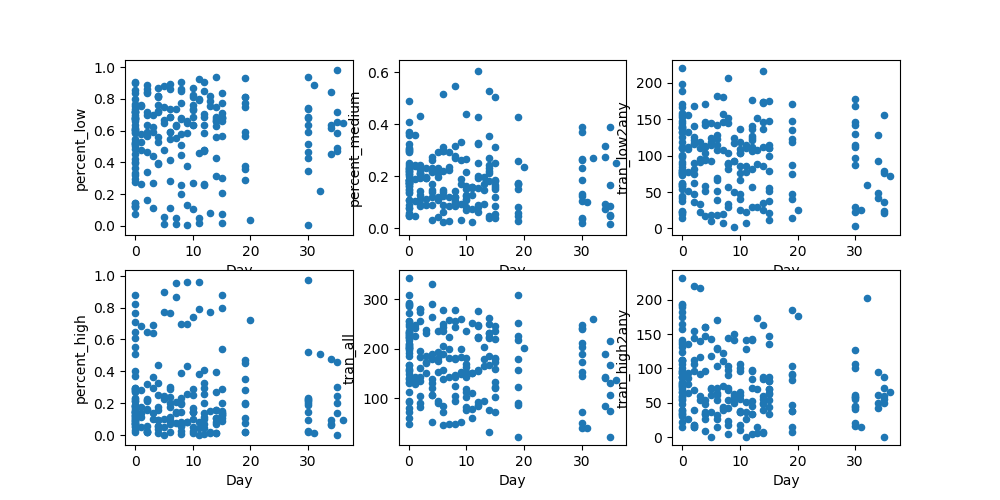

In [6]:
fig, ax = plt.subplots(2,3,figsize=(10,5))
df.plot('Day','percent_low',ax =ax[0,0] ,kind='scatter')
df.plot('Day','percent_high',ax =ax[1,0] ,kind='scatter')
df.plot('Day','percent_medium',ax =ax[0,1] ,kind='scatter')
df.plot('Day','tran_all',ax =ax[1,1] ,kind='scatter')
df.plot('Day','tran_low2any',ax =ax[0,2] ,kind='scatter')
df.plot('Day','tran_high2any',ax =ax[1,2] ,kind='scatter')



<IPython.core.display.Javascript object>


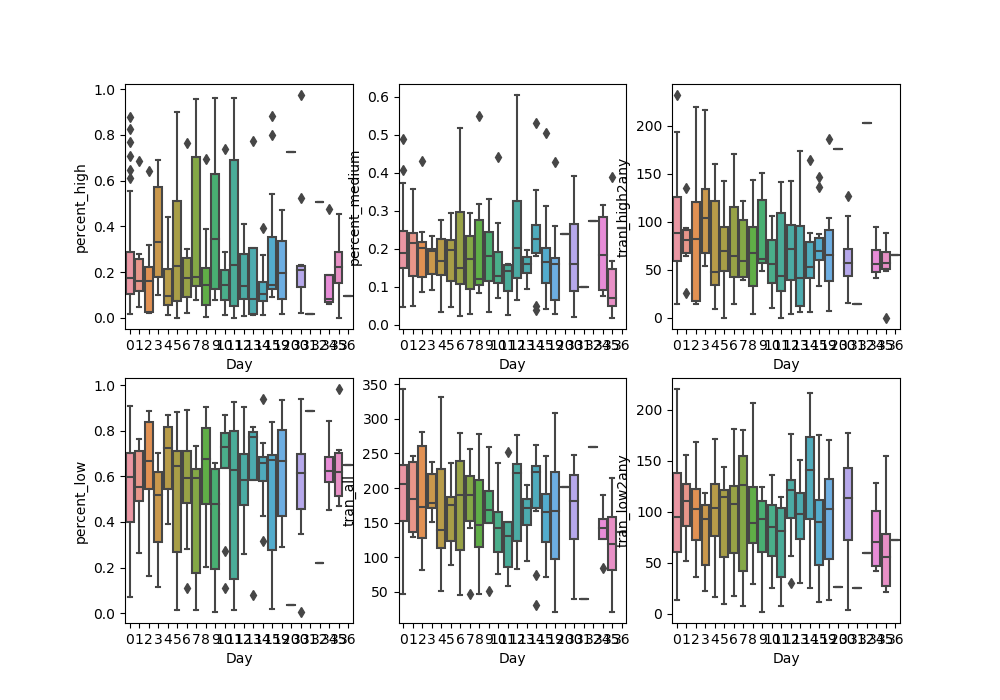

In [44]:
fig, ax = plt.subplots(2,3,figsize=(10,7))
for ind in range(len(columns)):
    sns.boxplot(x="Day", y=columns[ind], data=df,ax =ax[ind%2,int(ind/2)] )



<IPython.core.display.Javascript object>


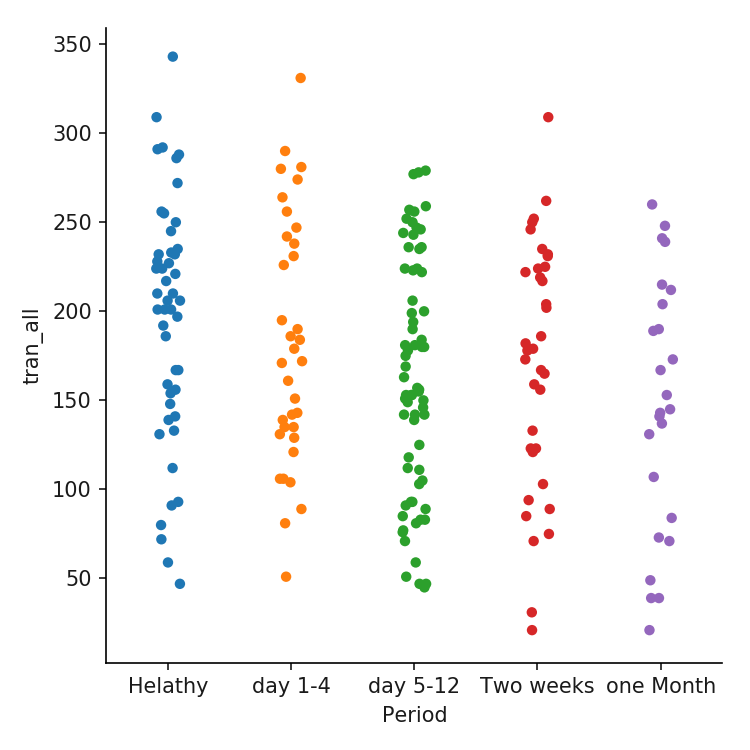

In [5]:
def periodCalc(day):
    if day== 0:
        return 'Helathy'
    elif day<5:
        return 'day 1-4'
    elif day<13:
        return 'day 5-12'
    elif day<21:
        return 'Two weeks'
    else:
        return 'one Month'
df['Period'] =  df.apply (lambda row: periodCalc(row.Day) , axis=1)
sns.catplot(x="Period", y='tran_all', data=df)

<IPython.core.display.Javascript object>


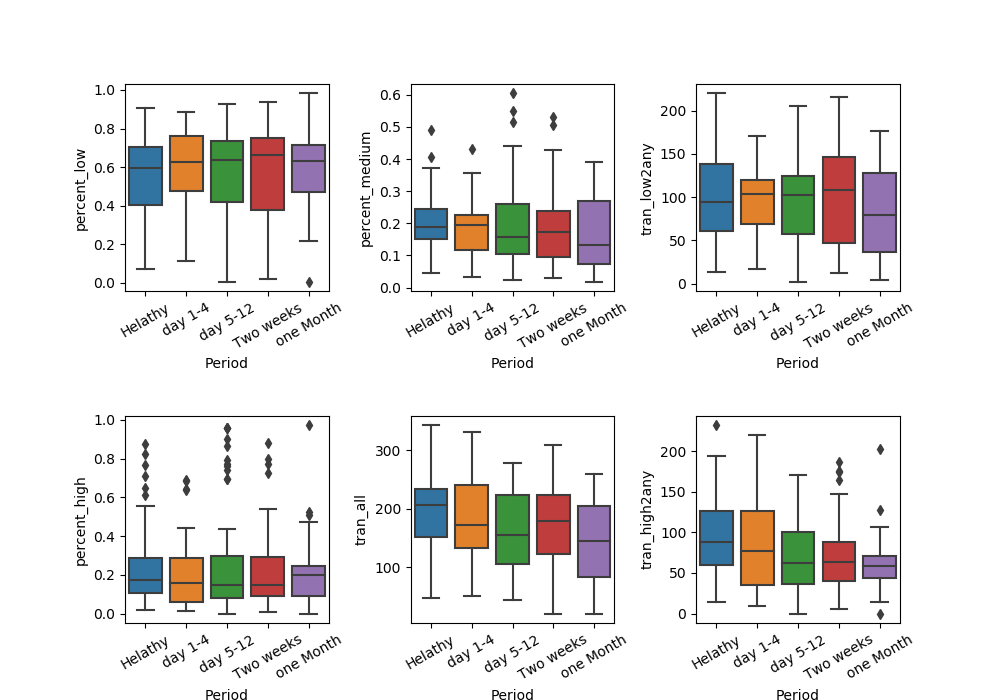

In [9]:
fig, ax = plt.subplots(2,3,figsize=(10,7),gridspec_kw = {'hspace':.6,'wspace':.4})
columns = ['percent_low','percent_high','percent_medium','tran_all','tran_low2any','tran_high2any'] 
for ind in range(len(columns)):
    sns.boxplot(x="Period", y=columns[ind], data=df,ax =ax[ind%2,int(ind/2)] )
    ax[ind%2,int(ind/2)].set_xticklabels(ax[ind%2,int(ind/2)].get_xticklabels(),rotation=30)


<IPython.core.display.Javascript object>


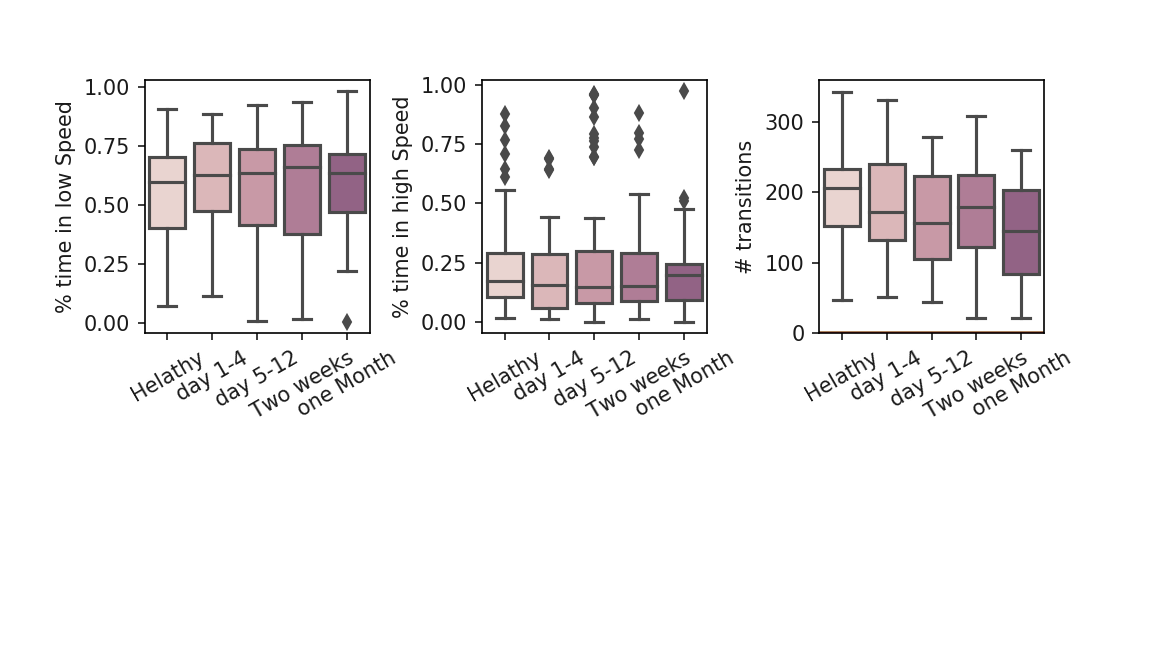

In [39]:

fig, ax = plt.subplots(1,3,figsize=(7.7325,4.45),gridspec_kw = {'hspace':.1,'wspace':.5,'bottom':0.5})
columns = ['percent_low','percent_high','tran_all'] 
labels = ['% time in low Speed','% time in high Speed','# transitions']
for ind in range(len(columns)):
    sns.boxplot(x="Period", y=columns[ind], data=df,ax =ax[ind],palette=sns.cubehelix_palette(8))
    ax[ind].set_xticklabels(ax[ind].get_xticklabels(),rotation=30)
    ax[ind].set_ylabel(labels[ind])
    ax[ind].set_xlabel("")
fig.savefig('figs/mvmt_boxplot.png',transparent=True,format='png')
fig.savefig('figs/mvmt_boxplot.svg',transparent=True,format='svg')

In [ ]:
prs = Presentation()
prs.slide_width = Inches(11)
title_layout = prs.slide_layouts[5] 
title_slide_layout = prs.slide_layouts[0]

slide = prs.slides.add_slide(title_slide_layout)
slide.shapes.title.text = 'high/low Mvmt Periods'
Colors = CP('highLowSpeed')

lf = {'left':0.30, 'top':1.30, 'height':5.80, 'width':8.8}
fArgs = {'left':Inches(lf['left']),'top':Inches(lf['top']), 'height':Inches(lf['height']), 'width':Inches(lf['width'])}

columns = ['percent_high', 'percent_low','percent_medium', 'tran_all', 'tran_high2any', 'tran_low2any']

for m in miceList:
    data = df[df.Mouse==m]

    fig, ax = plt.subplots(2,3,figsize=(10,7),gridspec_kw = {'hspace':.6,'wspace':.4})
    for ind in range(len(columns)):
        sns.boxplot(x="Day", y=columns[ind], data=data,ax =ax[ind%2,int(ind/2)] )
        ax[ind%2,int(ind/2)].set_xticklabels(ax[ind%2,int(ind/2)].get_xticklabels(),rotation=30)
    slide = prs.slides.add_slide(title_layout)
    slide.shapes.title.text = m 
    pic = plt2pptx(slide, fig, **fArgs)
    fig.clf()
    plt.close(fig)

prs.save('ppts/Speed_stats_day.pptx')    


<IPython.core.display.Javascript object>


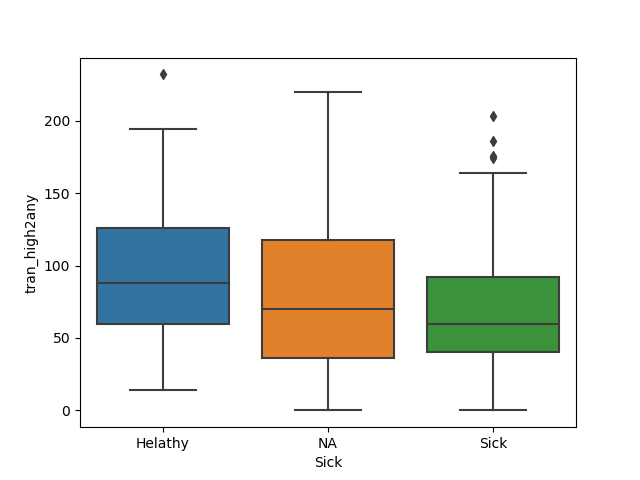

In [92]:
def sickCalc(day):
    if day== 0:
        return 'Helathy'
    elif day>6:
        return 'Sick'
    else:
        return 'NA'
df['Sick'] =  df.apply (lambda row: sickCalc(row.Day) , axis=1)
sns.boxplot(x="Sick", y='tran_high2any',  data=df)

<IPython.core.display.Javascript object>


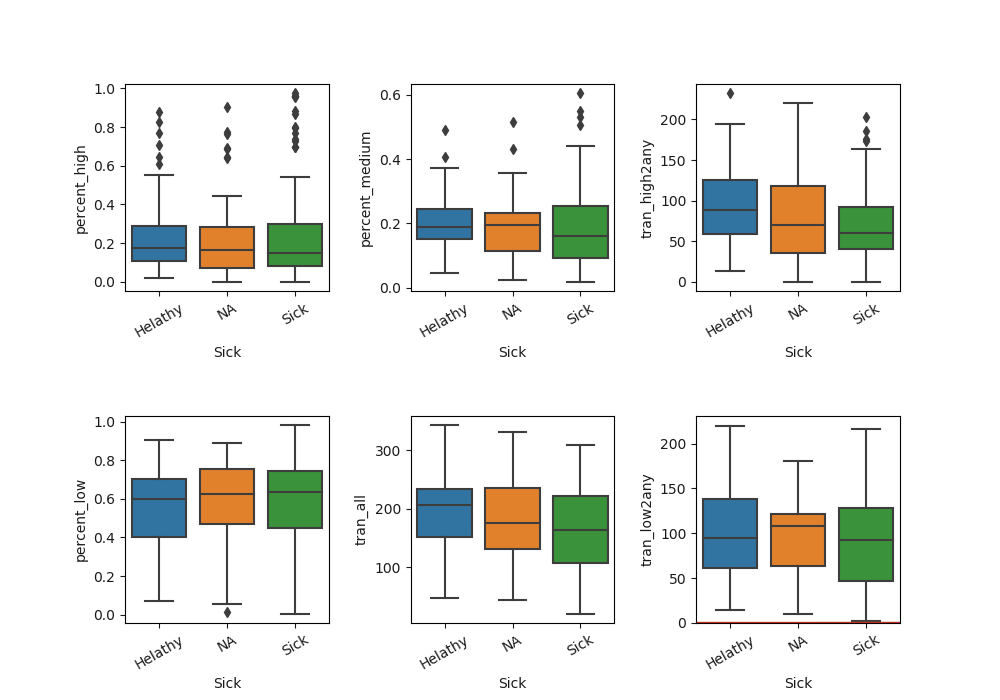

In [93]:
fig, ax = plt.subplots(2,3,figsize=(10,7),gridspec_kw = {'hspace':.6,'wspace':.4})
for ind in range(len(columns)):
    sns.boxplot(x="Sick", y=columns[ind], data=df,ax =ax[ind%2,int(ind/2)] )
    ax[ind%2,int(ind/2)].set_xticklabels(ax[ind%2,int(ind/2)].get_xticklabels(),rotation=30)


<IPython.core.display.Javascript object>


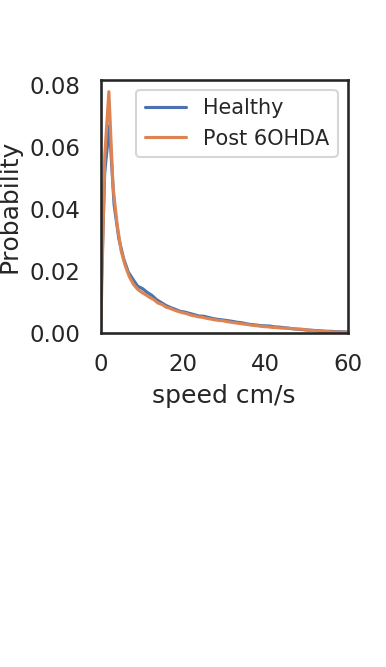

cleaning up speed data
cleaning up speed data


/home/dana_z/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


In [58]:
sns.set(color_codes=True)
sns.set_style("white")
fig, ax = plt.subplots(1,1,figsize=(7.7325/3,4.45),gridspec_kw = {'hspace':.1,'bottom':0.5,'left':.26})

dataH = getData(Files[0],['speed'],period ='Pre', day = lambda x: x==0)
dataP = getData(Files[0],['speed'],period ='Pre', day = lambda x: x>6)

speedH = np.empty((1,0))
speedP = np.empty((1,0))
for sess in dataH:
    speedH = np.concatenate((speedH, dataH[sess]['speed']['speed']), axis=1)
for sess in dataP:
    speedP = np.concatenate((speedP, dataP[sess]['speed']['speed']), axis=1)

sns.distplot(speedH,hist=False,ax=ax,label='Healthy')    
sns.distplot(speedP,hist=False,ax=ax,label='Post 6OHDA') 
ax.set_xlim(0,60)
ax.set_xlabel('speed cm/s')
ax.set_ylabel('Probability')
ax.legend(fontsize=10)
fig.savefig('figs/mvmt_dist.png',transparent=True,format='png')
fig.savefig('figs/mvmt_dist.svg',transparent=True,format='svg')

<IPython.core.display.Javascript object>


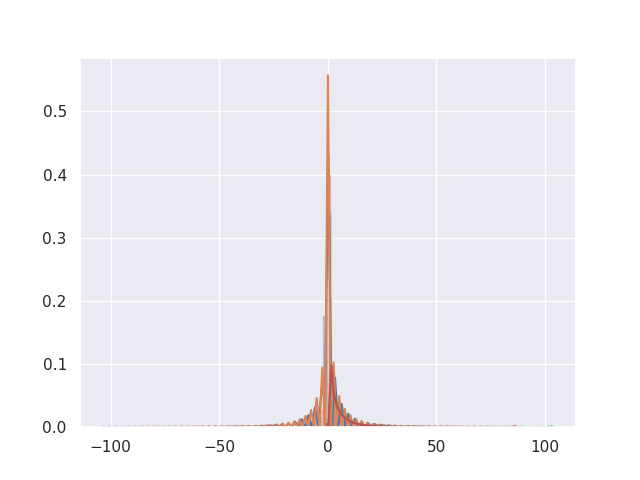

/home/dana_z/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


In [127]:
accH = np.empty((1,0)).T
accP = np.empty((1,0)).T
for sess in dataH:
    speed = dataH[sess]['speed']['speed'].T
    acc = speed[1:]-speed[:-1]
    accH = np.concatenate((accH,acc), axis=0)
for sess in dataP:
    speed = dataP[sess]['speed']['speed'].T
    acc = speed[1:]-speed[:-1]
    accP = np.concatenate((accP, acc), axis=0)

sns.distplot(accH)    
sns.distplot(accP) 

cleaning up speed data


<IPython.core.display.Javascript object>


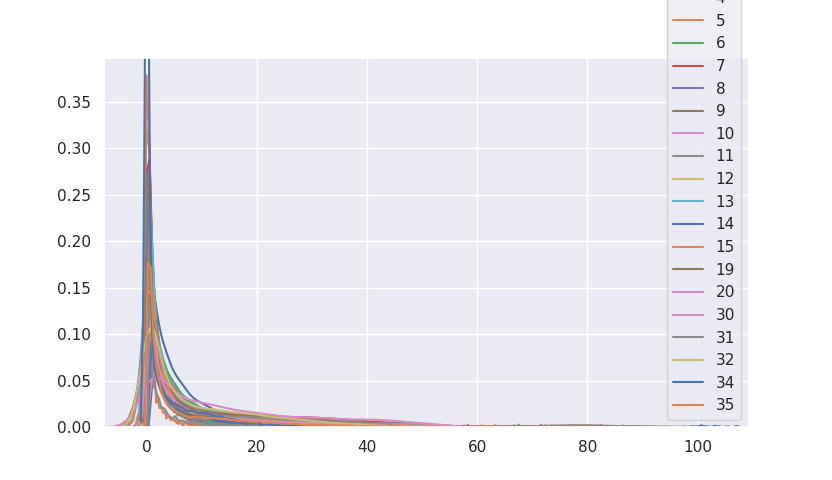

cleaning up speed data
cleaning up speed data


/home/dana_z/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


cleaning up speed data
cleaning up speed data
cleaning up speed data
cleaning up speed data
cleaning up speed data
cleaning up speed data
cleaning up speed data
cleaning up speed data
cleaning up speed data
cleaning up speed data
cleaning up speed data
cleaning up speed data
cleaning up speed data
cleaning up speed data
cleaning up speed data
cleaning up speed data
cleaning up speed data
cleaning up speed data
cleaning up speed data
cleaning up speed data
cleaning up speed data


/home/dana_z/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:198: RuntimeWarning: Mean of empty slice.
  line, = ax.plot(a.mean(), 0)
/home/dana_z/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


cleaning up speed data
cleaning up speed data
cleaning up speed data
cleaning up speed data
cleaning up speed data
cleaning up speed data
cleaning up speed data
cleaning up speed data
cleaning up speed data
cleaning up speed data
cleaning up speed data
cleaning up speed data


In [135]:
for day in range(36):
    dataH = getData(Files[0],['speed'],period ='Pre', day = lambda x: x==day)
    accH = np.empty((1,0)).T
    for sess in dataH:
        speed = dataH[sess]['speed']['speed'].T
        acc = speed[1:]-speed[:-1]
        accH = np.abs(np.concatenate((accH,acc), axis=0))


    sns.distplot(accH,hist=False,label=day)    

In [4]:
for day in range(36):
    dataH = getData(Files[0],['speed'],period ='Pre', day = lambda x: x==day)
    accH = np.empty((1,0)).T
    for sess in dataH:
        speed = dataH[sess]['speed']['speed'].T
#        acc = speed[1:]-speed[:-1]
        accH = np.abs(np.concatenate((accH,speed), axis=0))


    sns.distplot(accH,hist=False,label=day)    

SyntaxError: invalid syntax (<ipython-input-4-18e3fa7480e8>, line 1)

<h2> spectogram aligned to mvmt onset - wavelet method </h2>

In [10]:
# load 1 data session to 
data = getData(Files[0],['lfp'],period ='Pre', day = lambda x: x==0,mice = '0761')
lfp = data['0761_BaselineA']['lfp']['lfp']
FS = data['0761_BaselineA']['lfp']['FS']
print(lfp.shape,FS)

cleaning up lfp data
(1815677, 1) [3051.7578125]


In [19]:
f = np.empty((408,1))
for j in range(12,420):
    f[j-12]=pywt.scale2frequency('morl', j)*3051.7578125
[intF,inds] = np.unique(np.floor(f),return_index=True)
print(len(inds))

83


In [8]:
# calculate and plot spectogram using wavelets:
waveletsOptions = ['haar', 'db', 'sym', 'coif', 'bior', 'rbio', 'dmey',
                    'gaus','mexh', 'morl', 'cgau', 'shan', 'fbsp', 'cmor']

waveletName = 'morl' #must be from waveletsOptions
scales = inds+12
dt = 1/FS
[coefficients, frequencies] = pywt.cwt(lfp[:,0], scales, waveletName, dt)
print(coefficients.shape,frequencies.shape)

(83, 1815677) (83,)


<IPython.core.display.Javascript object>


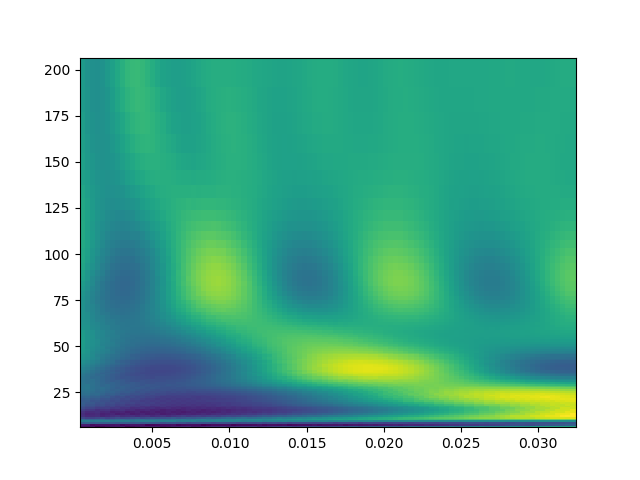

In [13]:
# plot spectogram:
N = lfp[:,0].shape[0]
t =  np.arange(0, N) * dt 
fig, ax  = plt.subplots(1,1)
ax.pcolormesh(t[1:100],frequencies,coefficients[:,1:100])

In [ ]:
# save all full spectograms in hdf5 file:
# create hdf5 file with all the mice and mvmt Onset
f = h5py.File('Spectograms.hdf5','a')

fr = np.empty((408,1))
for j in range(12,420):
    fr[j-12]=pywt.scale2frequency('morl', j)*3051.7578125
[intF,inds] = np.unique(np.floor(fr),return_index=True)

waveletName = 'morl' #must be from waveletsOptions
scales = inds+12

miceList = getMiceList(Files[0])
for m in miceList:
    grp = f.create_group(m)
    data_pre = getData(Files[0],['lfp'],period ='Pre', mice=m)
    data_post = getData(Files[0],['lfp'],period ='Post', mice=m)
    days = np.zeros(len(data_pre))
    ind = 0
    # sort by session for my own OCD
    for sess in data_pre:
        if sess[5] == 'B':
            day = 0
        else:
            day = int(re.findall(r'\d+',sess[5:])[0])
        days[ind] = day
        ind= ind+1
    a = np.argsort(days)
    dKeys = list(data_pre.keys())
    # calculte high speed period, do 3 sessions per plot, and stor in ppt
    ind = 0;
    for aa in tqdm(range(0,len(data_pre))):
        sess = dKeys[a[aa]]
        lfp = data_pre[sess]['lfp']['lfp']
        FS = data_pre[sess]['lfp']['FS']
        dt = 1/FS
        [coefficients, frequencies] = pywt.cwt(lfp[:,0], scales, waveletName, dt)
        
        subgrp = grp.create_group(sess)
        ssubgrp = subgrp.create_group('Pre')
        ssubgrp['freq'] = frequencies
        ssubgrp['coeff'] = coefficients
        del frequencies
        del coefficients
        if sess in data_post.keys():
            lfp = data_post[sess]['lfp']['lfp']
            FS = data_post[sess]['lfp']['FS']
            [coefficients, frequencies] = pywt.cwt(lfp[:,0], scales, waveletName, dt)
            spsubgrp = subgrp.create_group('Post')
            spsubgrp['freq'] = frequencies
            spsubgrp['coeff'] = coefficients
            del frequencies
            del coefficients
        
f.close()   

In [70]:
minS = 45
maxS = 950
waveletName = 'cmor14.0-1.5'
f = np.empty((maxS-minS,1))
for j in range(minS,maxS):
    f[j-minS]=pywt.scale2frequency(waveletName , j)*(1/dt)
[intF,inds] = np.unique(np.floor(f),return_index=True)
print(f[inds].T)

[[  4.99742      5.99952388   6.99944452   7.9888948    8.99339237
    9.99484     10.97754609  11.9833422   12.9678094   13.99888905
   14.95959712  15.94995372  16.95421007  17.95151654  18.99434323
   19.98967999  20.99833357  21.90256803  22.88818359  23.96668439
   24.87846043  25.86235434  26.92727482  27.91241902  28.9723843
   29.91919424  30.92997783  31.78914388  32.93263826  33.90842014
   34.94379175  35.76278687  36.91642515  37.83170842  38.79353151
   39.80553668  40.87175642  41.99666714  42.78165158  43.59654018
   44.87879136  45.77636719  46.71057876  47.68371582  48.69826297
   49.75692086  50.86263021  51.43412044  52.61651401  53.85454963
   54.49567522  55.82483803  56.51403356  57.94476859  58.68765024
   59.44982752  60.23206209  61.85995566  62.70735231  63.57828776
   64.4737566   65.39481027  66.34256114  67.31818704  68.3229361
   69.3581321   70.42518029  71.52557373  72.6609003   73.8328503
   75.0432249   76.29394531  77.58706303  78.92477101  80.3094161

In [71]:
# calculate and plot spectogram using wavelets:
waveletsOptions = ['haar', 'db', 'sym', 'coif', 'bior', 'rbio', 'dmey',
                    'gaus','mexh', 'morl', 'cgau', 'shan', 'fbsp', 'cmor']

#waveletName = 'cmor2.0-1.5' #must be from waveletsOptions
scales = inds+minS
dt = 1/FS
[coefficients, frequencies] = pywt.cwt(lfp[:,0], scales, waveletName, dt)
print(coefficients.shape,frequencies.shape)

(87, 5437112) (87,)


<IPython.core.display.Javascript object>


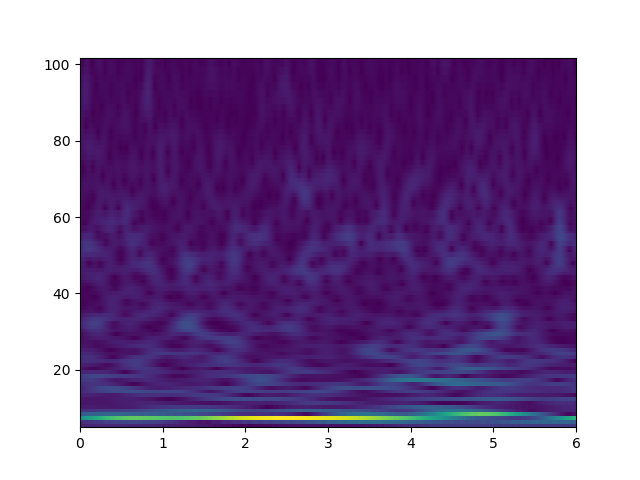

(0, 6)

In [73]:
# plot spectogram:
N = lfp[:,0].shape[0]
t =  np.arange(0, N) * dt 
fig, ax  = plt.subplots(1,1)
ax.pcolormesh(t[:20000],frequencies,np.abs(coefficients[:,0:20000]))
ax.set_xlim(0,6)

In [75]:
# save all full spectograms in hdf5 file:
# create hdf5 file with all the mice and mvmt Onset
f = h5py.File('Spectograms.hdf5','a')

#waveletName = 'cmor14.0-1.5' #must be from waveletsOptions
#scales = inds+minS

miceList = getMiceList(Files[0])
for m in miceList:
    grp = f.create_group(m)
    grp['freq'] = frequencies
    data_pre = getData(Files[0],['lfp'],period ='Pre', mice=m)
    data_post = getData(Files[0],['lfp'],period ='Post', mice=m)
    days = np.zeros(len(data_pre))
    ind = 0
    # sort by session for my own OCD
    for sess in data_pre:
        if sess[5] == 'B':
            day = 0
        else:
            day = int(re.findall(r'\d+',sess[5:])[0])
        days[ind] = day
        ind= ind+1
    a = np.argsort(days)
    dKeys = list(data_pre.keys())
    # calculte high speed period, do 3 sessions per plot, and stor in ppt
    ind = 0;
    for aa in tqdm(range(0,len(data_pre))):
        sess = dKeys[a[aa]]
        lfp = data_pre[sess]['lfp']['lfp']
        FS = data_pre[sess]['lfp']['FS']
        dt = 1/FS
        [coefficients, frequencies] = pywt.cwt(lfp[:,0], scales, waveletName, dt)
        
        subgrp = grp.create_group(sess)
        ssubgrp = subgrp.create_group('Pre')
#        ssubgrp['freq'] = frequencies
        ssubgrp['coeff'] = coefficients
#        del frequencies
        del coefficients
        if sess in data_post.keys():
            lfp = data_post[sess]['lfp']['lfp']
            FS = data_post[sess]['lfp']['FS']
            [coefficients, frequencies] = pywt.cwt(lfp[:,0], scales, waveletName, dt)
            spsubgrp = subgrp.create_group('Post')
#            spsubgrp['freq'] = frequencies
            spsubgrp['coeff'] = coefficients
#            del frequencies
            del coefficients
        
f.close()   

cleaning up lfp data



  0%|          | 0/14 [00:00<?, ?it/s]

cleaning up lfp data
I deleted session: 0761_day1
I deleted session: 0761_day10
I deleted session: 0761_day12
I deleted session: 0761_day2
I deleted session: 0761_day4
I deleted session: 0761_day6
I deleted session: 0761_day8



100%|██████████| 14/14 [1:09:54<00:00, 402.23s/it]


cleaning up lfp data
I deleted session: 1208_day12



  0%|          | 0/13 [00:00<?, ?it/s]

cleaning up lfp data
I deleted session: 1208_day10
I deleted session: 1208_day12
I deleted session: 1208_day14
I deleted session: 1208_day2
I deleted session: 1208_day4
I deleted session: 1208_day6
I deleted session: 1208_day8



100%|██████████| 13/13 [1:08:24<00:00, 407.17s/it]


cleaning up lfp data



  0%|          | 0/14 [00:00<?, ?it/s]

cleaning up lfp data
I deleted session: 1222_day11
I deleted session: 1222_day13
I deleted session: 1222_day2
I deleted session: 1222_day3
I deleted session: 1222_day5
I deleted session: 1222_day7
I deleted session: 1222_day9



100%|██████████| 14/14 [1:10:16<00:00, 403.78s/it]


cleaning up lfp data



  0%|          | 0/3 [00:00<?, ?it/s]

cleaning up lfp data



100%|██████████| 3/3 [23:53<00:00, 478.43s/it]


cleaning up lfp data



  0%|          | 0/14 [00:00<?, ?it/s]

cleaning up lfp data
I deleted session: 1236_day1
I deleted session: 1236_day11
I deleted session: 1236_day13
I deleted session: 1236_day3
I deleted session: 1236_day5
I deleted session: 1236_day7
I deleted session: 1236_day9



100%|██████████| 14/14 [1:08:41<00:00, 400.46s/it]


cleaning up lfp data



  0%|          | 0/3 [00:00<?, ?it/s]

cleaning up lfp data



100%|██████████| 3/3 [23:36<00:00, 466.74s/it]


cleaning up lfp data



  0%|          | 0/14 [00:00<?, ?it/s]

cleaning up lfp data
I deleted session: 1793_day10
I deleted session: 1793_day12
I deleted session: 1793_day14
I deleted session: 1793_day2
I deleted session: 1793_day4
I deleted session: 1793_day6
I deleted session: 1793_day8



100%|██████████| 14/14 [1:09:41<00:00, 401.20s/it]


cleaning up lfp data
I deleted session: 2976_day4



  0%|          | 0/13 [00:00<?, ?it/s]

cleaning up lfp data
I deleted session: 2976_day10
I deleted session: 2976_day12
I deleted session: 2976_day14
I deleted session: 2976_day2
I deleted session: 2976_day4
I deleted session: 2976_day6
I deleted session: 2976_day8



100%|██████████| 13/13 [1:07:53<00:00, 403.68s/it]


cleaning up lfp data



  0%|          | 0/14 [00:00<?, ?it/s]

cleaning up lfp data
I deleted session: 2980_day10
I deleted session: 2980_day12
I deleted session: 2980_day14
I deleted session: 2980_day2
I deleted session: 2980_day4
I deleted session: 2980_day6
I deleted session: 2980_day8



100%|██████████| 14/14 [1:09:32<00:00, 399.87s/it]


cleaning up lfp data



  0%|          | 0/14 [00:00<?, ?it/s]

cleaning up lfp data
I deleted session: 2981_day10
I deleted session: 2981_day12
I deleted session: 2981_day14
I deleted session: 2981_day2
I deleted session: 2981_day4
I deleted session: 2981_day6
I deleted session: 2981_day8



100%|██████████| 14/14 [1:09:06<00:00, 395.61s/it]


cleaning up lfp data



  0%|          | 0/19 [00:00<?, ?it/s]

cleaning up lfp data
I deleted session: 4539_day0
I deleted session: 4539_day1
I deleted session: 4539_day10
I deleted session: 4539_day11
I deleted session: 4539_day12
I deleted session: 4539_day13
I deleted session: 4539_day14
I deleted session: 4539_day2
I deleted session: 4539_day3
I deleted session: 4539_day4
I deleted session: 4539_day5
I deleted session: 4539_day6
I deleted session: 4539_day7
I deleted session: 4539_day8
I deleted session: 4539_day9



100%|██████████| 19/19 [57:39<00:00, 304.39s/it]

  0%|          | 0/17 [00:00<?, ?it/s]

cleaning up lfp data
cleaning up lfp data
I deleted session: 7584_Baseline0
I deleted session: 7584_day0
I deleted session: 7584_day1
I deleted session: 7584_day10
I deleted session: 7584_day11
I deleted session: 7584_day12
I deleted session: 7584_day15
I deleted session: 7584_day2
I deleted session: 7584_day3
I deleted session: 7584_day4
I deleted session: 7584_day5
I deleted session: 7584_day6
I deleted session: 7584_day7
I deleted session: 7584_day8
I deleted session: 7584_day9



100%|██████████| 17/17 [41:40<00:00, 228.01s/it]


cleaning up lfp data



  0%|          | 0/19 [00:00<?, ?it/s]

cleaning up lfp data
I deleted session: 7909_day0
I deleted session: 7909_day1
I deleted session: 7909_day10
I deleted session: 7909_day11
I deleted session: 7909_day12
I deleted session: 7909_day13
I deleted session: 7909_day14
I deleted session: 7909_day2
I deleted session: 7909_day3
I deleted session: 7909_day4
I deleted session: 7909_day5
I deleted session: 7909_day6
I deleted session: 7909_day7
I deleted session: 7909_day8
I deleted session: 7909_day9



100%|██████████| 19/19 [57:50<00:00, 304.71s/it]


cleaning up lfp data



  0%|          | 0/13 [00:00<?, ?it/s]

cleaning up lfp data
I deleted session: 8430_day1
I deleted session: 8430_day11
I deleted session: 8430_day3
I deleted session: 8430_day5
I deleted session: 8430_day7
I deleted session: 8430_day9



100%|██████████| 13/13 [1:07:20<00:00, 405.82s/it]


cleaning up lfp data



  0%|          | 0/14 [00:00<?, ?it/s]

cleaning up lfp data
I deleted session: 8803_day10
I deleted session: 8803_day12
I deleted session: 8803_day14
I deleted session: 8803_day2
I deleted session: 8803_day4
I deleted session: 8803_day5
I deleted session: 8803_day6
I deleted session: 8803_day8



100%|██████████| 14/14 [1:03:55<00:00, 366.34s/it]


cleaning up lfp data



  0%|          | 0/14 [00:00<?, ?it/s]

cleaning up lfp data
I deleted session: 8815_day10
I deleted session: 8815_day12
I deleted session: 8815_day14
I deleted session: 8815_day2
I deleted session: 8815_day4
I deleted session: 8815_day6
I deleted session: 8815_day8



100%|██████████| 14/14 [1:10:01<00:00, 402.29s/it]


  0%|          | 0/16 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


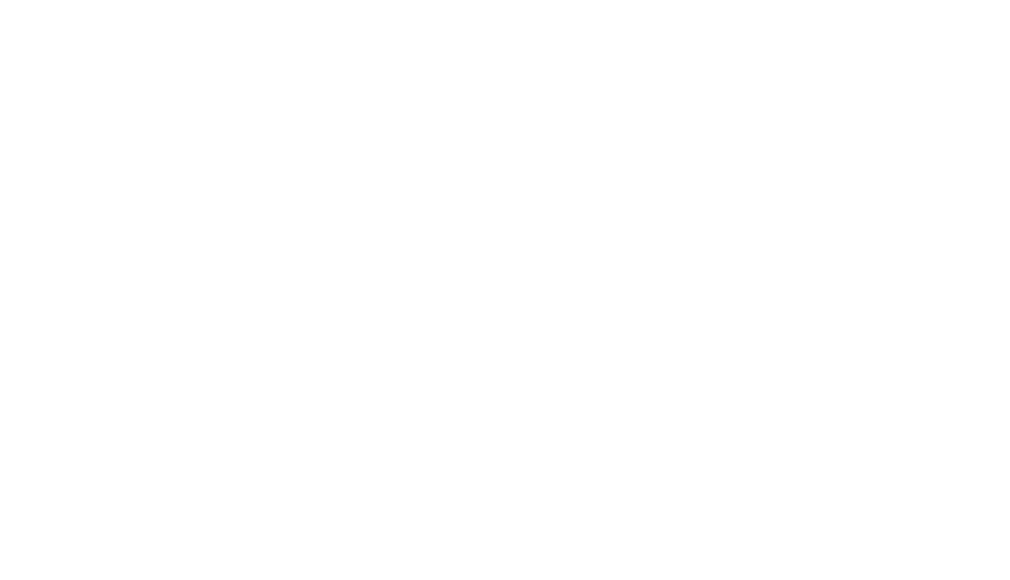

cleaning up lfp data
cleaning up speed data


/home/dana_z/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: DeprecationWarning: object of type <class 'numpy.ndarray'> cannot be safely interpreted as an integer.


found  0.0  outlier points
found  0.0  outlier points
(12206, 87, 14) (12206, 87, 15)
found  0.0  outlier points
(12206, 87, 29) (12206, 87, 8)
cleaning up lfp data
cleaning up speed data


/home/dana_z/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:87: DeprecationWarning: object of type <class 'numpy.ndarray'> cannot be safely interpreted as an integer.


found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points


  6%|▋         | 1/16 [01:17<19:27, 77.85s/it]

<IPython.core.display.Javascript object>


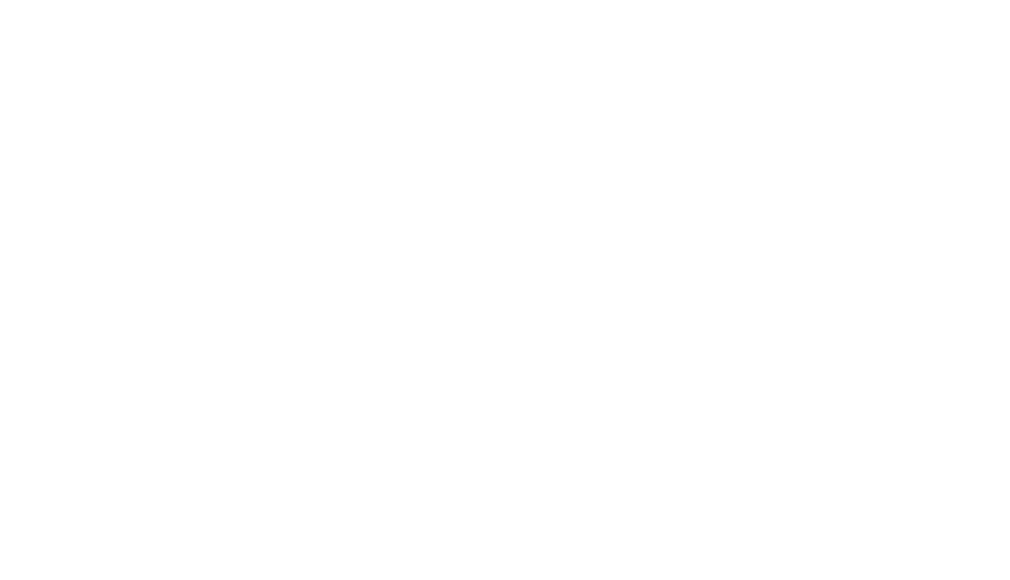

cleaning up lfp data
cleaning up speed data
found  0.0  outlier points
found  0.0  outlier points
(12206, 87, 8) (12206, 87, 14)
found  0.0  outlier points
(12206, 87, 22) (12206, 87, 14)
cleaning up lfp data
I deleted session: 1208_day12
cleaning up speed data
found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points
found  17.0  outlier points
found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points


 12%|█▎        | 2/16 [02:39<18:25, 78.97s/it]

<IPython.core.display.Javascript object>


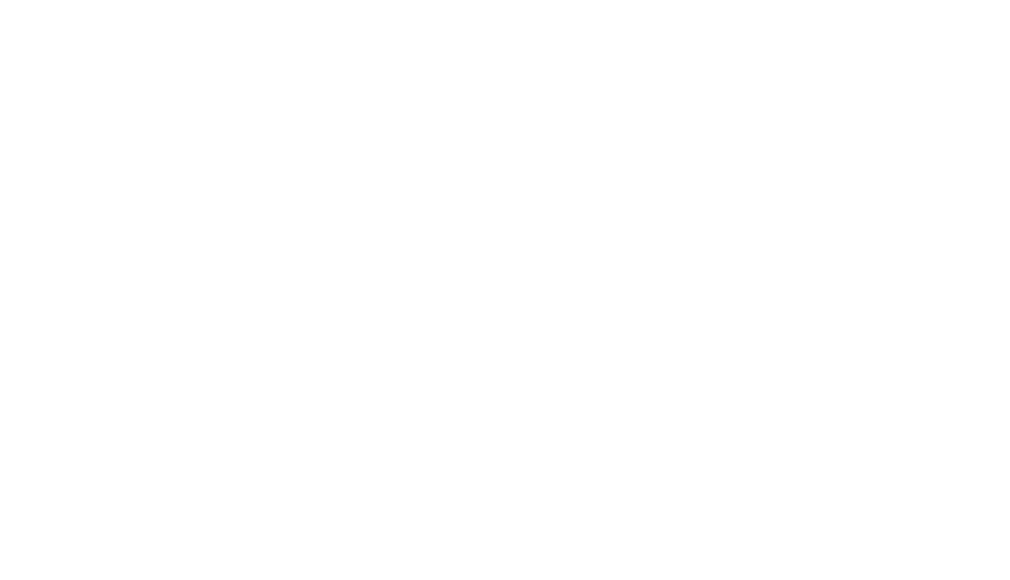

cleaning up lfp data
cleaning up speed data
found  0.0  outlier points
found  0.0  outlier points
(12206, 87, 10) (12206, 87, 17)
found  0.0  outlier points
(12206, 87, 27) (12206, 87, 7)
cleaning up lfp data
cleaning up speed data
found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points


 19%|█▉        | 3/16 [04:04<17:28, 80.66s/it]

<IPython.core.display.Javascript object>


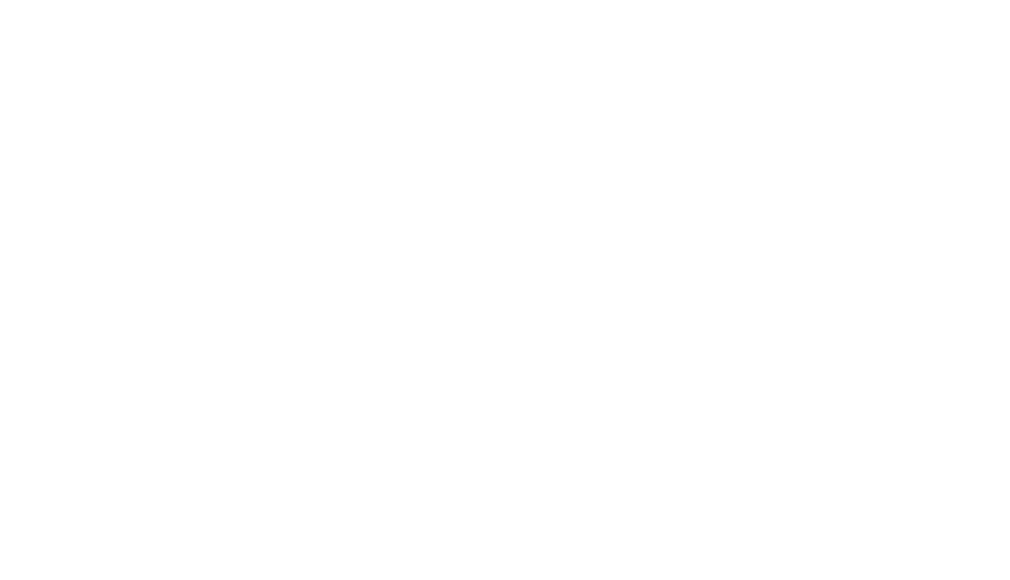

cleaning up lfp data
cleaning up speed data
found  0.0  outlier points
found  0.0  outlier points
(12206, 87, 14) (12206, 87, 14)
found  0.0  outlier points
(12206, 87, 28) (12206, 87, 6)
cleaning up lfp data
cleaning up speed data


 25%|██▌       | 4/16 [04:26<12:40, 63.34s/it]

<IPython.core.display.Javascript object>


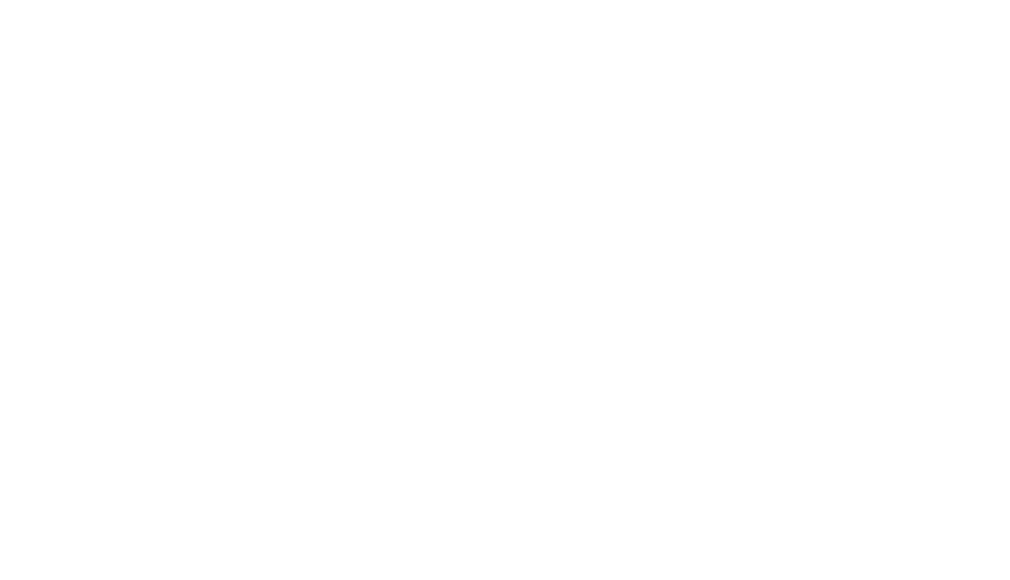

cleaning up lfp data
cleaning up speed data
found  1.0  outlier points
found  0.0  outlier points
(12206, 87, 14) (12206, 87, 30)
found  0.0  outlier points
(12206, 87, 44) (12206, 87, 19)
cleaning up lfp data
cleaning up speed data
found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points
found  888231.0  outlier points
found  481139.0  outlier points
found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points


 31%|███▏      | 5/16 [05:57<13:05, 71.38s/it]

<IPython.core.display.Javascript object>


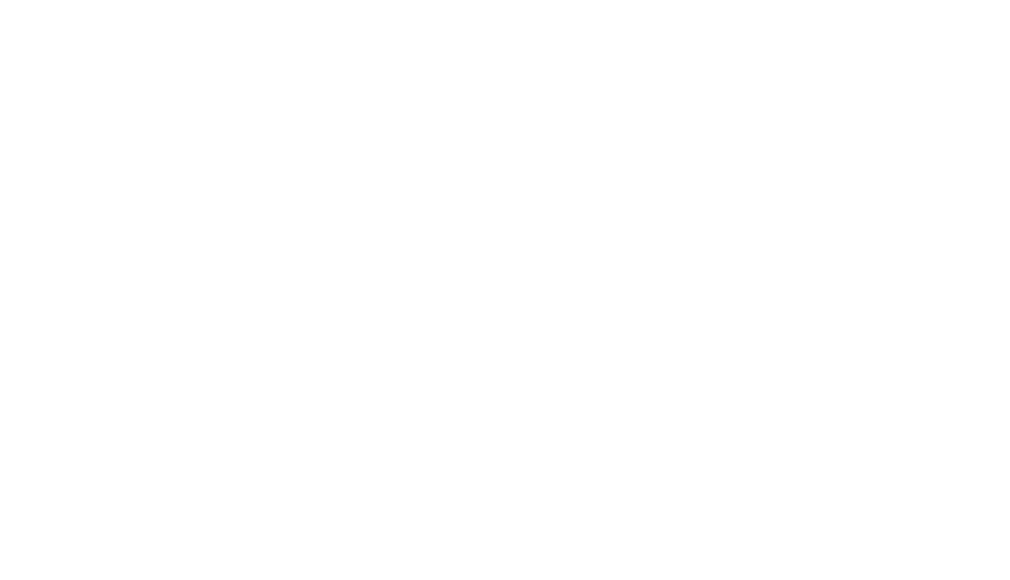

cleaning up lfp data
cleaning up speed data
found  0.0  outlier points
found  0.0  outlier points
(12206, 87, 6) (12206, 87, 6)
found  0.0  outlier points
(12206, 87, 12) (12206, 87, 8)
cleaning up lfp data
cleaning up speed data


 38%|███▊      | 6/16 [06:19<09:28, 56.81s/it]

<IPython.core.display.Javascript object>


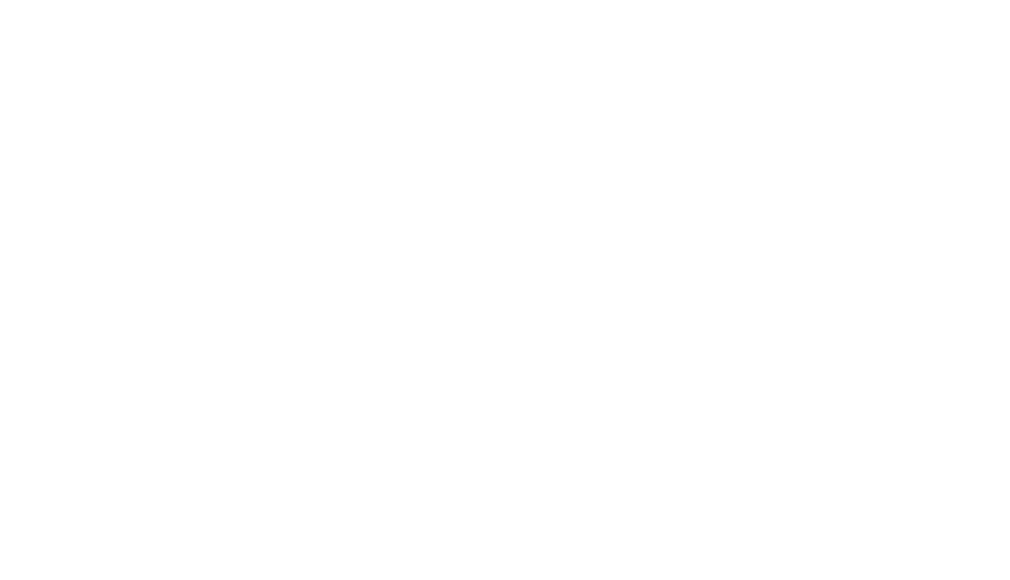

cleaning up lfp data
cleaning up speed data
found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points
(12206, 87, 21) (12206, 87, 17)
cleaning up lfp data
cleaning up speed data
found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points


 44%|████▍     | 7/16 [07:56<10:19, 68.86s/it]

<IPython.core.display.Javascript object>


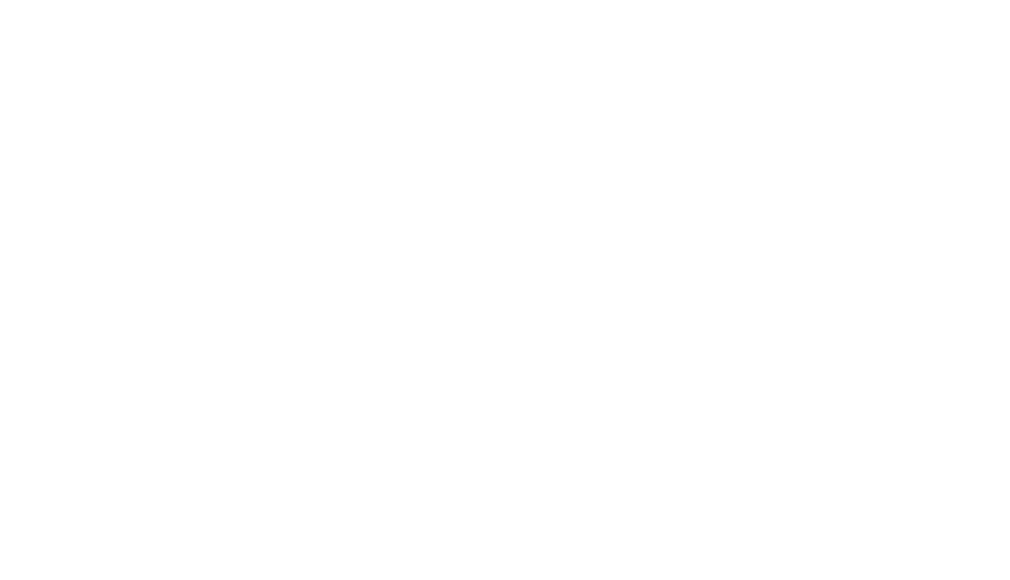

cleaning up lfp data
cleaning up speed data
found  1.0  outlier points
found  0.0  outlier points
(12206, 87, 6) (12206, 87, 6)
found  0.0  outlier points
(12206, 87, 12) (12206, 87, 17)
cleaning up lfp data
I deleted session: 2976_day4
cleaning up speed data
found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points
found  3.0  outlier points


 50%|█████     | 8/16 [09:23<09:53, 74.25s/it]

<IPython.core.display.Javascript object>


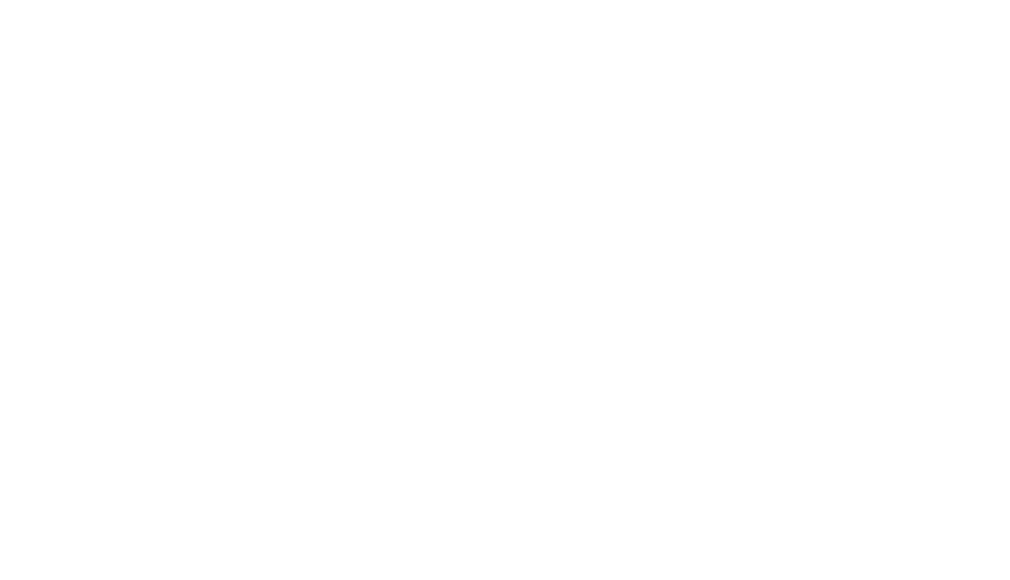

cleaning up lfp data
cleaning up speed data
found  0.0  outlier points
found  0.0  outlier points
(12206, 87, 8) (12206, 87, 21)
found  0.0  outlier points
(12206, 87, 29) (12206, 87, 4)
cleaning up lfp data
cleaning up speed data
found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points


 56%|█████▋    | 9/16 [10:58<09:23, 80.54s/it]

<IPython.core.display.Javascript object>


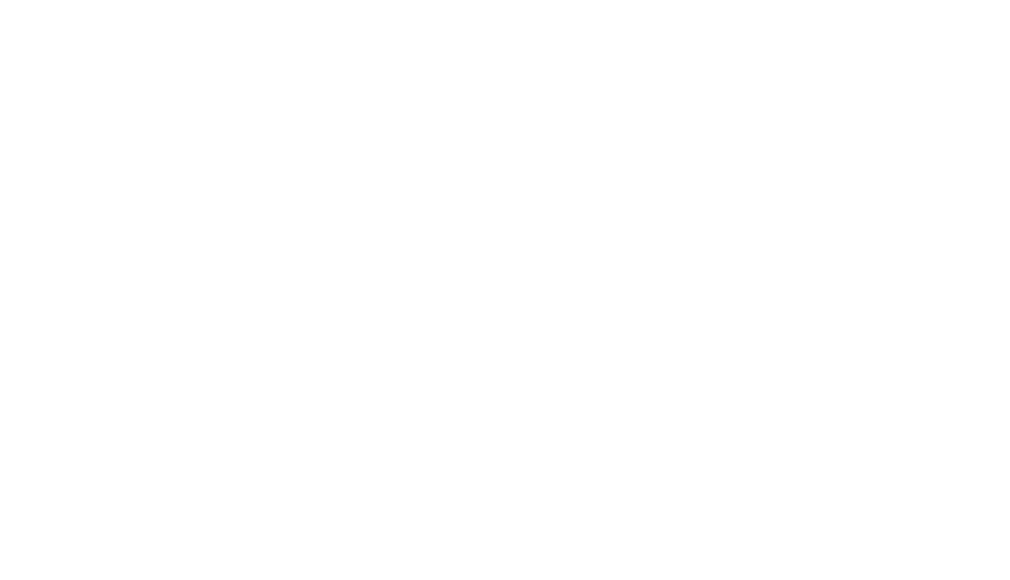

cleaning up lfp data
cleaning up speed data
found  0.0  outlier points
found  0.0  outlier points
(12206, 87, 23) (12206, 87, 23)
found  0.0  outlier points
(12206, 87, 46) (12206, 87, 12)
cleaning up lfp data
cleaning up speed data
found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points
found  50.0  outlier points
found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points


 62%|██████▎   | 10/16 [12:33<08:28, 84.69s/it]

<IPython.core.display.Javascript object>


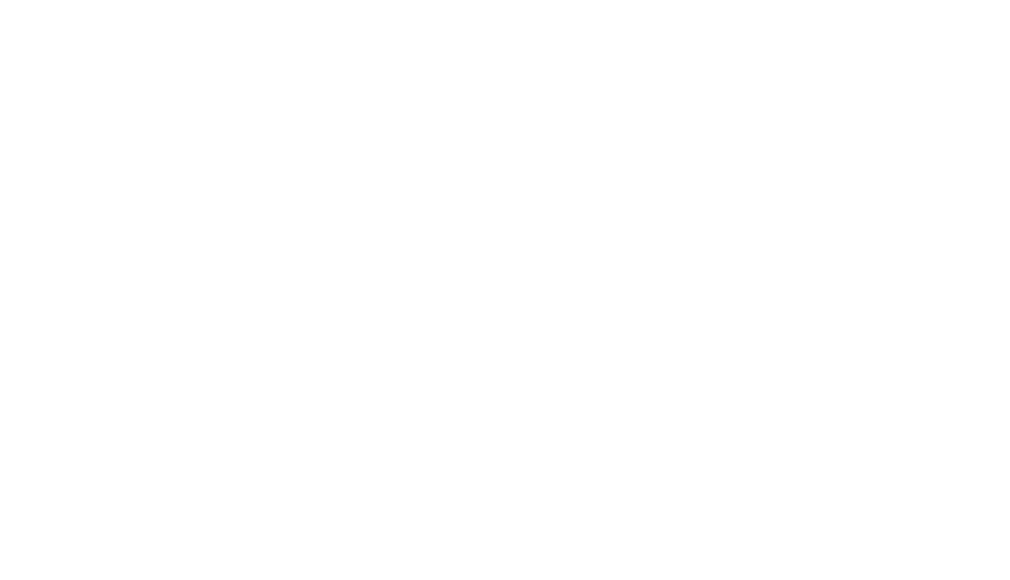

cleaning up lfp data
cleaning up speed data
found  0.0  outlier points
found  0.0  outlier points
(12206, 87, 4) (12206, 87, 2)
found  0.0  outlier points
(12206, 87, 6) (12206, 87, 9)
cleaning up lfp data
cleaning up speed data
found  29.0  outlier points
found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points


 69%|██████▉   | 11/16 [14:25<07:44, 92.93s/it]

<IPython.core.display.Javascript object>


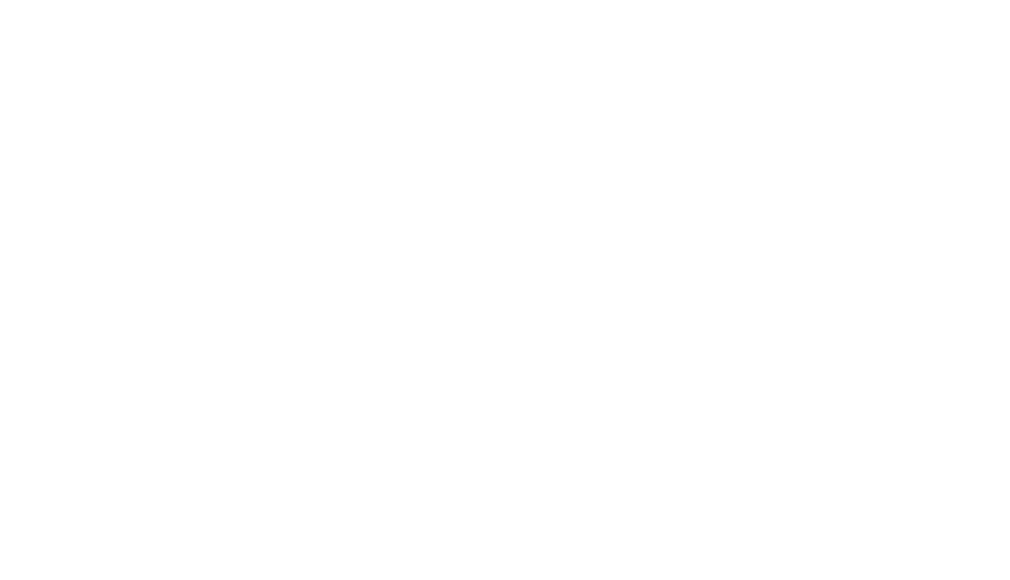

cleaning up lfp data
cleaning up speed data
found  0.0  outlier points
found  0.0  outlier points
(12206, 87, 5) (12206, 87, 7)
found  0.0  outlier points
(12206, 87, 12) (12206, 87, 9)
cleaning up lfp data
cleaning up speed data
found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points


 75%|███████▌  | 12/16 [16:08<06:23, 95.84s/it]

<IPython.core.display.Javascript object>


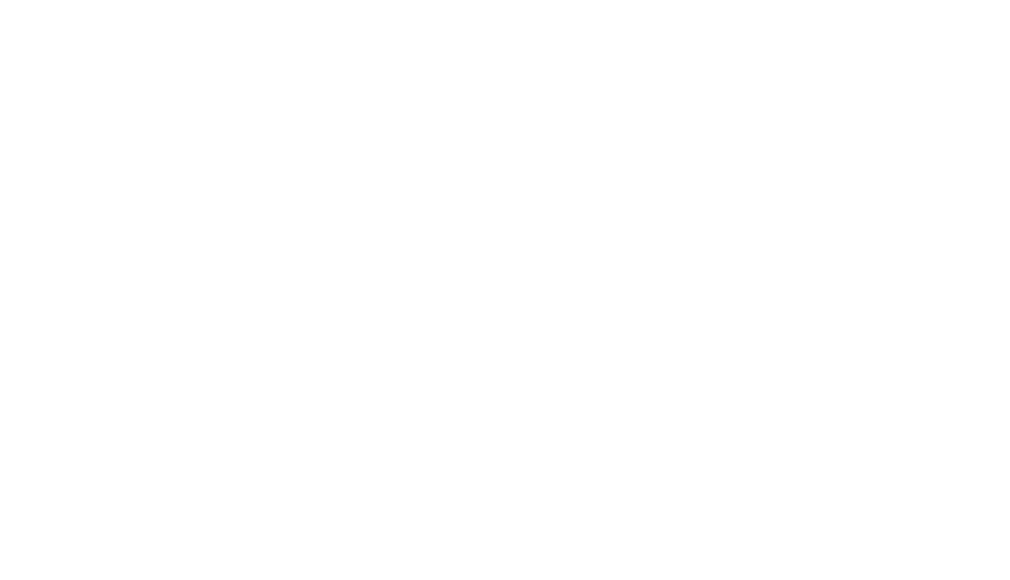

cleaning up lfp data
cleaning up speed data
found  0.0  outlier points
found  0.0  outlier points
(12206, 87, 25) (12206, 87, 20)
found  0.0  outlier points
(12206, 87, 45) (12206, 87, 15)
cleaning up lfp data
cleaning up speed data
found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points


 81%|████████▏ | 13/16 [18:03<05:04, 101.58s/it]

<IPython.core.display.Javascript object>


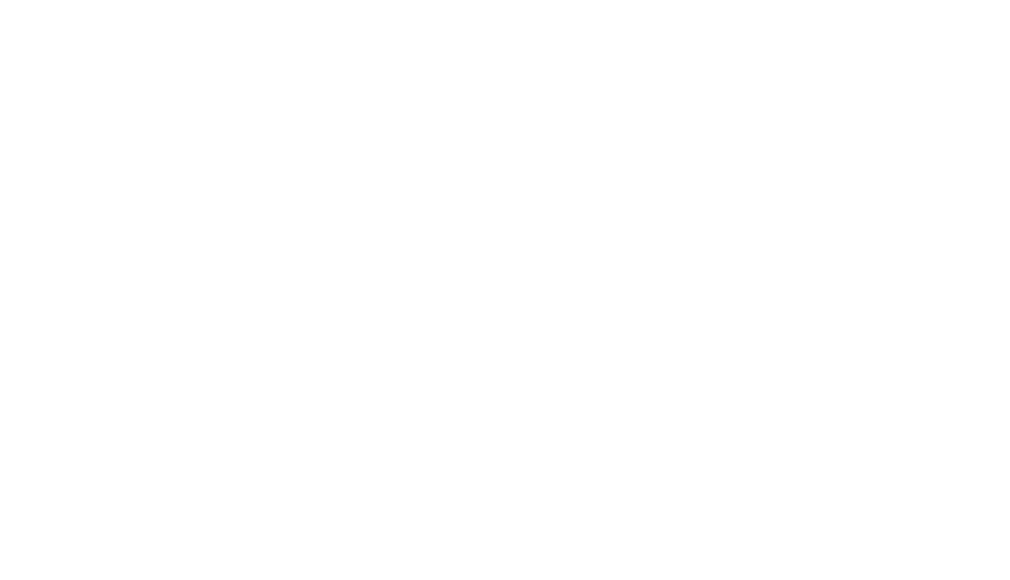

cleaning up lfp data
cleaning up speed data
found  0.0  outlier points
found  0.0  outlier points
(12206, 87, 0) (12206, 87, 4)
found  0.0  outlier points
(12206, 87, 4) (12206, 87, 2)
cleaning up lfp data
cleaning up speed data
found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points


 88%|████████▊ | 14/16 [19:23<03:10, 95.26s/it] 

<IPython.core.display.Javascript object>


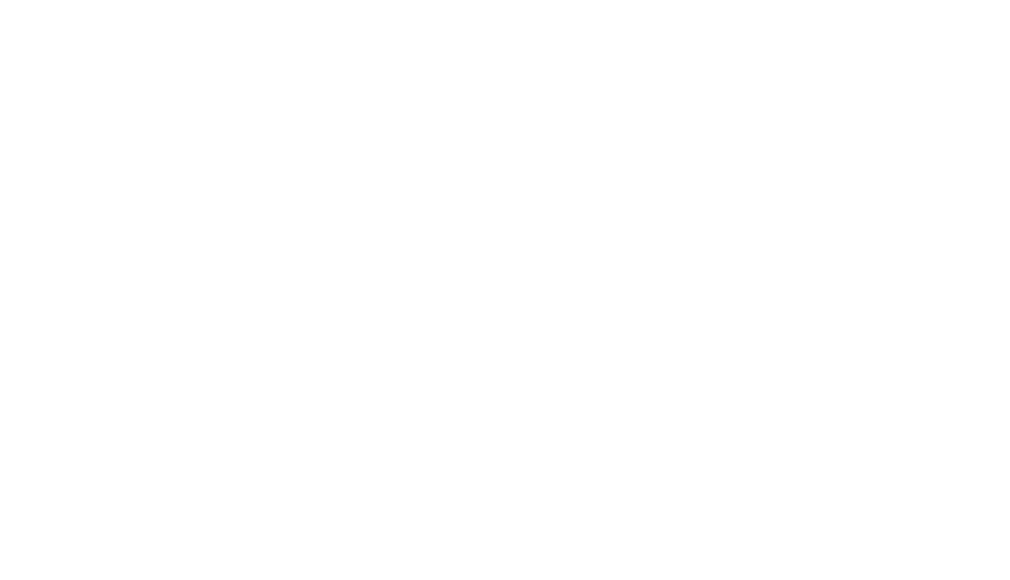

cleaning up lfp data
cleaning up speed data
found  0.0  outlier points
found  0.0  outlier points
(12206, 87, 6) (12206, 87, 29)
found  0.0  outlier points
(12206, 87, 35) (12206, 87, 39)
cleaning up lfp data
cleaning up speed data
found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points


 94%|█████████▍| 15/16 [21:00<01:35, 95.66s/it]

<IPython.core.display.Javascript object>


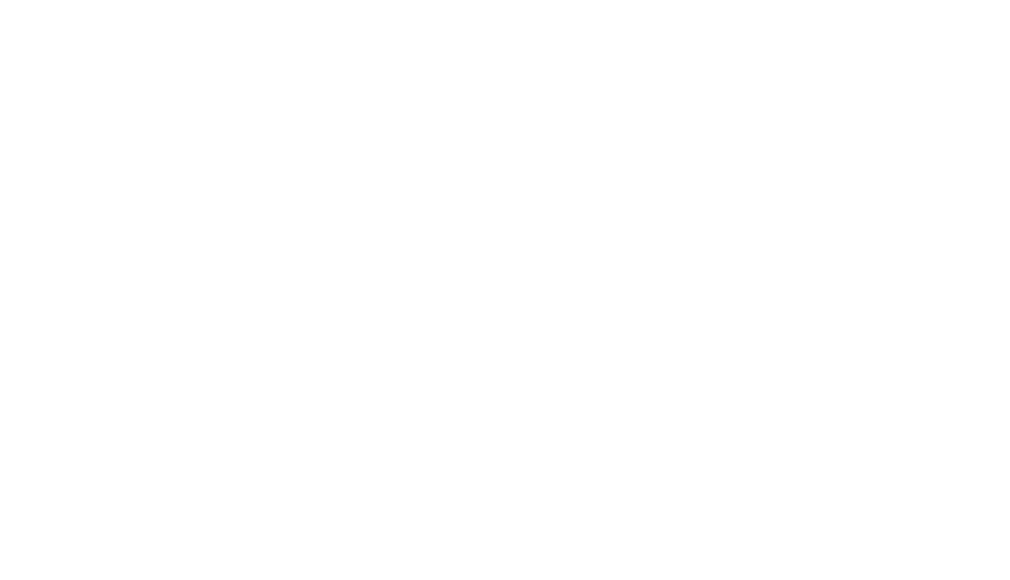

cleaning up lfp data
cleaning up speed data
found  0.0  outlier points
found  0.0  outlier points
(12206, 87, 6) (12206, 87, 8)
found  0.0  outlier points
(12206, 87, 14) (12206, 87, 3)
cleaning up lfp data
cleaning up speed data
found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points


100%|██████████| 16/16 [22:35<00:00, 95.70s/it]


<IPython.core.display.Javascript object>


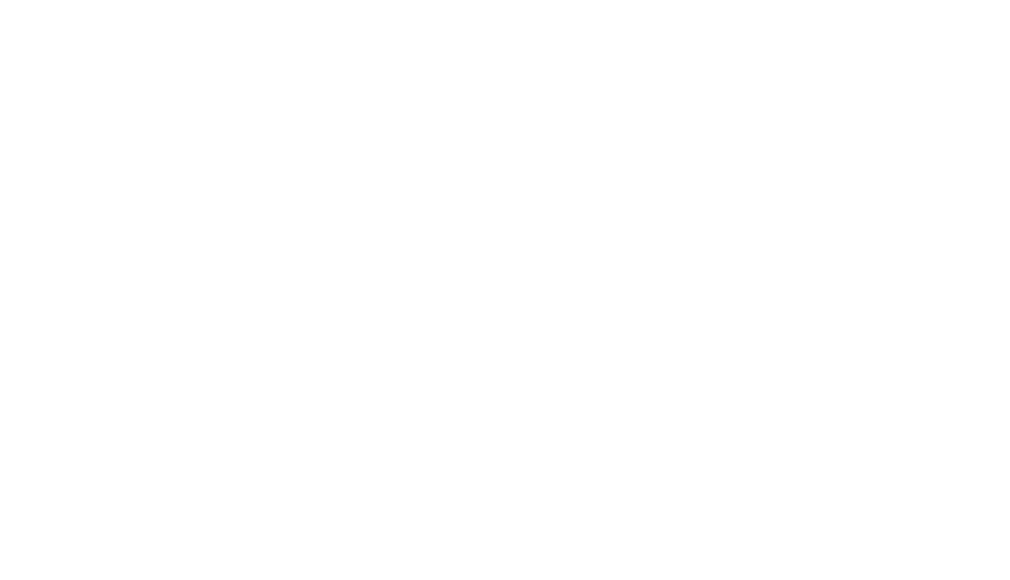

In [4]:
# align spectogram to mvmt onset -> for each mouse and in total:
f = h5py.File('Spectograms.hdf5','r')

# global presentation params and color params:
prs = Presentation()
prs.slide_width = Inches(11)
title_layout = prs.slide_layouts[5] 
title_slide_layout = prs.slide_layouts[0]
slide = prs.slides.add_slide(title_slide_layout)
slide.shapes.title.text = 'LFP aligned to mvmt onset'
lf = {'left':0.30, 'top':1.30, 'height':5.80, 'width':10.10}
fArgs = {'left':Inches(lf['left']),'top':Inches(lf['top']), 'height':Inches(lf['height']), 'width':Inches(lf['width'])}


miceList = getMiceList(Files[0])
for m in tqdm(miceList):
    fig, ax = plt.subplots(1,2,figsize=(lf['width'],lf['height']))
    
    data =  getData(Files[0],['lfp','speed'],period ='Pre', mice=m,day = lambda x: x==0)
    
    for sess in data:
        # get data
        dtS = 1/data[sess]['speed']['Fs']
        dtL = 1/data[sess]['lfp']['FS']
        ts = np.arange(0, np.max(data[sess]['speed']['speed'].shape)) * dtS 
        tl = np.arange(0, np.max(data[sess]['lfp']['lfp'].shape)) * dtL
        
        tPlot = np.linspace(-2,2,4/dtL)
        
        mvmtOnset = getOnsetOrPeriod(m,sess,'Pre','mvmtOnset')
        mvmtOnsetL = np.full_like(tl,False)
        for si in ts[mvmtOnset]:
            ti = np.argmin(np.abs(tl-si))
            mvmtOnsetL[ti] = True
        del mvmtOnset
    
#        freq = f[m][sess]['Pre']['freq'].value
        coeff = np.abs(f[m][sess]['Pre']['coeff'].value)
        
#        totP = np.sum(coeff,axis=1)
#        coeff = coeff.T/totP.T
#        coeff = coeff.T
        
        lfpOutliers = removeLFPOutliers(data[sess]['lfp']['lfp'], sess)
        coeff[:,(lfpOutliers[:,0]==1)] = np.nan
        coeff = coeff.T
        
        al = alignToOnset(coeff,(mvmtOnsetL==1), winPost =2/dtL, winPre = 2/dtL)
        
        if al.ndim <3:
            continue
        
        if 'aligned' in locals():
            print(aligned.shape,al.shape)
            aligned = np.concatenate((aligned,al), axis = 2)
        else:
            aligned = al
    
    freq = f[m]['freq'].value
    d = np.nanmean(aligned,axis=2)
    im = ax[0].pcolormesh(tPlot,freq,d.transpose())
    cbar=plt.colorbar(im,ax=ax[0])
    cbar.set_label(label='Power',size=16)
    ax[0].axvline(x=0.0,color='red',linestyle='dashed')
    ax[0].set_title('Healthy',fontsize=16)
    ax[0].set_ylabel('Frequency (Hz)',fontsize=16)
    ax[0].set_xlabel('Time (s)',fontsize=16)
    ax[0].tick_params(axis = 'y',labelsize=16)
    ax[0].tick_params(axis = 'x',labelsize=16)
    
    if 'Haligned' in locals():
        Haligned = np.concatenate((Haligned,aligned), axis = 2)
    else:
        Haligned = aligned
    
    del aligned
    
    data =  getData(Files[0],['lfp','speed'],period ='Pre', mice=m,day = lambda x: x>3)
    
    for sess in data:
        # get data
        dtS = 1/data[sess]['speed']['Fs']
        dtL = 1/data[sess]['lfp']['FS']
        ts = np.arange(0, np.max(data[sess]['speed']['speed'].shape)) * dtS 
        tl = np.arange(0, np.max(data[sess]['lfp']['lfp'].shape)) * dtL
        
        tPlot = np.linspace(-2,2,4/dtL)
        
        mvmtOnset = getOnsetOrPeriod(m,sess,'Pre','mvmtOnset')
        mvmtOnsetL = np.full_like(tl,False)
        for si in ts[mvmtOnset]:
            ti = np.argmin(np.abs(tl-si))
            mvmtOnsetL[ti] = True
        del mvmtOnset
    
#        freq = f[m]['freq'].value
        coeff = np.abs(f[m][sess]['Pre']['coeff'].value)
        
#        totP = np.sum(coeff,axis=1)
#        coeff = coeff.T/totP.T
#        coeff = coeff.T
        
        lfpOutliers = removeLFPOutliers(data[sess]['lfp']['lfp'], sess)
        coeff[:,(lfpOutliers[:,0]==1)] = np.nan
        
        coeff = coeff.T
        al = alignToOnset(coeff,(mvmtOnsetL==1), winPost =2/dtL, winPre = 2/dtL)
       
        if al.ndim <3:
            continue
            
        if 'aligned' in locals():
            aligned = np.concatenate((aligned,al), axis = 2)
        else:
            aligned = al
    if 'aligned' in locals():
        d = np.nanmean(aligned,axis=2)
        im = ax[1].pcolormesh(tPlot,freq,d.transpose())
        cbar=plt.colorbar(im,ax=ax[1])
        cbar.set_label(label='Power',size=16)
        ax[1].axvline(x=0.0,color='red',linestyle='dashed')
        ax[1].set_title('post 6OHDA',fontsize=16)
        ax[1].set_ylabel('Frequency (Hz)',fontsize=16)
        ax[1].set_xlabel('Time (s)',fontsize=16)
        ax[1].tick_params(axis = 'y',labelsize=16)
        ax[1].tick_params(axis = 'x',labelsize=16)
    
        if 'Saligned' in locals():
            Saligned = np.concatenate((Saligned,aligned), axis = 2)
        else:
            Saligned = aligned

        del aligned
    
    slide = prs.slides.add_slide(title_layout)
    slide.shapes.title.text = m 
    pic = plt2pptx(slide, fig, **fArgs)
    fig.clf()
    plt.close(fig)

    
fig, ax = plt.subplots(1,2,figsize=(lf['width'],lf['height']))    
    
d = np.nanmean(Haligned,axis=2)
im = ax[0].pcolormesh(tPlot,freq,d.transpose())
cbar=plt.colorbar(im,ax=ax[0])
cbar.set_label(label='Power',size=16)
ax[0].axvline(x=0.0,color='red',linestyle='dashed')
ax[0].set_title('Healthy',fontsize=16)
ax[0].set_ylabel('Frequency (Hz)',fontsize=16)
ax[0].set_xlabel('Time (s)',fontsize=16)
ax[0].tick_params(axis = 'y',labelsize=16)
ax[0].tick_params(axis = 'x',labelsize=16)

d = np.nanmean(Saligned,axis=2)
im = ax[1].pcolormesh(tPlot,freq,d.transpose())
cbar=plt.colorbar(im,ax=ax[1])
cbar.set_label(label='Power',size=16)
ax[1].axvline(x=0.0,color='red',linestyle='dashed')
ax[1].set_title('post 6OHDA',fontsize=16)
ax[1].set_ylabel('Frequency (Hz)',fontsize=16)
ax[1].set_xlabel('Time (s)',fontsize=16)
ax[1].tick_params(axis = 'y',labelsize=16)
ax[1].tick_params(axis = 'x',labelsize=16)

slide = prs.slides.add_slide(title_layout)
slide.shapes.title.text = 'all Mice' 
pic = plt2pptx(slide, fig, **fArgs)
fig.clf()
plt.close(fig)
    

        
prs.save('ppts/LFP_aligned2speed_onset.pptx')

  0%|          | 0/16 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


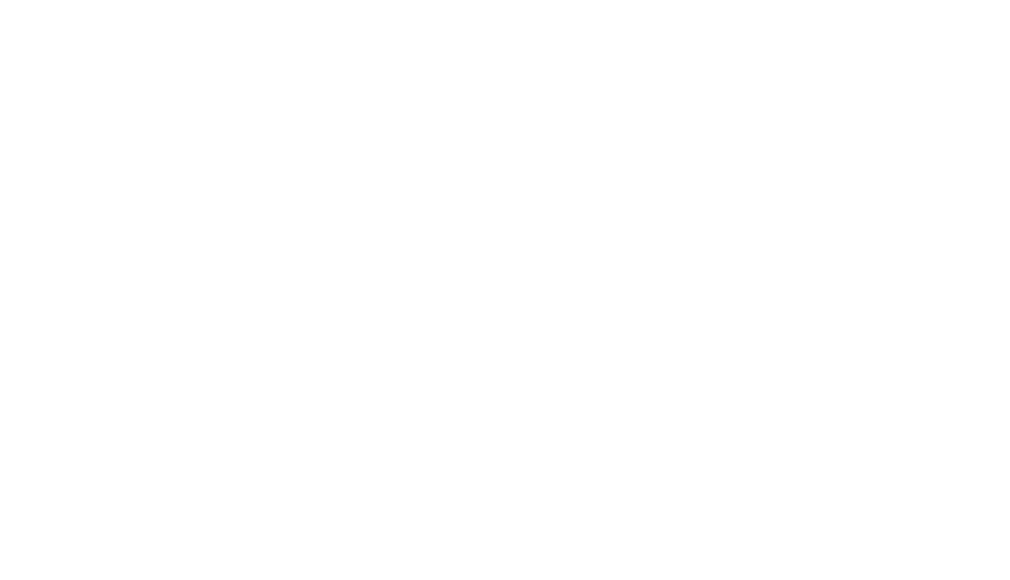

<IPython.core.display.Javascript object>


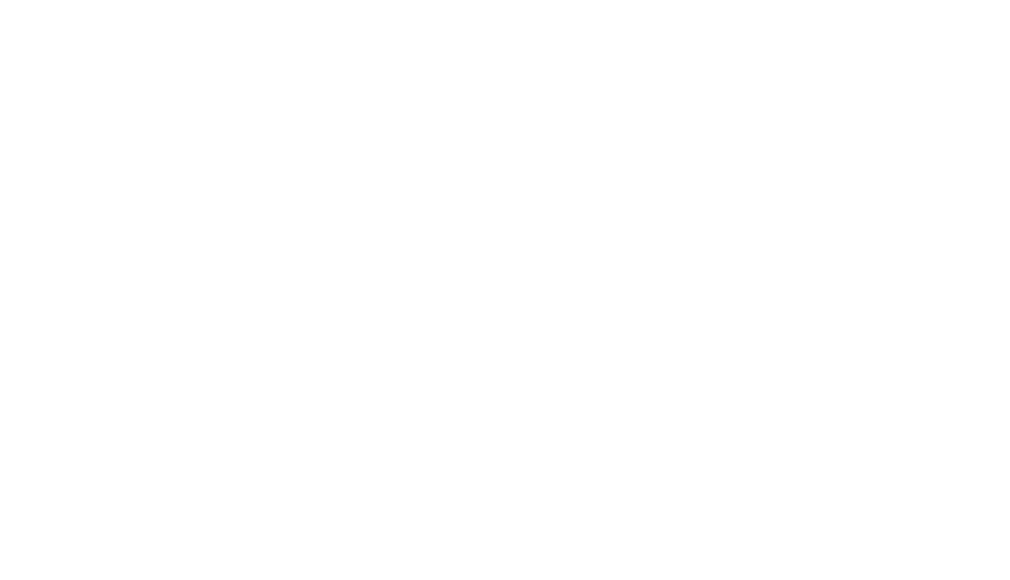

cleaning up lfp data
cleaning up speed data


/home/dana_z/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: DeprecationWarning: object of type <class 'numpy.ndarray'> cannot be safely interpreted as an integer.


found  0.0  outlier points
found  0.0  outlier points
(12206, 87, 14) (12206, 87, 15)
found  0.0  outlier points
(12206, 87, 29) (12206, 87, 8)
cleaning up lfp data
cleaning up speed data


/home/dana_z/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:100: DeprecationWarning: object of type <class 'numpy.ndarray'> cannot be safely interpreted as an integer.


found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points


  6%|▋         | 1/16 [01:17<19:17, 77.18s/it]

<IPython.core.display.Javascript object>


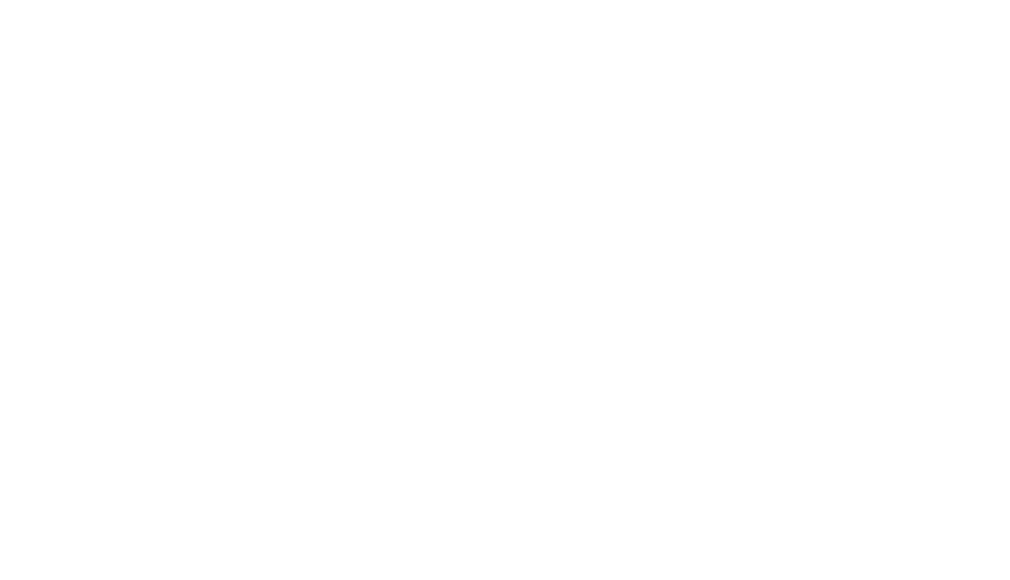

<IPython.core.display.Javascript object>


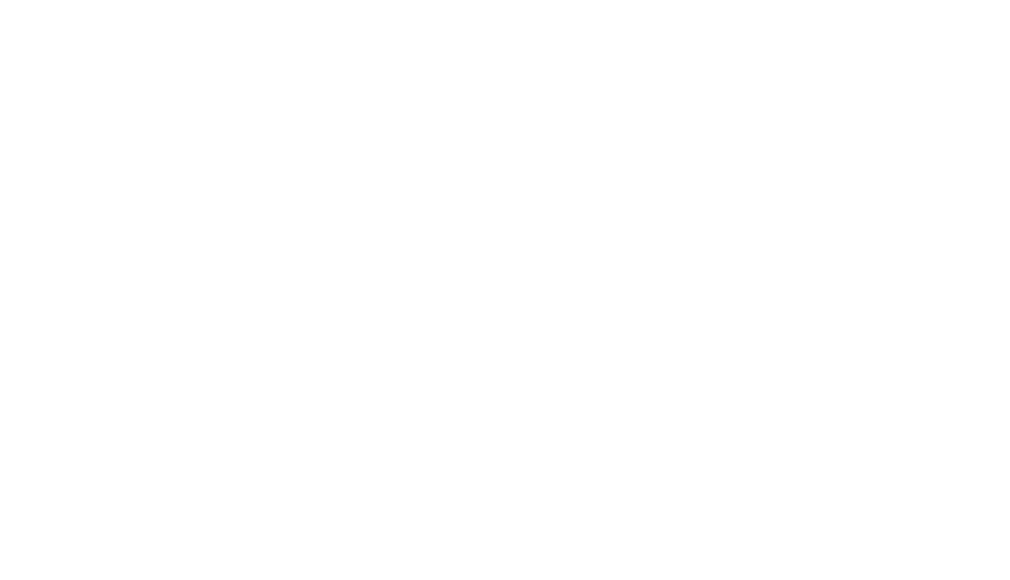

cleaning up lfp data
cleaning up speed data
found  0.0  outlier points
found  0.0  outlier points
(12206, 87, 8) (12206, 87, 14)
found  0.0  outlier points
(12206, 87, 22) (12206, 87, 14)
cleaning up lfp data
I deleted session: 1208_day12
cleaning up speed data
found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points
found  17.0  outlier points
found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points


 12%|█▎        | 2/16 [02:44<18:41, 80.10s/it]

<IPython.core.display.Javascript object>


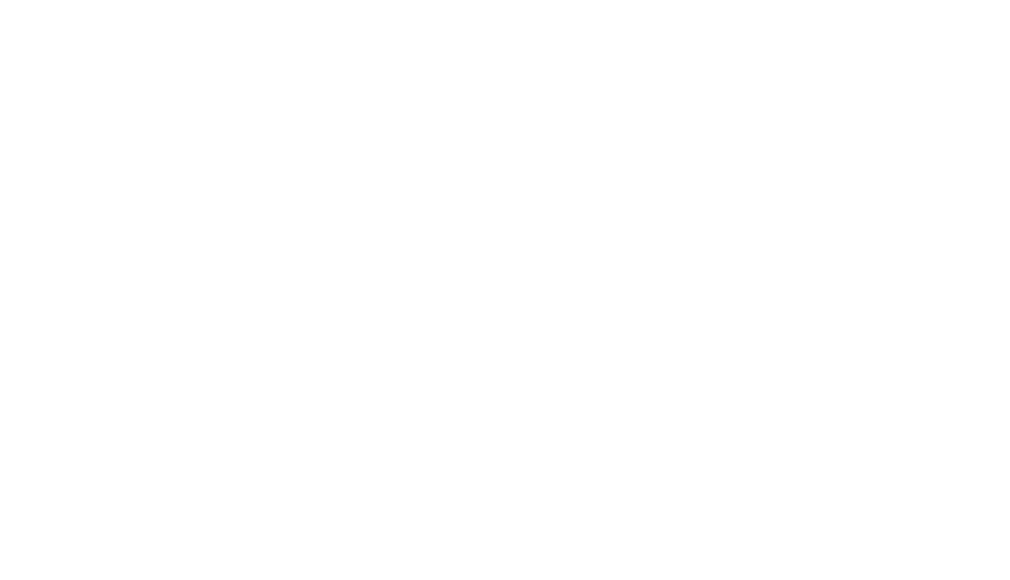

<IPython.core.display.Javascript object>


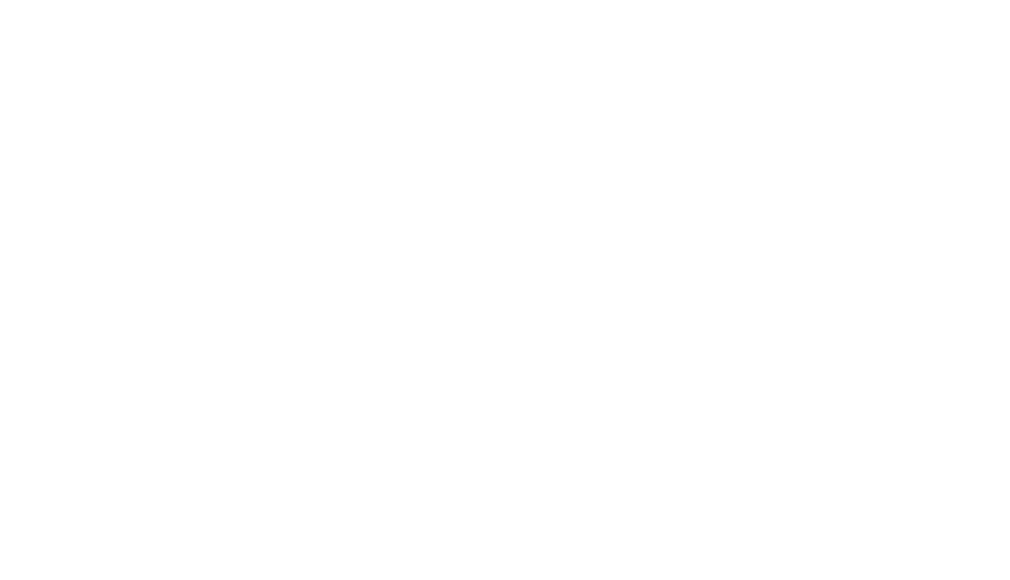

cleaning up lfp data
cleaning up speed data
found  0.0  outlier points
found  0.0  outlier points
(12206, 87, 10) (12206, 87, 17)
found  0.0  outlier points
(12206, 87, 27) (12206, 87, 7)
cleaning up lfp data
cleaning up speed data
found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points


 19%|█▉        | 3/16 [04:14<17:59, 83.05s/it]

<IPython.core.display.Javascript object>


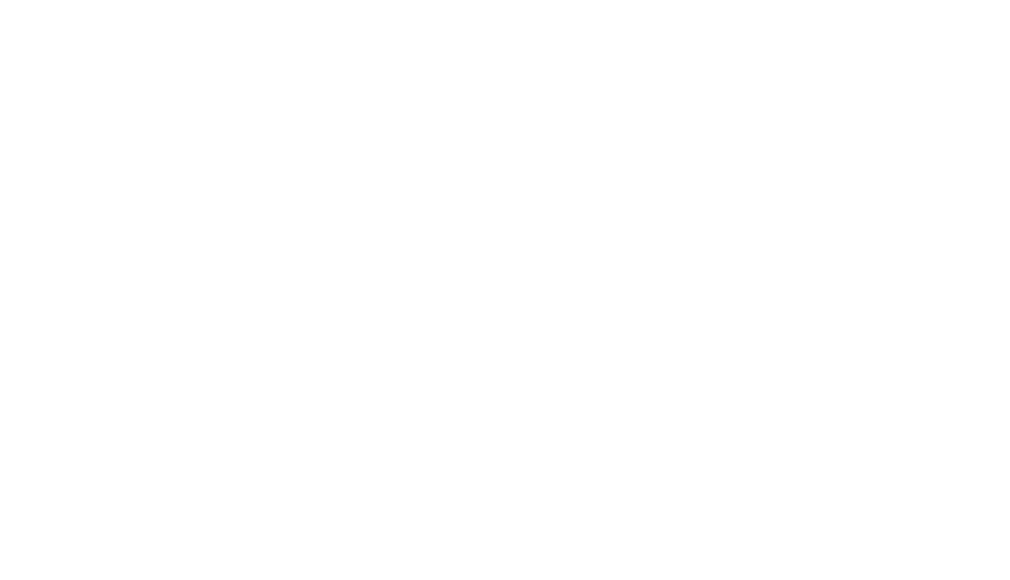

<IPython.core.display.Javascript object>


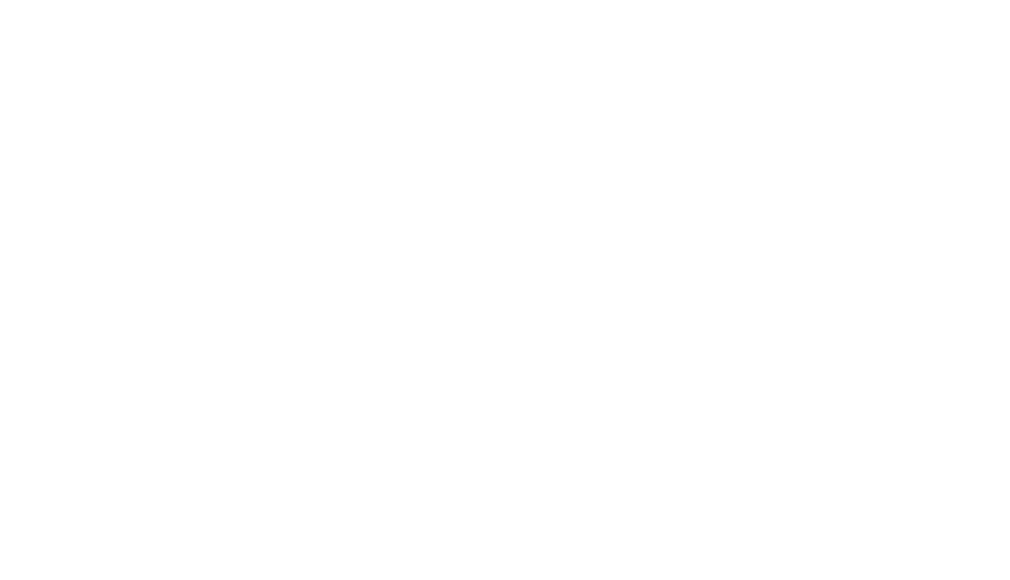

cleaning up lfp data
cleaning up speed data
found  0.0  outlier points
found  0.0  outlier points
(12206, 87, 14) (12206, 87, 14)
found  0.0  outlier points
(12206, 87, 28) (12206, 87, 6)
cleaning up lfp data
cleaning up speed data


 25%|██▌       | 4/16 [04:39<13:09, 65.81s/it]

<IPython.core.display.Javascript object>


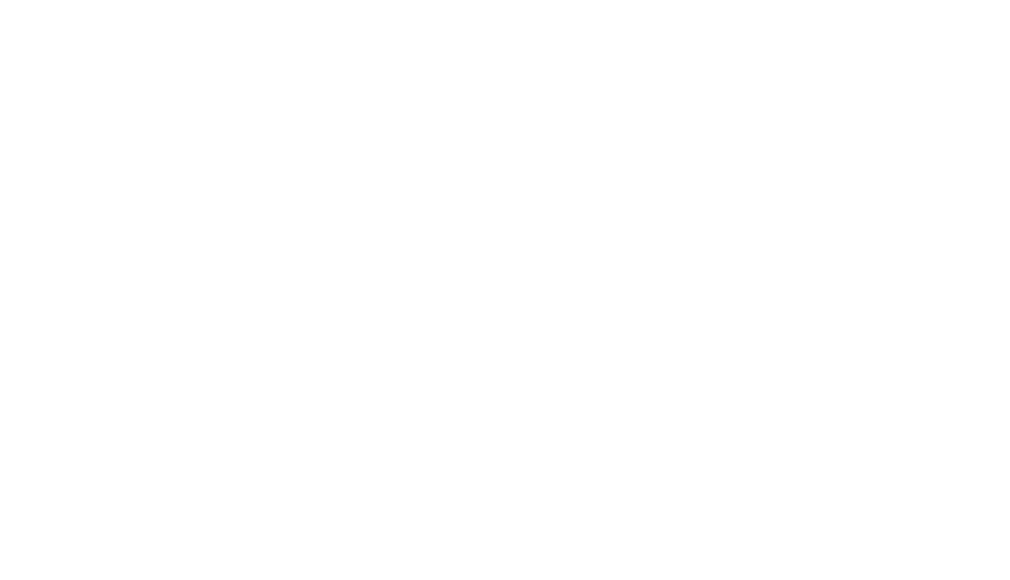

<IPython.core.display.Javascript object>


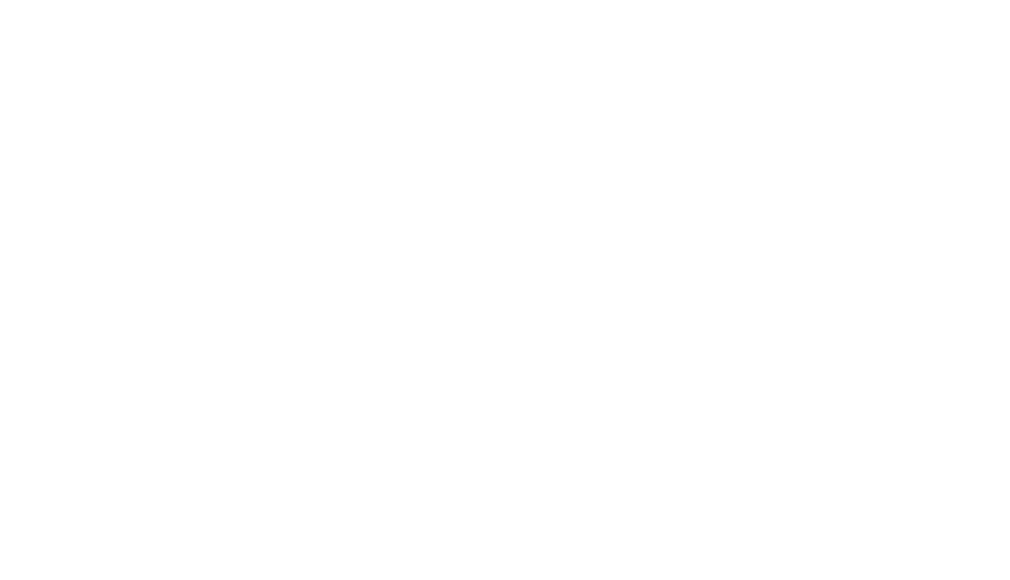

cleaning up lfp data
cleaning up speed data
found  1.0  outlier points
found  0.0  outlier points
(12206, 87, 14) (12206, 87, 30)
found  0.0  outlier points
(12206, 87, 44) (12206, 87, 19)
cleaning up lfp data
cleaning up speed data
found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points
found  888231.0  outlier points
found  481139.0  outlier points
found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points


 31%|███▏      | 5/16 [06:13<13:38, 74.38s/it]

<IPython.core.display.Javascript object>


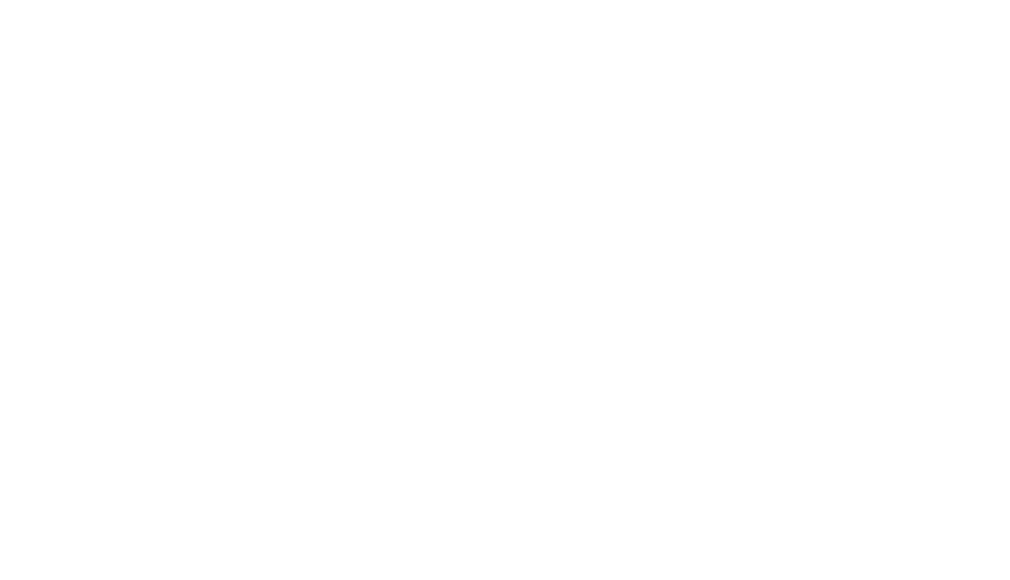

<IPython.core.display.Javascript object>


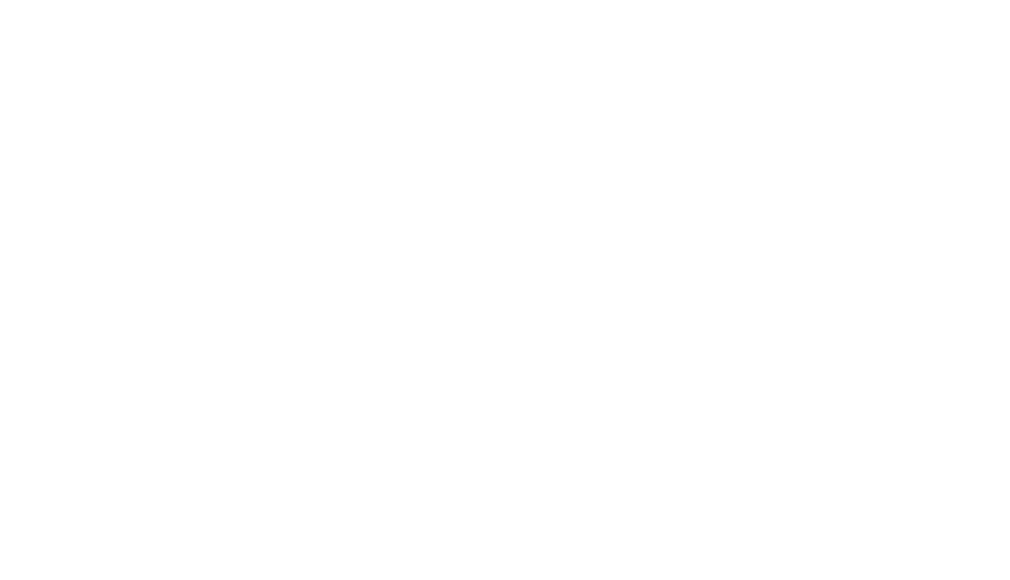

cleaning up lfp data
cleaning up speed data
found  0.0  outlier points
found  0.0  outlier points
(12206, 87, 6) (12206, 87, 6)
found  0.0  outlier points
(12206, 87, 12) (12206, 87, 8)
cleaning up lfp data
cleaning up speed data


 38%|███▊      | 6/16 [06:39<09:56, 59.64s/it]

<IPython.core.display.Javascript object>


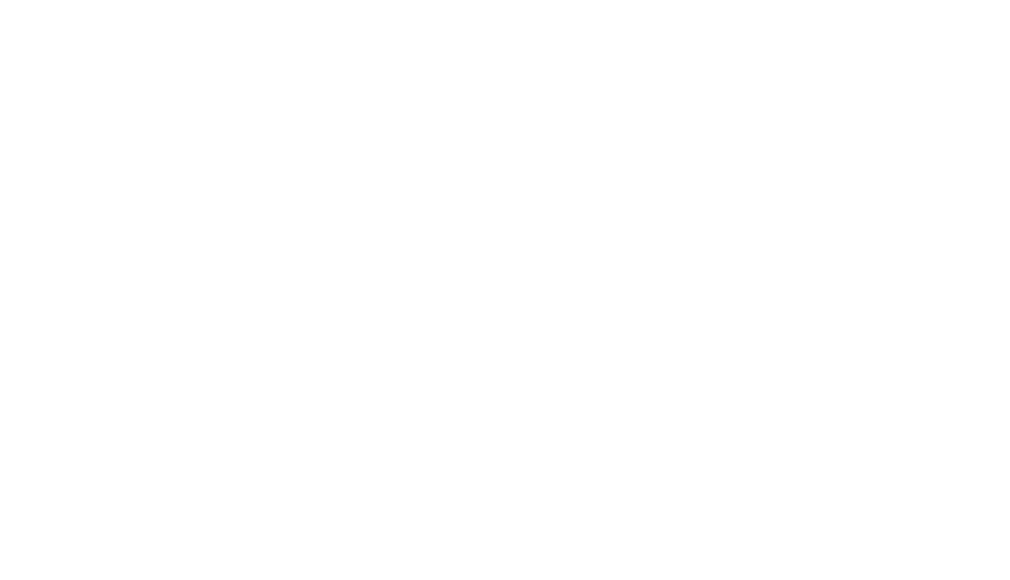

<IPython.core.display.Javascript object>


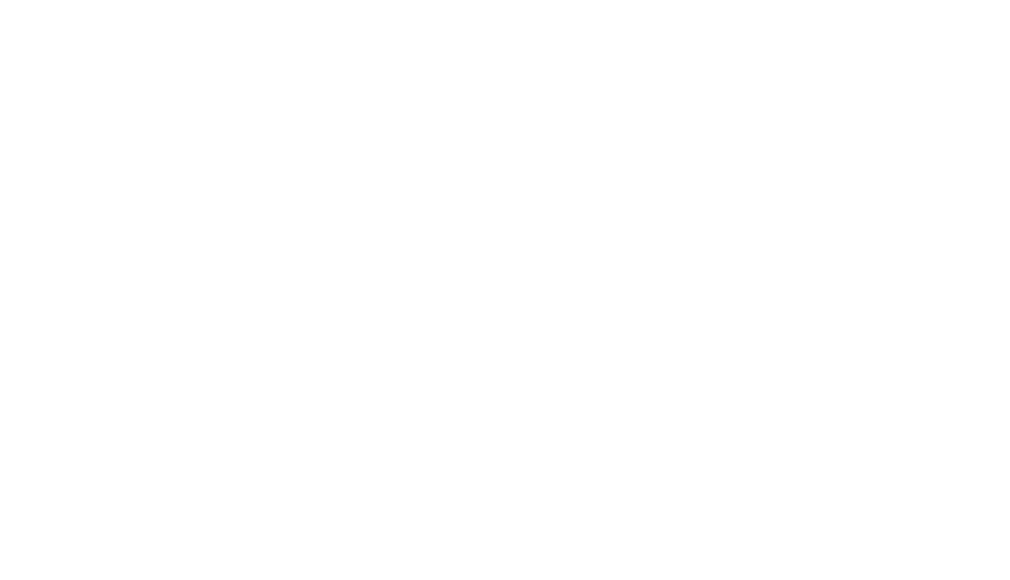

cleaning up lfp data
cleaning up speed data
found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points
(12206, 87, 21) (12206, 87, 17)
cleaning up lfp data
cleaning up speed data
found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points


 44%|████▍     | 7/16 [08:21<10:52, 72.53s/it]

<IPython.core.display.Javascript object>


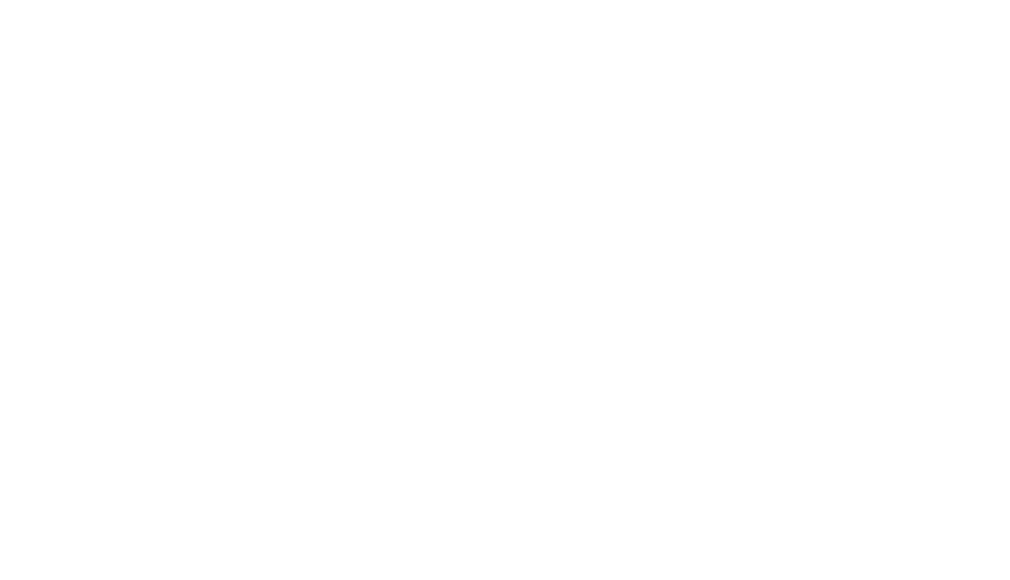

<IPython.core.display.Javascript object>


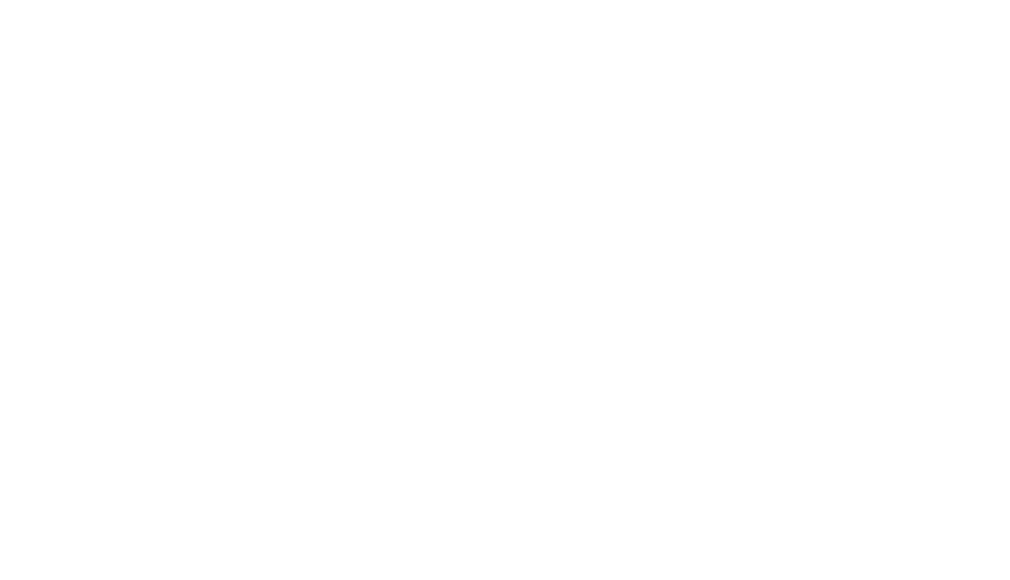

cleaning up lfp data
cleaning up speed data
found  1.0  outlier points
found  0.0  outlier points
(12206, 87, 6) (12206, 87, 6)
found  0.0  outlier points
(12206, 87, 12) (12206, 87, 17)
cleaning up lfp data
I deleted session: 2976_day4
cleaning up speed data
found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points
found  3.0  outlier points


 50%|█████     | 8/16 [09:53<10:26, 78.35s/it]

<IPython.core.display.Javascript object>


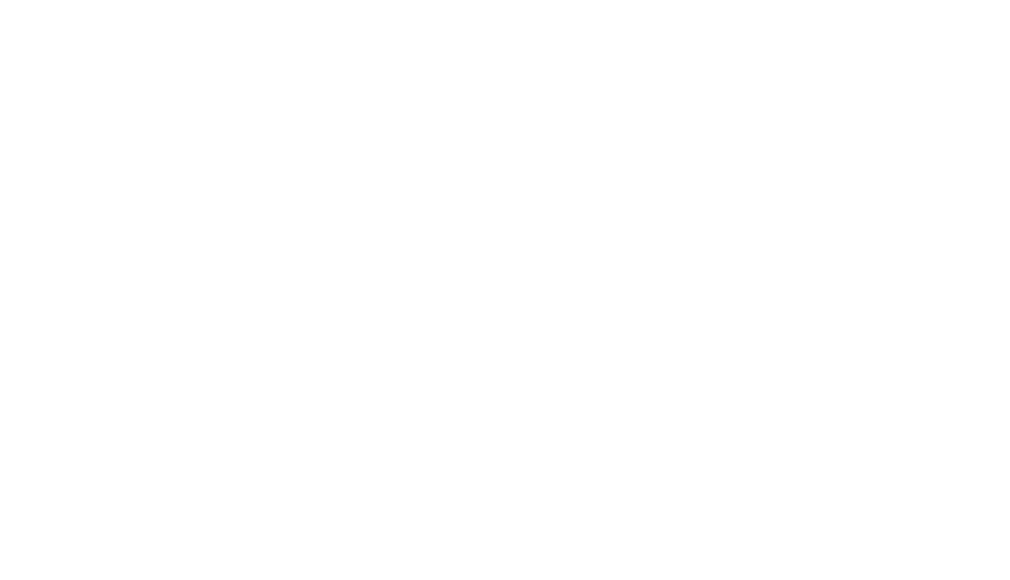

<IPython.core.display.Javascript object>


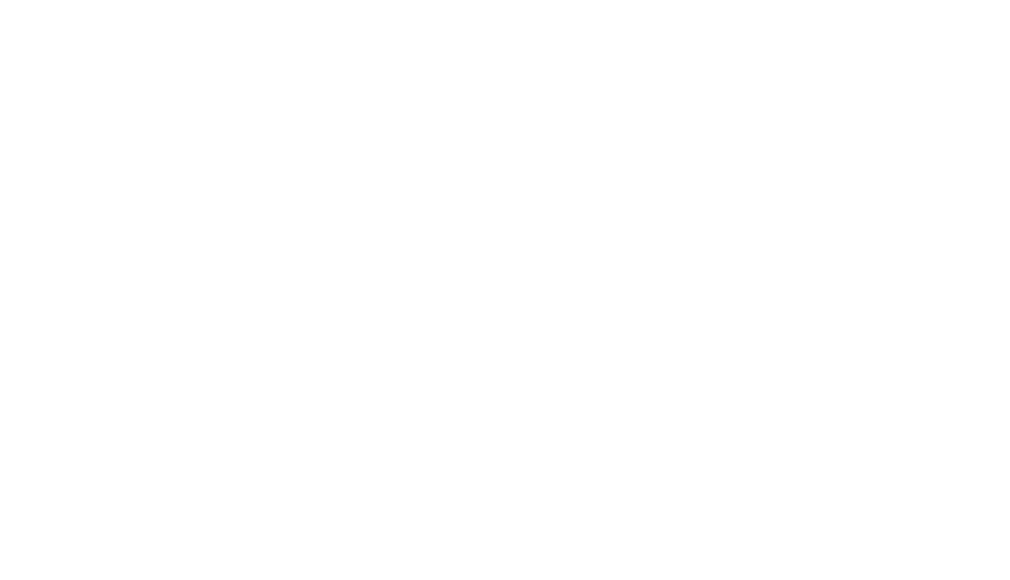

cleaning up lfp data
cleaning up speed data
found  0.0  outlier points
found  0.0  outlier points
(12206, 87, 8) (12206, 87, 21)
found  0.0  outlier points
(12206, 87, 29) (12206, 87, 4)
cleaning up lfp data
cleaning up speed data
found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points


 56%|█████▋    | 9/16 [11:34<09:54, 84.94s/it]

<IPython.core.display.Javascript object>


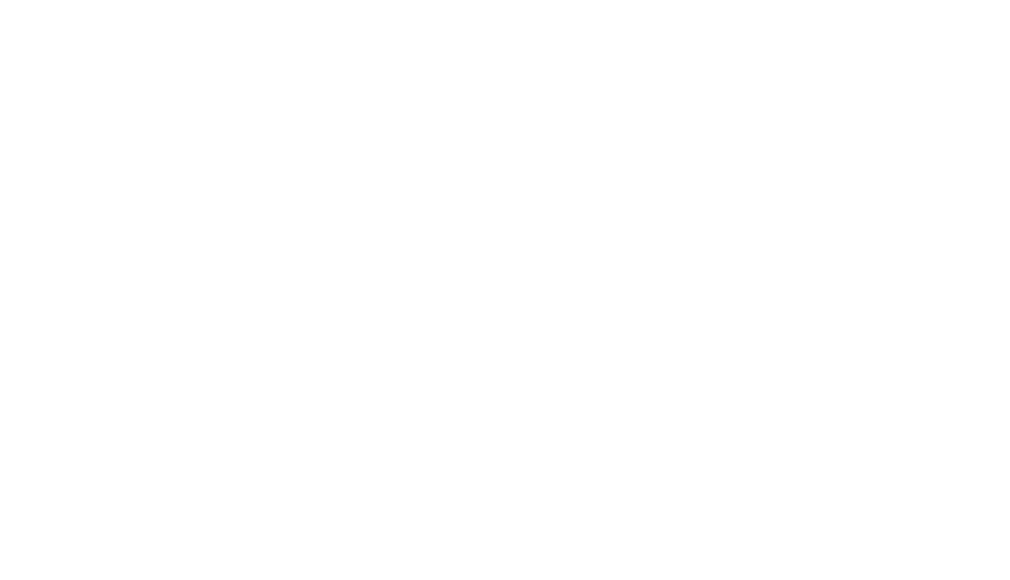

<IPython.core.display.Javascript object>


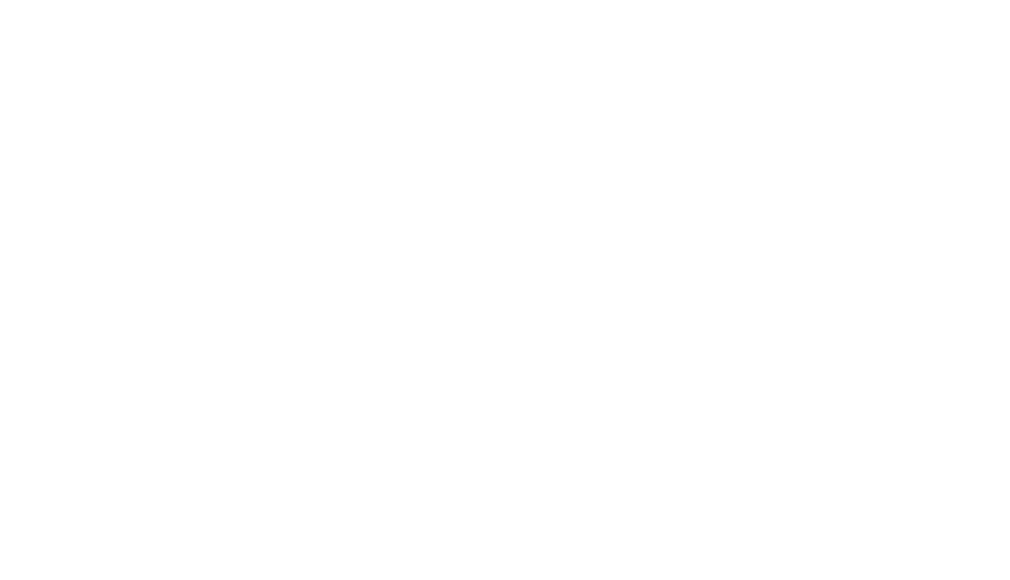

cleaning up lfp data
cleaning up speed data
found  0.0  outlier points
found  0.0  outlier points
(12206, 87, 23) (12206, 87, 23)
found  0.0  outlier points
(12206, 87, 46) (12206, 87, 12)
cleaning up lfp data
cleaning up speed data
found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points
found  50.0  outlier points
found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points


 62%|██████▎   | 10/16 [13:13<08:54, 89.16s/it]

<IPython.core.display.Javascript object>


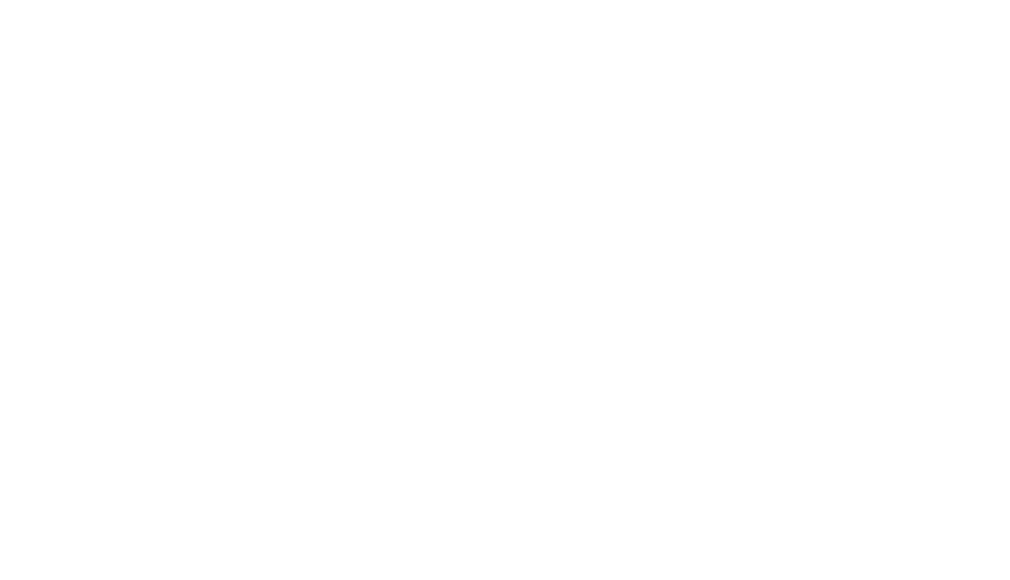

<IPython.core.display.Javascript object>


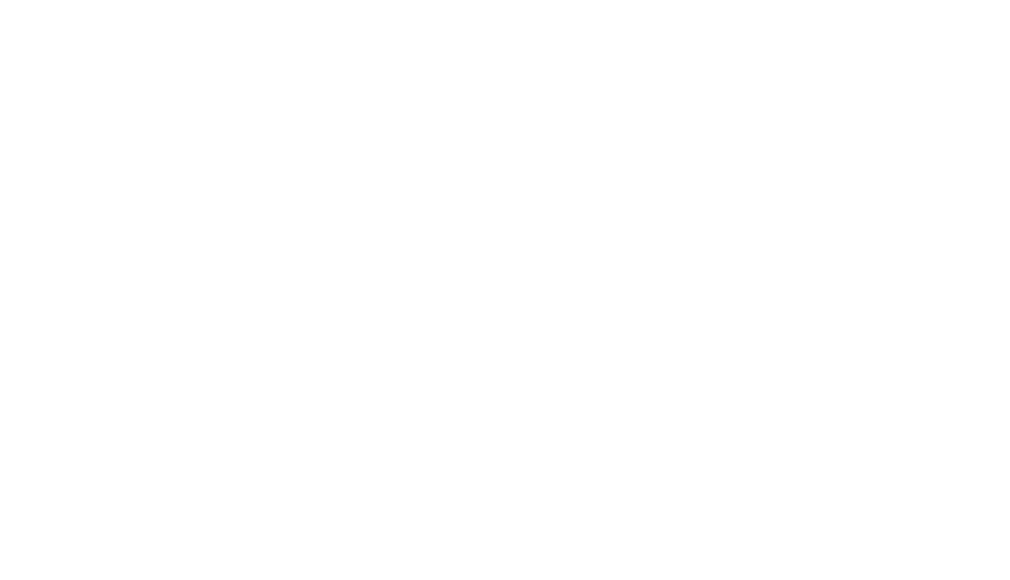

cleaning up lfp data
cleaning up speed data
found  0.0  outlier points
found  0.0  outlier points
(12206, 87, 4) (12206, 87, 2)
found  0.0  outlier points
(12206, 87, 6) (12206, 87, 9)
cleaning up lfp data
cleaning up speed data
found  29.0  outlier points
found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points


 69%|██████▉   | 11/16 [15:10<08:07, 97.57s/it]

<IPython.core.display.Javascript object>


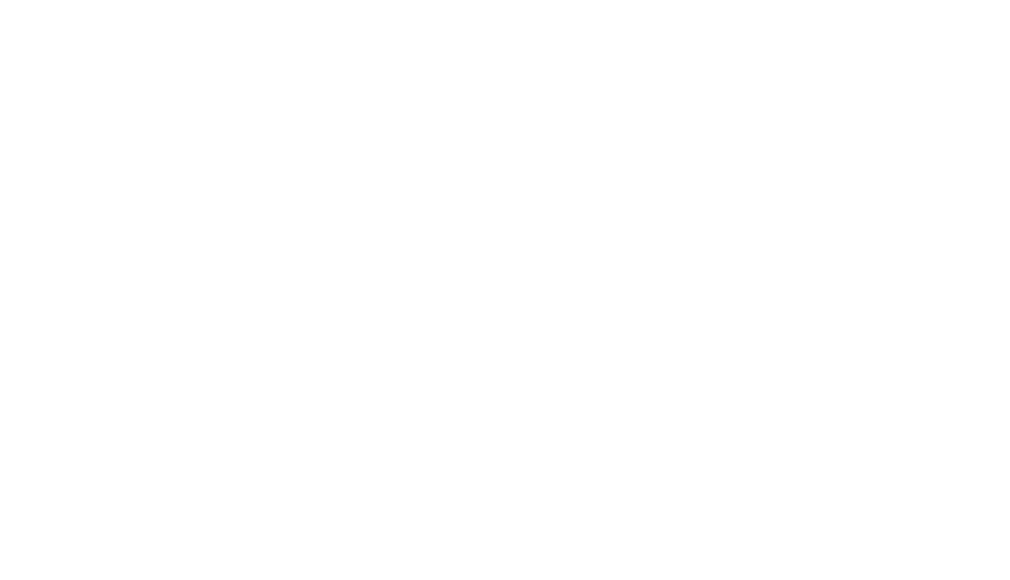

<IPython.core.display.Javascript object>


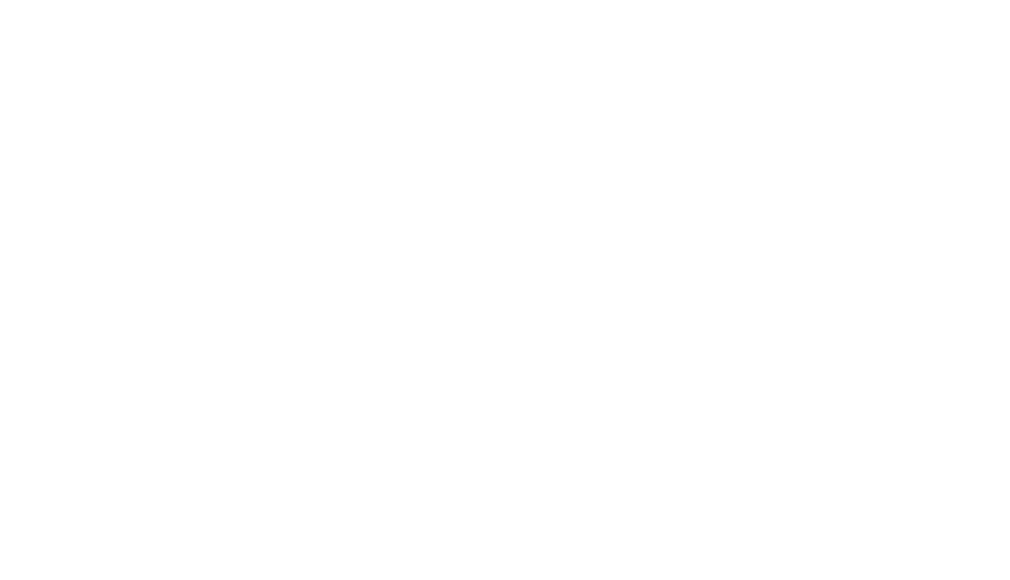

cleaning up lfp data
cleaning up speed data
found  0.0  outlier points
found  0.0  outlier points
(12206, 87, 5) (12206, 87, 7)
found  0.0  outlier points
(12206, 87, 12) (12206, 87, 9)
cleaning up lfp data
cleaning up speed data
found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points


 75%|███████▌  | 12/16 [16:57<06:42, 100.60s/it]

<IPython.core.display.Javascript object>


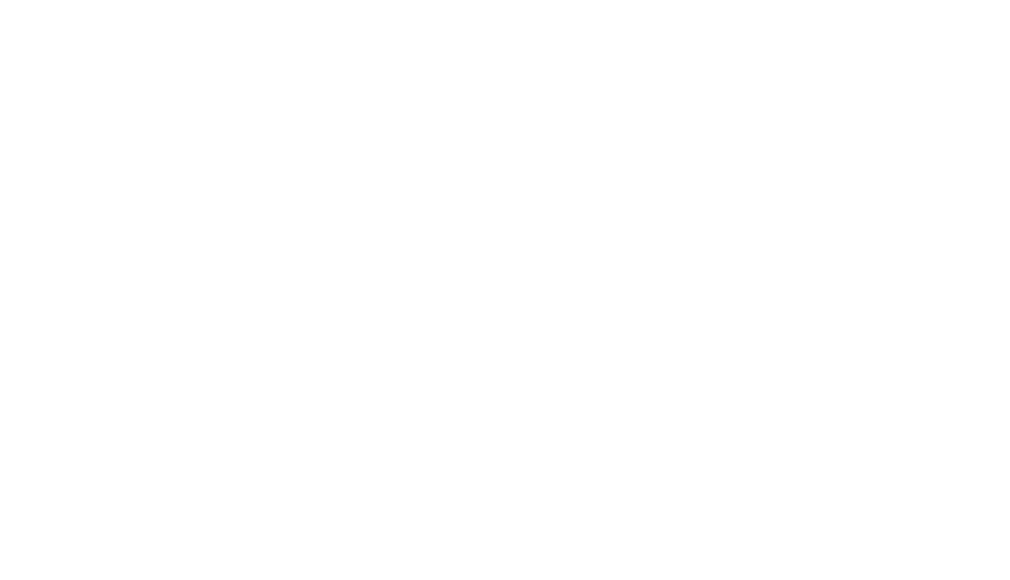

<IPython.core.display.Javascript object>


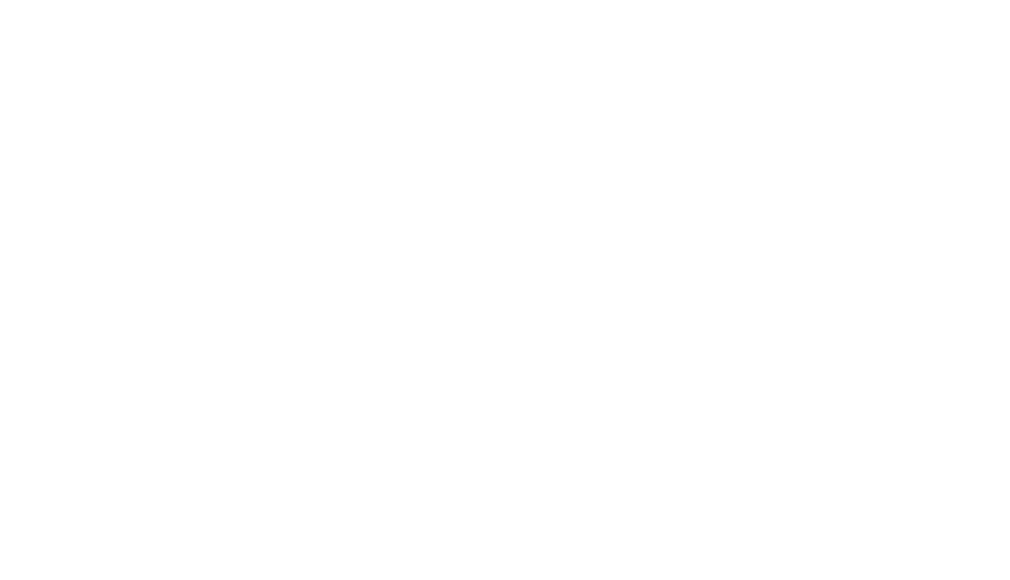

cleaning up lfp data
cleaning up speed data
found  0.0  outlier points
found  0.0  outlier points
(12206, 87, 25) (12206, 87, 20)
found  0.0  outlier points
(12206, 87, 45) (12206, 87, 15)
cleaning up lfp data
cleaning up speed data
found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points


 81%|████████▏ | 13/16 [18:57<05:19, 106.44s/it]

<IPython.core.display.Javascript object>


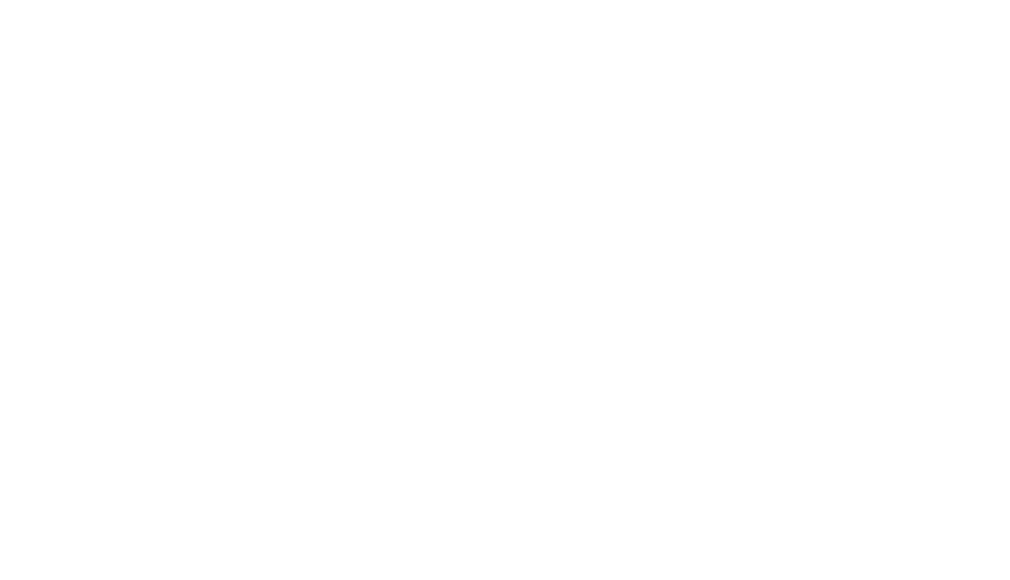

<IPython.core.display.Javascript object>


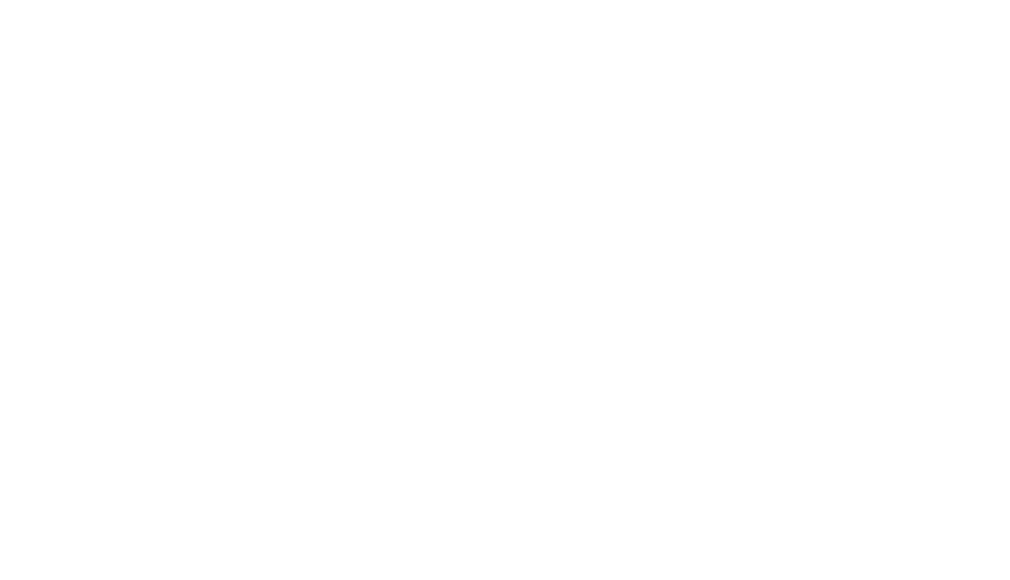

cleaning up lfp data
cleaning up speed data
found  0.0  outlier points
found  0.0  outlier points
(12206, 87, 0) (12206, 87, 4)
found  0.0  outlier points
(12206, 87, 4) (12206, 87, 2)
cleaning up lfp data
cleaning up speed data
found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points


 88%|████████▊ | 14/16 [20:23<03:20, 100.03s/it]

<IPython.core.display.Javascript object>


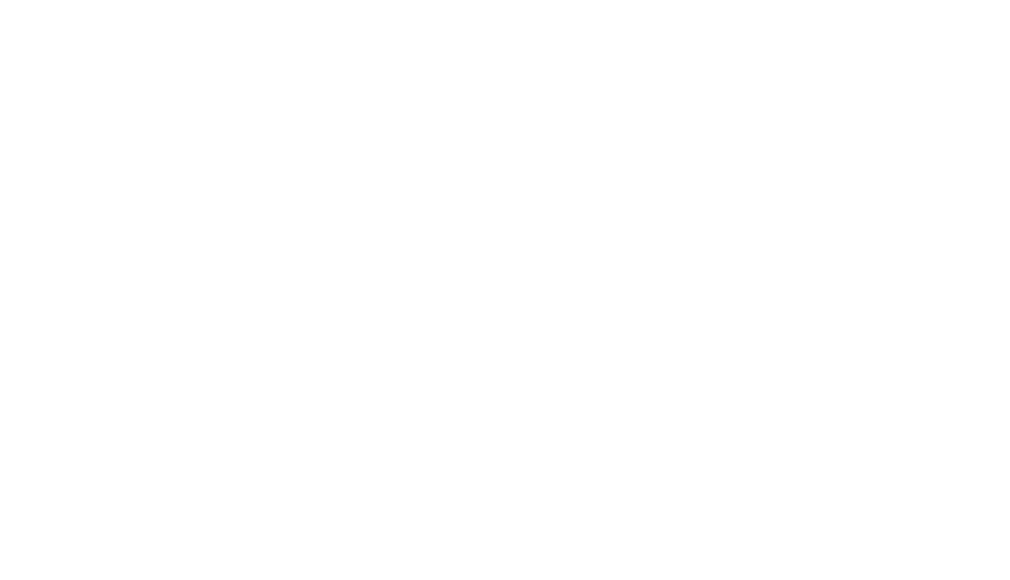

<IPython.core.display.Javascript object>


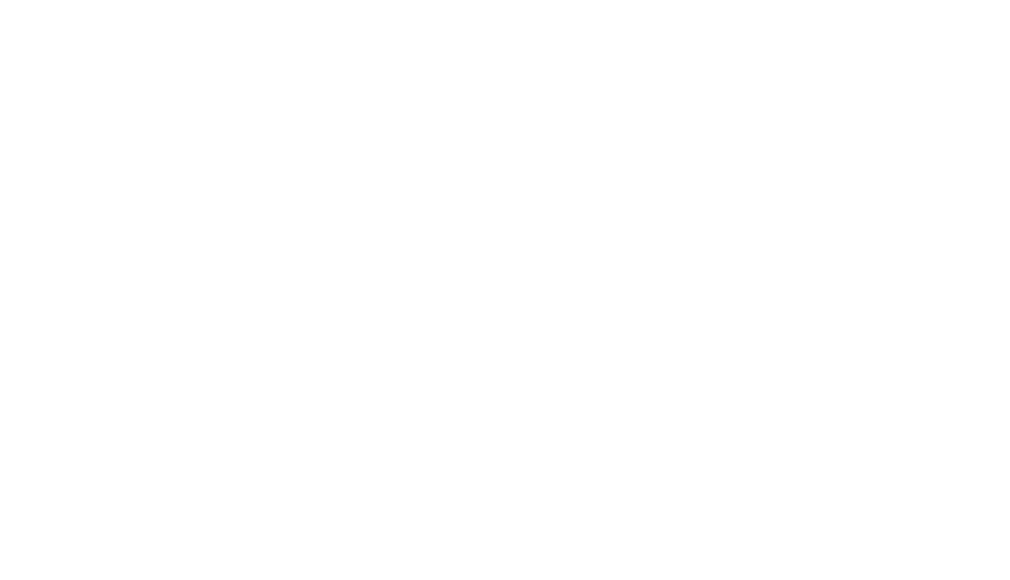

cleaning up lfp data
cleaning up speed data
found  0.0  outlier points
found  0.0  outlier points
(12206, 87, 6) (12206, 87, 29)
found  0.0  outlier points
(12206, 87, 35) (12206, 87, 39)
cleaning up lfp data
cleaning up speed data
found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points


 94%|█████████▍| 15/16 [22:04<01:40, 100.44s/it]

<IPython.core.display.Javascript object>


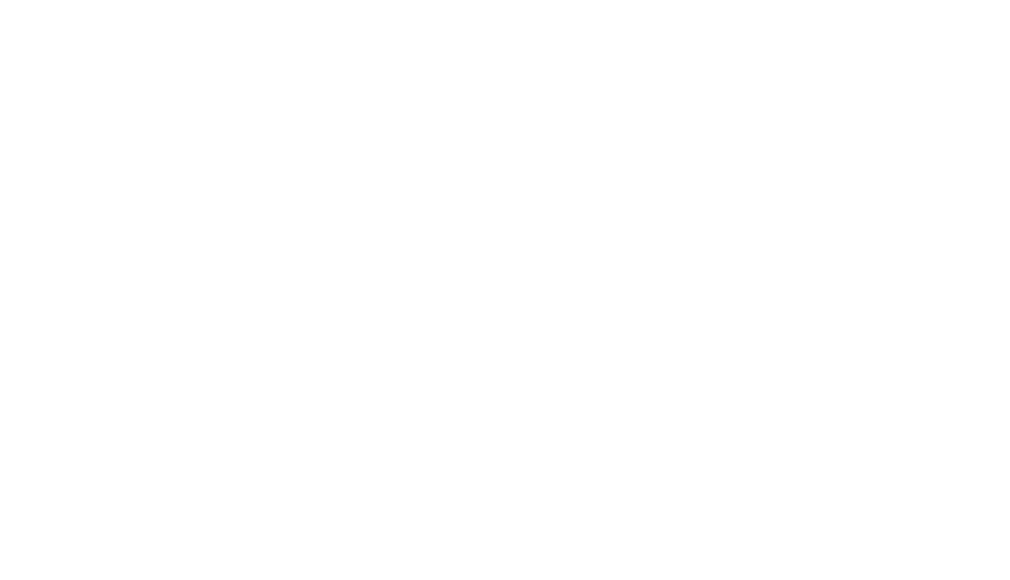

<IPython.core.display.Javascript object>


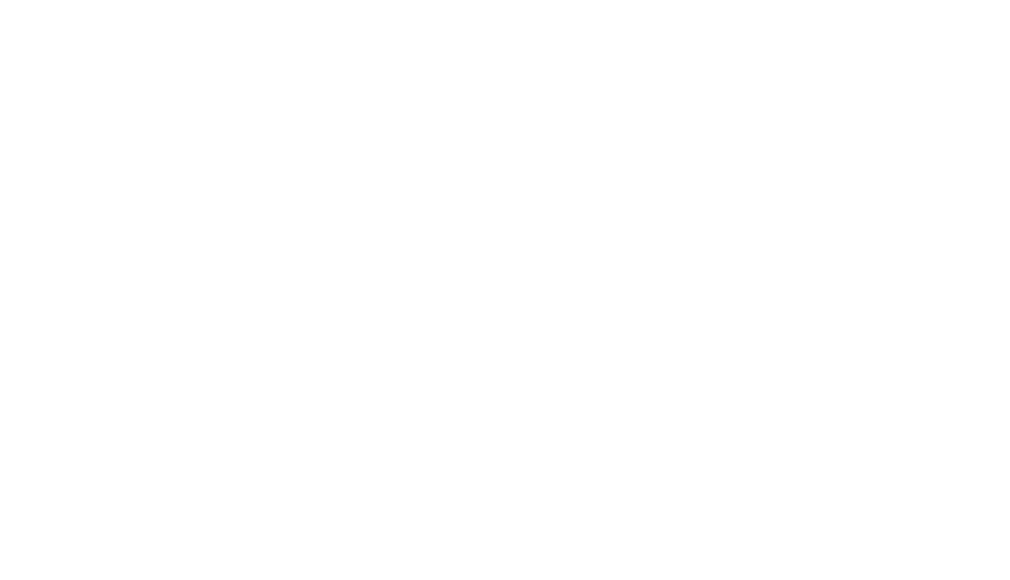

cleaning up lfp data
cleaning up speed data
found  0.0  outlier points
found  0.0  outlier points
(12206, 87, 6) (12206, 87, 8)
found  0.0  outlier points
(12206, 87, 14) (12206, 87, 3)
cleaning up lfp data
cleaning up speed data
found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points


100%|██████████| 16/16 [23:45<00:00, 100.52s/it]


<IPython.core.display.Javascript object>


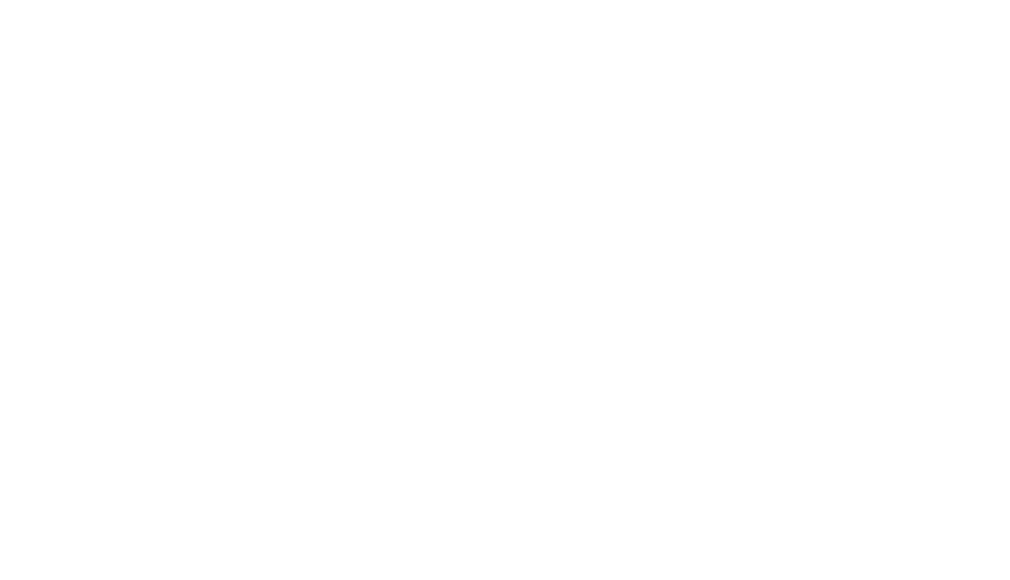

In [4]:
# align spectogram to mvmt onset -> for each mouse and in total:
f = h5py.File('Spectograms.hdf5','r')

# global presentation params and color params:
prs = Presentation()
prs.slide_width = Inches(11)
title_layout = prs.slide_layouts[5] 
title_slide_layout = prs.slide_layouts[0]
slide = prs.slides.add_slide(title_slide_layout)
slide.shapes.title.text = 'LFP aligned to mvmt onset'
lf = {'left':0.30, 'top':1.30, 'height':5.80, 'width':10.10}
fArgs = {'left':Inches(lf['left']),'top':Inches(lf['top']), 'height':Inches(lf['height']), 'width':Inches(lf['width'])}


miceList = getMiceList(Files[0])
for m in tqdm(miceList):
    fig, ax = plt.subplots(1,2,figsize=(lf['width'],lf['height']))
    fig3, ax3 = plt.subplots(1,2,figsize=(lf['width'],lf['height']))
    
    data =  getData(Files[0],['lfp','speed'],period ='Pre', mice=m,day = lambda x: x==0)
    
    for sess in data:
        # get data
        dtS = 1/data[sess]['speed']['Fs']
        dtL = 1/data[sess]['lfp']['FS']
        ts = np.arange(0, np.max(data[sess]['speed']['speed'].shape)) * dtS 
        tl = np.arange(0, np.max(data[sess]['lfp']['lfp'].shape)) * dtL
        
        tPlot = np.linspace(-2,2,4/dtL)
        
        mvmtOnset = getOnsetOrPeriod(m,sess,'Pre','mvmtOnset')
        mvmtOnsetL = np.full_like(tl,False)
        for si in ts[mvmtOnset]:
            ti = np.argmin(np.abs(tl-si))
            mvmtOnsetL[ti] = True
        del mvmtOnset
    
        freq = f[m]['freq'].value
        coeff = np.abs(f[m][sess]['Pre']['coeff'].value)
        
#        totP = np.sum(coeff,axis=1)
#        coeff = coeff.T/totP.T
#        coeff = coeff.T
        
        lfpOutliers = removeLFPOutliers(data[sess]['lfp']['lfp'], sess)
        coeff[:,(lfpOutliers[:,0]==1)] = np.nan
        coeff = coeff.T*freq
        
        al = alignToOnset(coeff,(mvmtOnsetL==1), winPost =2/dtL, winPre = 2/dtL)
        
        if al.ndim <3:
            continue
        
        if 'aligned' in locals():
            print(aligned.shape,al.shape)
            aligned = np.concatenate((aligned,al), axis = 2)
        else:
            aligned = al
    
    freq = f[m]['freq'].value
    d = np.nanmean(aligned,axis=2)
    im = ax[0].pcolormesh(tPlot,freq,d.transpose())
    cbar=plt.colorbar(im,ax=ax[0])
    cbar.set_label(label='Power',size=16)
    ax[0].axvline(x=0.0,color='red',linestyle='dashed')
    ax[0].set_title('Healthy',fontsize=16)
    ax[0].set_ylabel('Frequency (Hz)',fontsize=16)
    ax[0].set_xlabel('Time (s)',fontsize=16)
    ax[0].tick_params(axis = 'y',labelsize=16)
    ax[0].tick_params(axis = 'x',labelsize=16)
    
    
    d = d/np.mean(d[:int(d.shape[0]/2),:],axis=0)
    im2 = ax3[0].pcolormesh(tPlot,freq,d.transpose())
    cbar=plt.colorbar(im2,ax=ax3[0])
    cbar.set_label(label='Power',size=16)
    ax3[0].axvline(x=0.0,color='red',linestyle='dashed')
    ax3[0].set_title('Healthy',fontsize=16)
    ax3[0].set_ylabel('Frequency (Hz)',fontsize=16)
    ax3[0].set_xlabel('Time (s)',fontsize=16)
    ax3[0].tick_params(axis = 'y',labelsize=16)
    ax3[0].tick_params(axis = 'x',labelsize=16)
    
    if 'Haligned' in locals():
        Haligned = np.concatenate((Haligned,aligned), axis = 2)
    else:
        Haligned = aligned
    
    del aligned
    
    data =  getData(Files[0],['lfp','speed'],period ='Pre', mice=m,day = lambda x: x>3)
    
    for sess in data:
        # get data
        dtS = 1/data[sess]['speed']['Fs']
        dtL = 1/data[sess]['lfp']['FS']
        ts = np.arange(0, np.max(data[sess]['speed']['speed'].shape)) * dtS 
        tl = np.arange(0, np.max(data[sess]['lfp']['lfp'].shape)) * dtL
        
        tPlot = np.linspace(-2,2,4/dtL)
        
        mvmtOnset = getOnsetOrPeriod(m,sess,'Pre','mvmtOnset')
        mvmtOnsetL = np.full_like(tl,False)
        for si in ts[mvmtOnset]:
            ti = np.argmin(np.abs(tl-si))
            mvmtOnsetL[ti] = True
        del mvmtOnset
    
#        freq = f[m][sess]['Pre']['freq'].value
        coeff = np.abs(f[m][sess]['Pre']['coeff'].value)
        
#        totP = np.sum(coeff,axis=1)
#        coeff = coeff.T/totP.T
#        coeff = coeff.T
        
        lfpOutliers = removeLFPOutliers(data[sess]['lfp']['lfp'], sess)
        coeff[:,(lfpOutliers[:,0]==1)] = np.nan
        
        coeff = coeff.T*freq
        al = alignToOnset(coeff,(mvmtOnsetL==1), winPost =2/dtL, winPre = 2/dtL)
       
        if al.ndim <3:
            continue
            
        if 'aligned' in locals():
            aligned = np.concatenate((aligned,al), axis = 2)
        else:
            aligned = al
    if 'aligned' in locals():
        d = np.nanmean(aligned,axis=2)
        im = ax[1].pcolormesh(tPlot,freq,d.transpose())
        cbar=plt.colorbar(im,ax=ax[1])
        cbar.set_label(label='Power',size=16)
        ax[1].axvline(x=0.0,color='red',linestyle='dashed')
        ax[1].set_title('post 6OHDA',fontsize=16)
        ax[1].set_ylabel('Frequency (Hz)',fontsize=16)
        ax[1].set_xlabel('Time (s)',fontsize=16)
        ax[1].tick_params(axis = 'y',labelsize=16)
        ax[1].tick_params(axis = 'x',labelsize=16)
        
        d = d/np.mean(d[:int(d.shape[0]/2),:],axis=0)
        im3 = ax3[1].pcolormesh(tPlot,freq,d.transpose())
        cbar=plt.colorbar(im3,ax=ax3[1])
        cbar.set_label(label='Power',size=16)
        ax3[1].axvline(x=0.0,color='red',linestyle='dashed')
        ax3[1].set_title('post 6OHDA',fontsize=16)
        ax3[1].set_ylabel('Frequency (Hz)',fontsize=16)
        ax3[1].set_xlabel('Time (s)',fontsize=16)
        ax3[1].tick_params(axis = 'y',labelsize=16)
        ax3[1].tick_params(axis = 'x',labelsize=16)
    
        if 'Saligned' in locals():
            Saligned = np.concatenate((Saligned,aligned), axis = 2)
        else:
            Saligned = aligned

        del aligned
    
    slide = prs.slides.add_slide(title_layout)
    slide.shapes.title.text = m 
    pic = plt2pptx(slide, fig, **fArgs)
    fig.clf()
    plt.close(fig)
    
    slide = prs.slides.add_slide(title_layout)
    slide.shapes.title.text = m 
    pic = plt2pptx(slide, fig3, **fArgs)
    fig3.clf()
    plt.close(fig3)


    
fig, ax = plt.subplots(1,2,figsize=(lf['width'],lf['height']))    
    
d = np.nanmean(Haligned,axis=2)
im = ax[0].pcolormesh(tPlot,freq,d.transpose())
cbar=plt.colorbar(im,ax=ax[0])
cbar.set_label(label='Power',size=16)
ax[0].axvline(x=0.0,color='red',linestyle='dashed')
ax[0].set_title('Healthy',fontsize=16)
ax[0].set_ylabel('Frequency (Hz)',fontsize=16)
ax[0].set_xlabel('Time (s)',fontsize=16)
ax[0].tick_params(axis = 'y',labelsize=16)
ax[0].tick_params(axis = 'x',labelsize=16)

d = np.nanmean(Saligned,axis=2)
im = ax[1].pcolormesh(tPlot,freq,d.transpose())
cbar=plt.colorbar(im,ax=ax[1])
cbar.set_label(label='Power',size=16)
ax[1].axvline(x=0.0,color='red',linestyle='dashed')
ax[1].set_title('post 6OHDA',fontsize=16)
ax[1].set_ylabel('Frequency (Hz)',fontsize=16)
ax[1].set_xlabel('Time (s)',fontsize=16)
ax[1].tick_params(axis = 'y',labelsize=16)
ax[1].tick_params(axis = 'x',labelsize=16)

slide = prs.slides.add_slide(title_layout)
slide.shapes.title.text = 'all Mice' 
pic = plt2pptx(slide, fig, **fArgs)
fig.clf()
plt.close(fig)
    

        
prs.save('ppts/LFP_aligned2speed_onset2.pptx')

  0%|          | 0/16 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


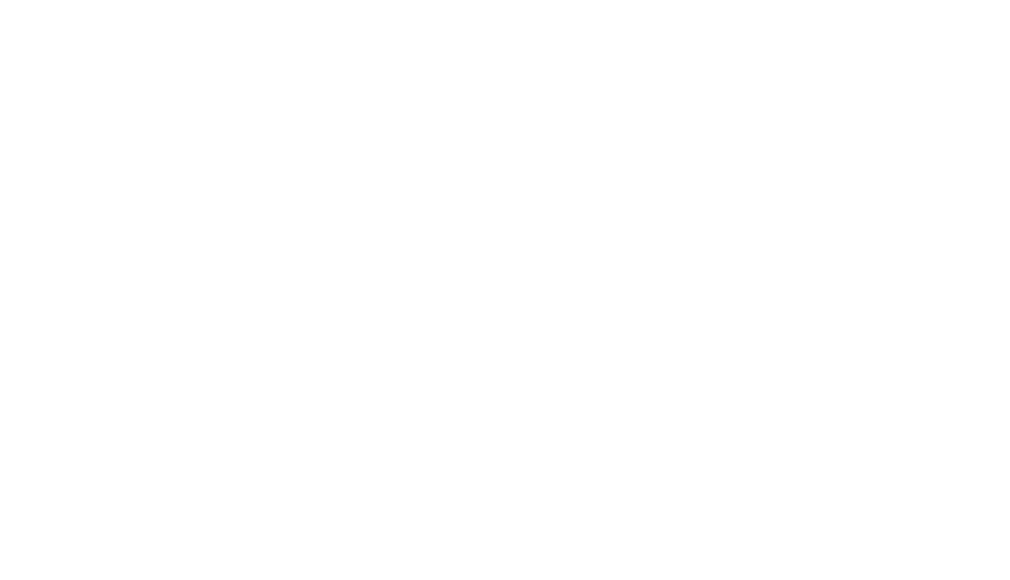

cleaning up lfp data
cleaning up speed data


/home/dana_z/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: DeprecationWarning: object of type <class 'numpy.ndarray'> cannot be safely interpreted as an integer.
/home/dana_z/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: DeprecationWarning: object of type <class 'numpy.ndarray'> cannot be safely interpreted as an integer.


found  0.0  outlier points
found  0.0  outlier points
(12206, 87, 14) (12206, 87, 15)
found  0.0  outlier points
(12206, 87, 29) (12206, 87, 8)
cleaning up lfp data
cleaning up speed data


/home/dana_z/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:112: DeprecationWarning: object of type <class 'numpy.ndarray'> cannot be safely interpreted as an integer.


found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points


  6%|▋         | 1/16 [01:07<16:50, 67.34s/it]

<IPython.core.display.Javascript object>


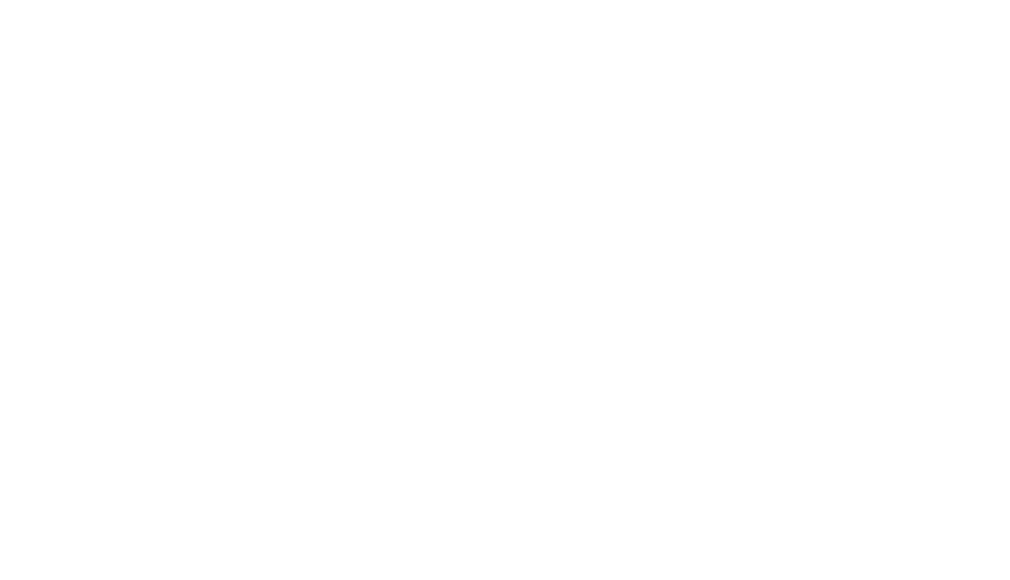

cleaning up lfp data
cleaning up speed data
found  0.0  outlier points
found  0.0  outlier points
(12206, 87, 8) (12206, 87, 14)
found  0.0  outlier points
(12206, 87, 22) (12206, 87, 14)
cleaning up lfp data
I deleted session: 1208_day12
cleaning up speed data
found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points
found  17.0  outlier points
found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points


 12%|█▎        | 2/16 [02:29<16:44, 71.74s/it]

<IPython.core.display.Javascript object>


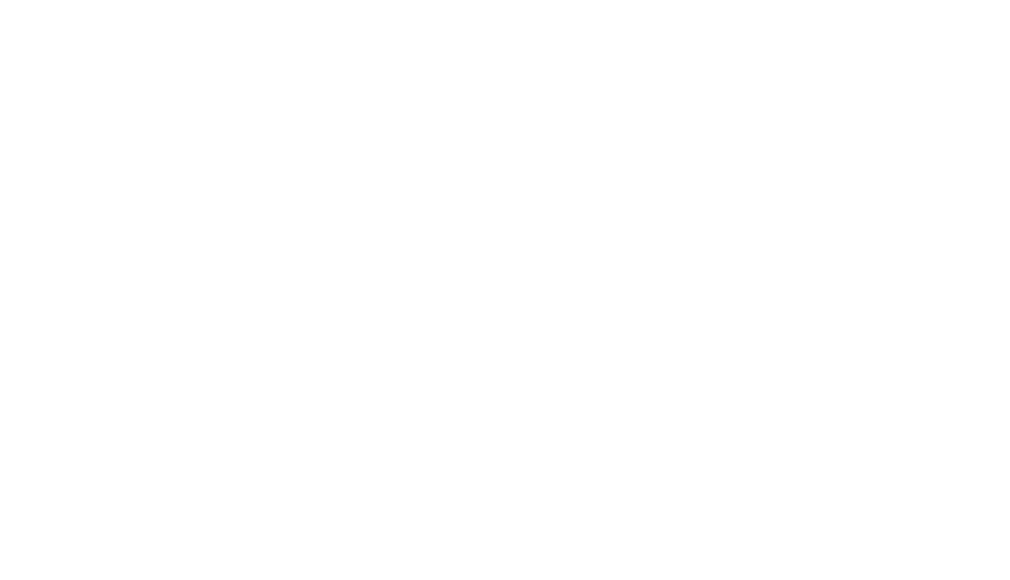

cleaning up lfp data
cleaning up speed data
found  0.0  outlier points
found  0.0  outlier points
(12206, 87, 10) (12206, 87, 17)
found  0.0  outlier points
(12206, 87, 27) (12206, 87, 7)
cleaning up lfp data
cleaning up speed data
found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points


 19%|█▉        | 3/16 [03:53<16:19, 75.38s/it]

<IPython.core.display.Javascript object>


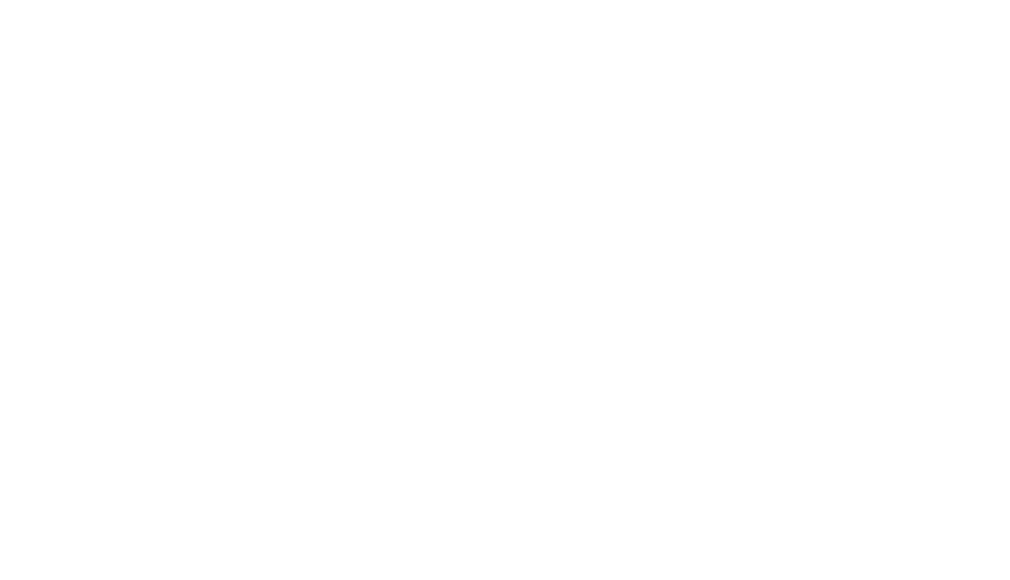

cleaning up lfp data
cleaning up speed data
found  0.0  outlier points
found  0.0  outlier points
(12206, 87, 14) (12206, 87, 14)
found  0.0  outlier points
(12206, 87, 28) (12206, 87, 6)
cleaning up lfp data
cleaning up speed data


 25%|██▌       | 4/16 [04:15<11:54, 59.54s/it]

<IPython.core.display.Javascript object>


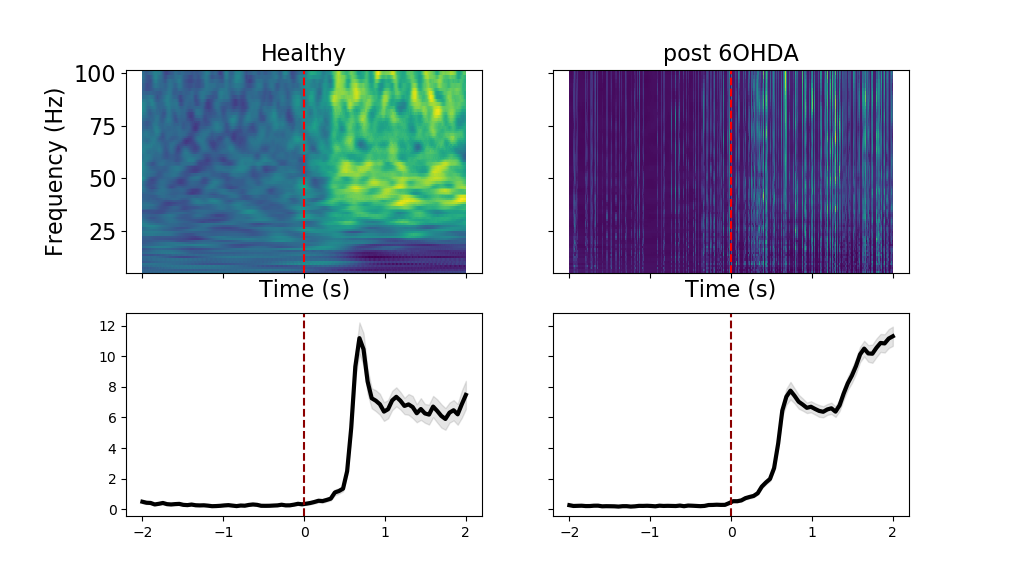

cleaning up lfp data
cleaning up speed data
found  1.0  outlier points
found  0.0  outlier points
(12206, 87, 14) (12206, 87, 30)
found  0.0  outlier points
(12206, 87, 44) (12206, 87, 19)
cleaning up lfp data
cleaning up speed data
found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points
found  888231.0  outlier points
found  481139.0  outlier points
found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points


 31%|███▏      | 5/16 [05:41<12:20, 67.28s/it]

<IPython.core.display.Javascript object>


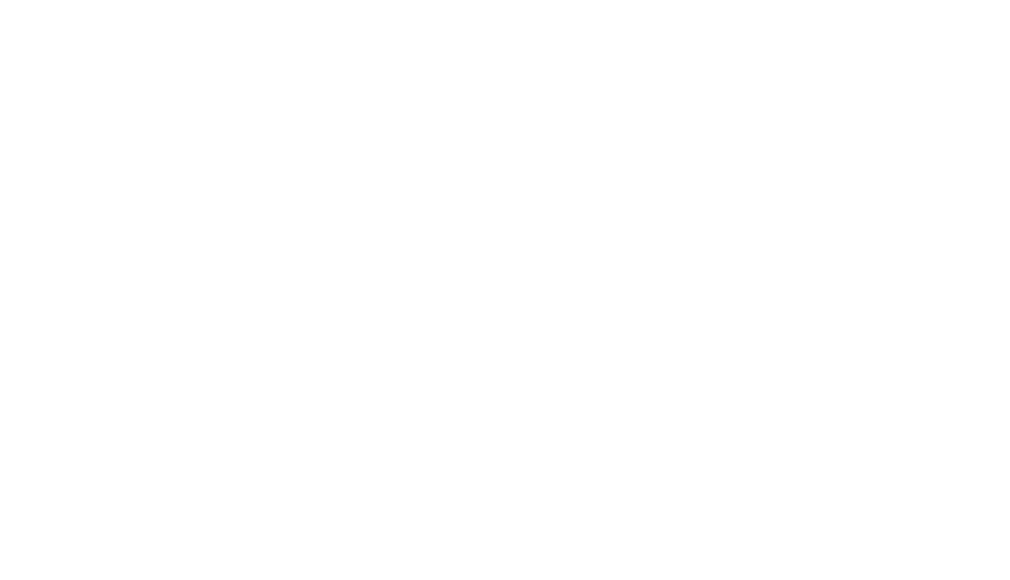

cleaning up lfp data
cleaning up speed data
found  0.0  outlier points
found  0.0  outlier points
(12206, 87, 6) (12206, 87, 6)
found  0.0  outlier points
(12206, 87, 12) (12206, 87, 8)
cleaning up lfp data
cleaning up speed data


 38%|███▊      | 6/16 [06:03<08:58, 53.80s/it]

<IPython.core.display.Javascript object>


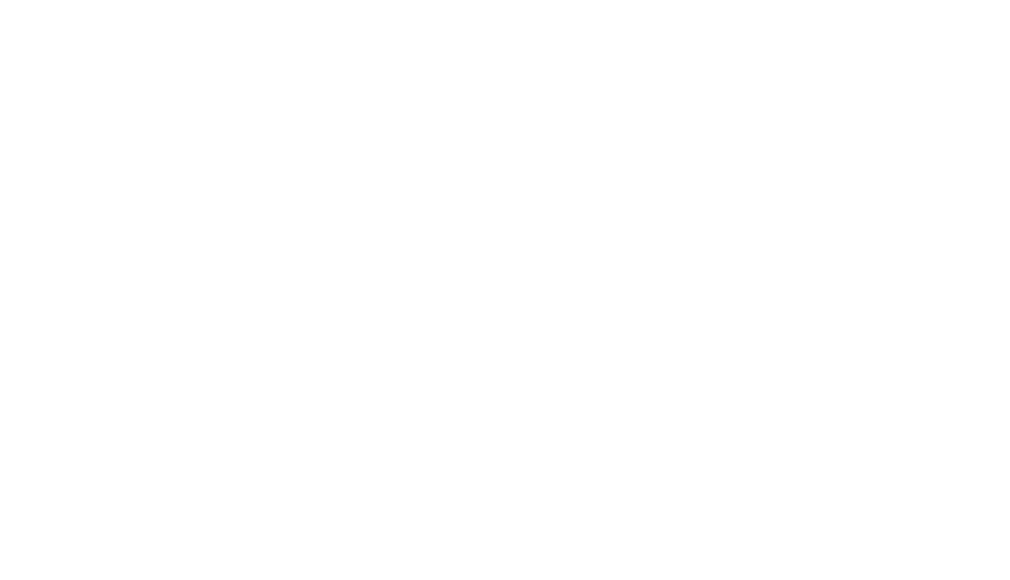

cleaning up lfp data
cleaning up speed data
found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points
(12206, 87, 21) (12206, 87, 17)
cleaning up lfp data
cleaning up speed data
found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points


 44%|████▍     | 7/16 [07:39<09:58, 66.51s/it]

<IPython.core.display.Javascript object>


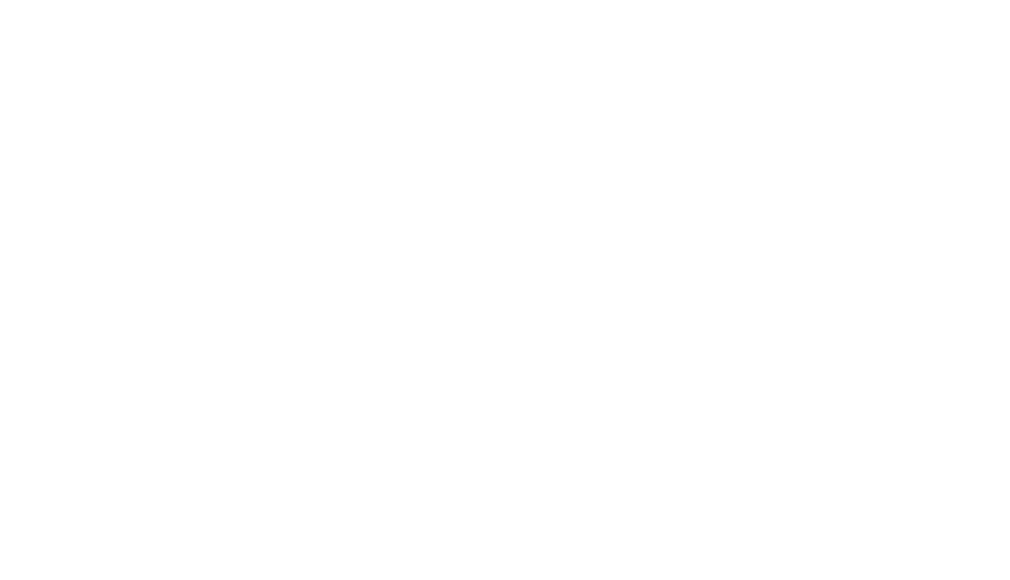

cleaning up lfp data
cleaning up speed data
found  1.0  outlier points
found  0.0  outlier points
(12206, 87, 6) (12206, 87, 6)
found  0.0  outlier points
(12206, 87, 12) (12206, 87, 17)
cleaning up lfp data
I deleted session: 2976_day4
cleaning up speed data
found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points
found  3.0  outlier points


 50%|█████     | 8/16 [09:05<09:38, 72.33s/it]

<IPython.core.display.Javascript object>


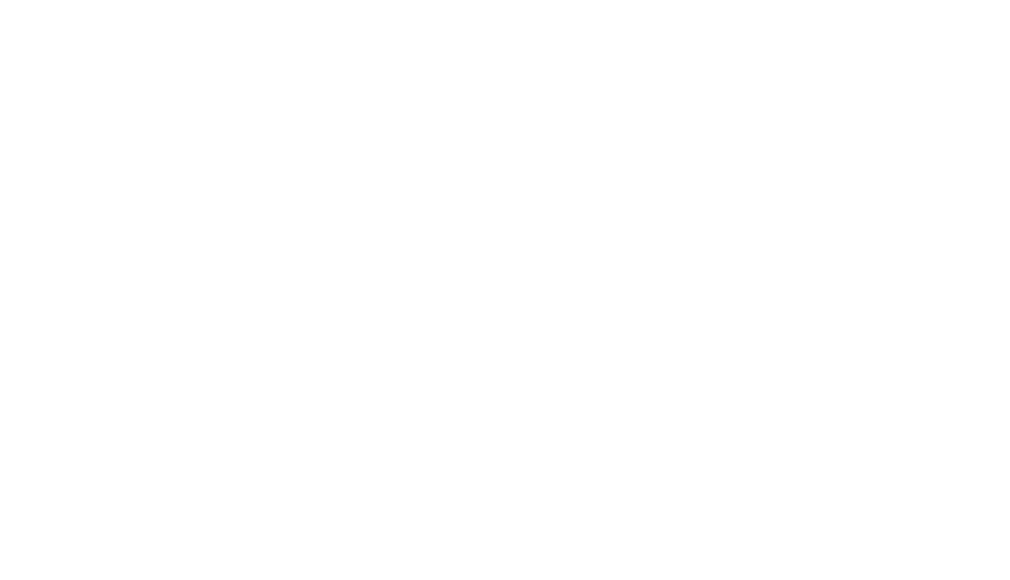

cleaning up lfp data
cleaning up speed data
found  0.0  outlier points
found  0.0  outlier points
(12206, 87, 8) (12206, 87, 21)
found  0.0  outlier points
(12206, 87, 29) (12206, 87, 4)
cleaning up lfp data
cleaning up speed data
found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points


 56%|█████▋    | 9/16 [10:39<09:11, 78.77s/it]

<IPython.core.display.Javascript object>


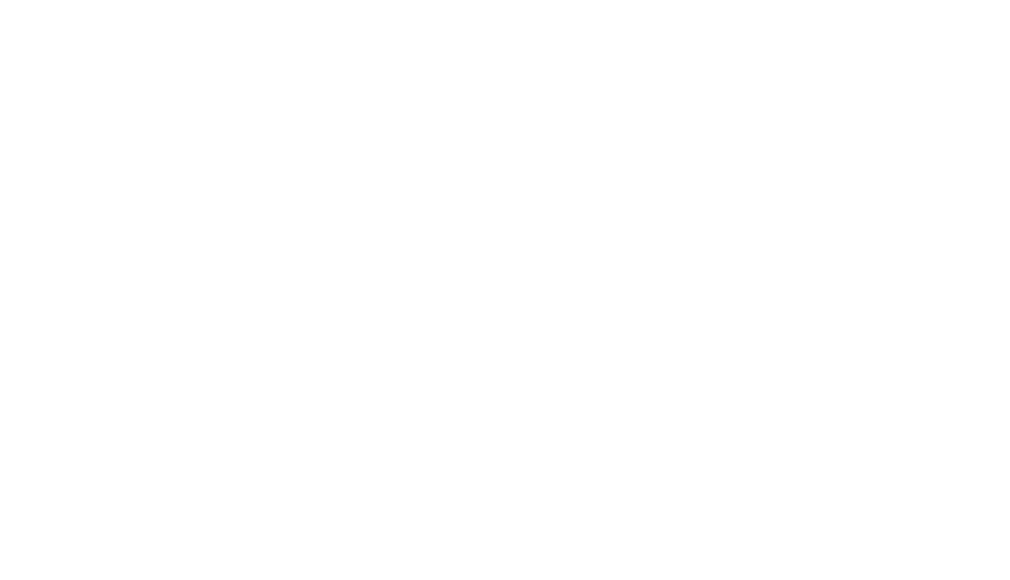

cleaning up lfp data
cleaning up speed data
found  0.0  outlier points
found  0.0  outlier points
(12206, 87, 23) (12206, 87, 23)
found  0.0  outlier points
(12206, 87, 46) (12206, 87, 12)
cleaning up lfp data
cleaning up speed data
found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points
found  50.0  outlier points
found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points


 62%|██████▎   | 10/16 [12:12<08:18, 83.05s/it]

<IPython.core.display.Javascript object>


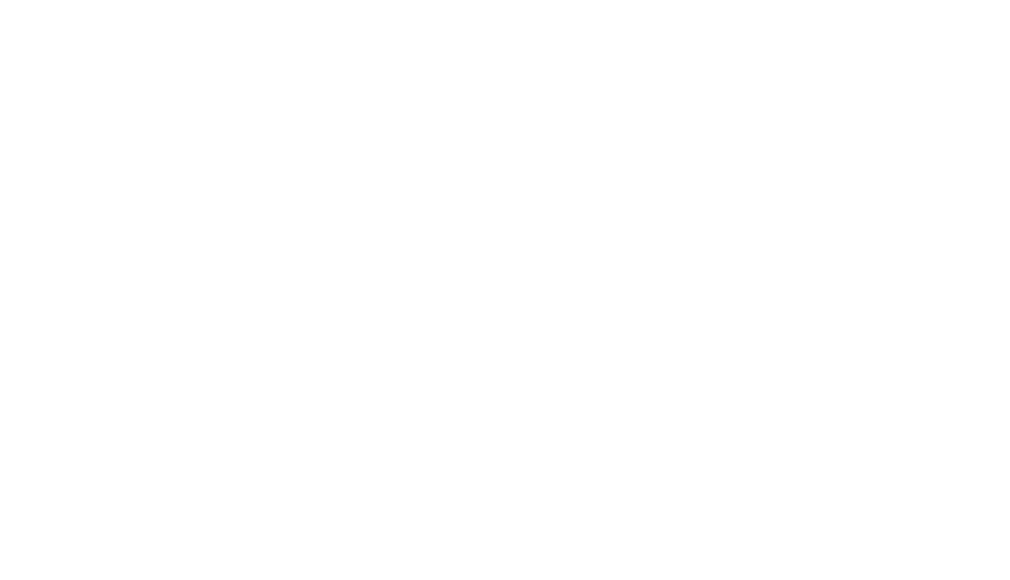

cleaning up lfp data
cleaning up speed data
found  0.0  outlier points
found  0.0  outlier points
(12206, 87, 4) (12206, 87, 2)
found  0.0  outlier points
(12206, 87, 6) (12206, 87, 9)
cleaning up lfp data
cleaning up speed data
found  29.0  outlier points
found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points


 69%|██████▉   | 11/16 [14:03<07:36, 91.37s/it]

<IPython.core.display.Javascript object>


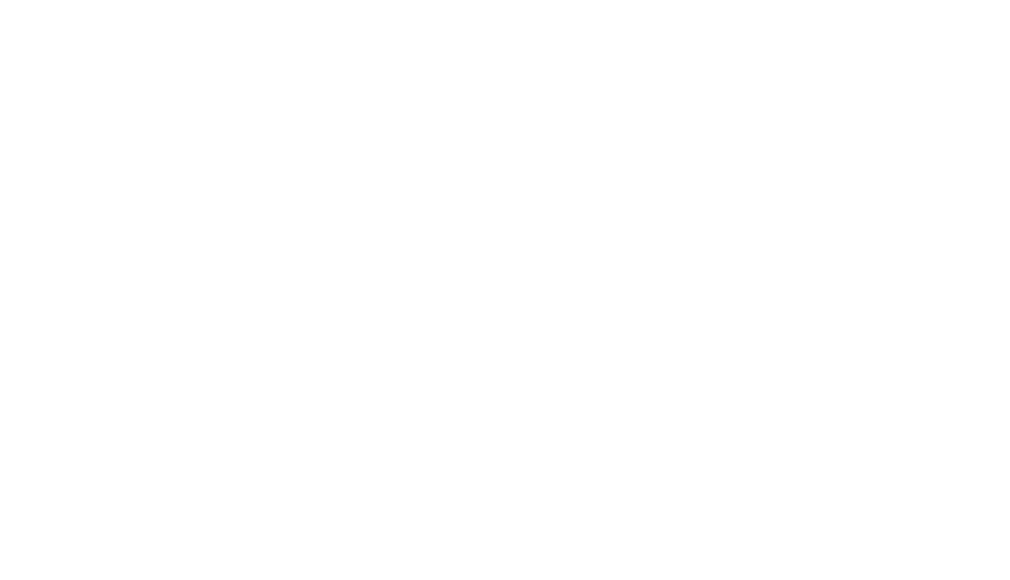

cleaning up lfp data
cleaning up speed data
found  0.0  outlier points
found  0.0  outlier points
(12206, 87, 5) (12206, 87, 7)
found  0.0  outlier points
(12206, 87, 12) (12206, 87, 9)
cleaning up lfp data
cleaning up speed data
found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points


 75%|███████▌  | 12/16 [15:44<06:17, 94.32s/it]

<IPython.core.display.Javascript object>


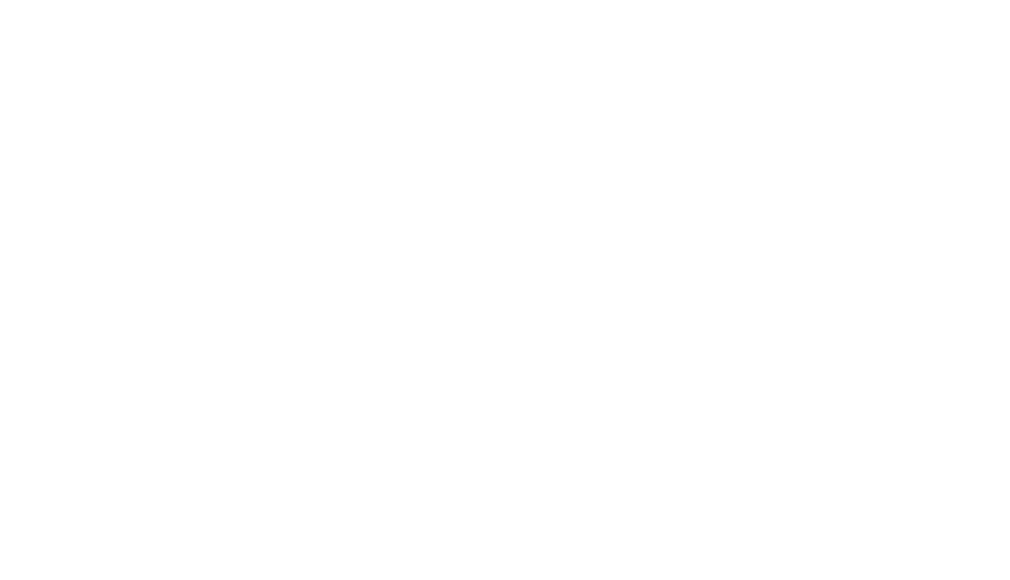

cleaning up lfp data
cleaning up speed data
found  0.0  outlier points
found  0.0  outlier points
(12206, 87, 25) (12206, 87, 20)
found  0.0  outlier points
(12206, 87, 45) (12206, 87, 15)
cleaning up lfp data
cleaning up speed data
found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points


 81%|████████▏ | 13/16 [17:37<05:00, 100.08s/it]

<IPython.core.display.Javascript object>


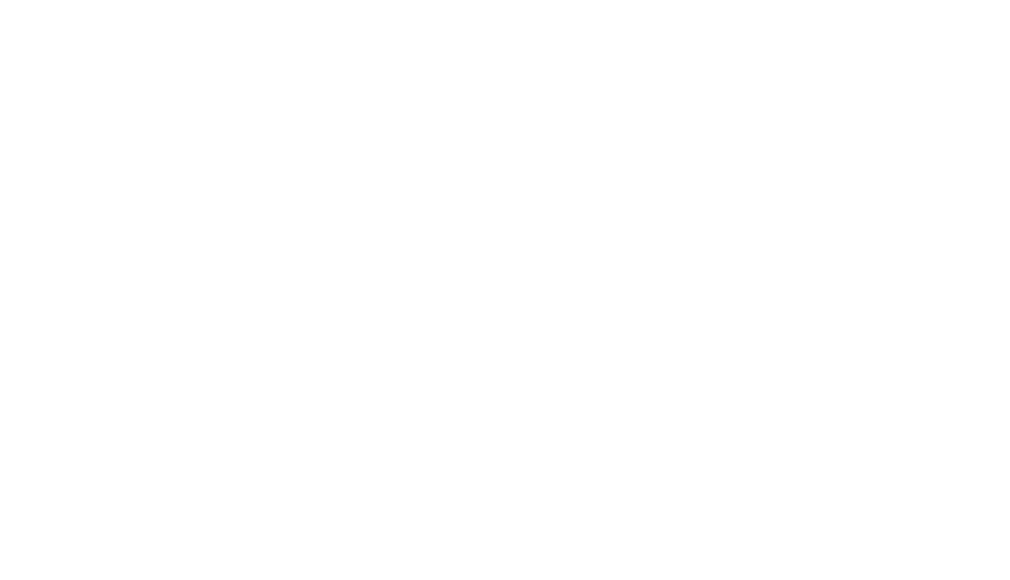

cleaning up lfp data
cleaning up speed data
found  0.0  outlier points
found  0.0  outlier points
(12206, 87, 0) (12206, 87, 4)
found  0.0  outlier points
(12206, 87, 4) (12206, 87, 2)
cleaning up lfp data
cleaning up speed data
found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points


 88%|████████▊ | 14/16 [18:57<03:07, 93.79s/it] 

<IPython.core.display.Javascript object>


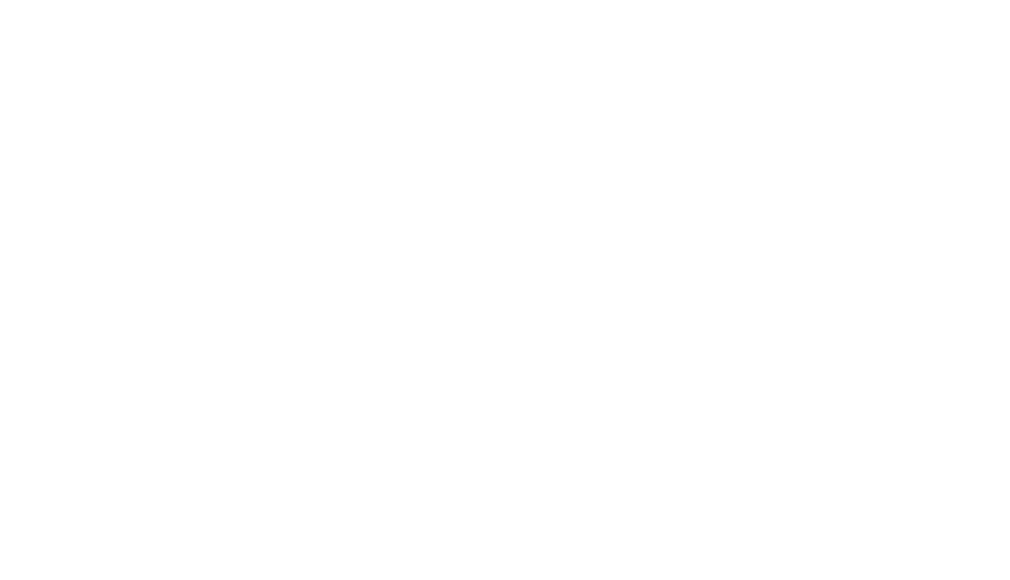

cleaning up lfp data
cleaning up speed data
found  0.0  outlier points
found  0.0  outlier points
(12206, 87, 6) (12206, 87, 29)
found  0.0  outlier points
(12206, 87, 35) (12206, 87, 39)
cleaning up lfp data
cleaning up speed data
found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points


 94%|█████████▍| 15/16 [20:32<01:34, 94.18s/it]

<IPython.core.display.Javascript object>


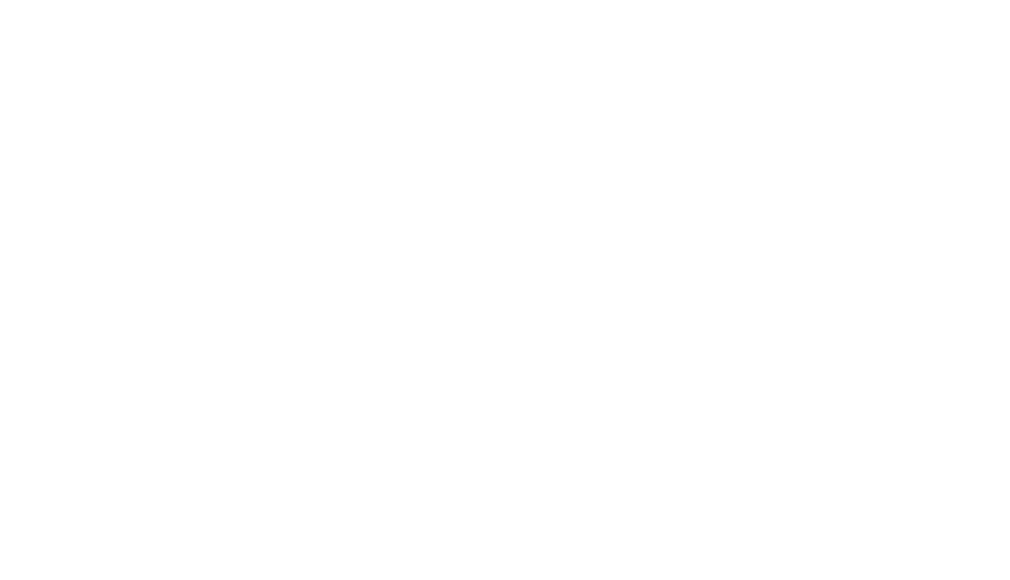

cleaning up lfp data
cleaning up speed data
found  0.0  outlier points
found  0.0  outlier points
(12206, 87, 6) (12206, 87, 8)
found  0.0  outlier points
(12206, 87, 14) (12206, 87, 3)
cleaning up lfp data
cleaning up speed data
found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points


100%|██████████| 16/16 [22:06<00:00, 94.22s/it]


<IPython.core.display.Javascript object>


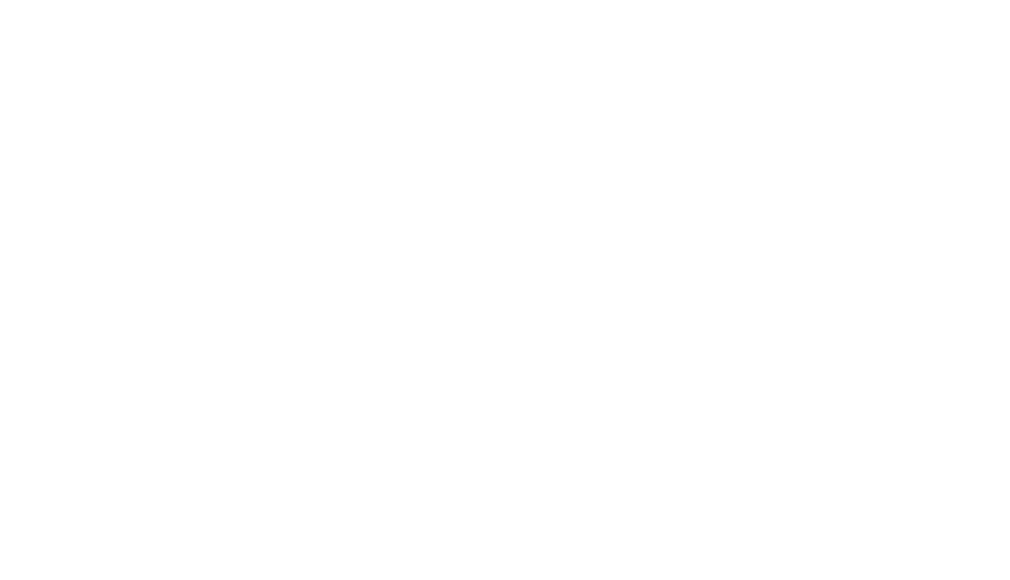

In [4]:
# align spectogram to mvmt onset -> for each mouse and in total:
f = h5py.File('Spectograms.hdf5','r')

# global presentation params and color params:
prs = Presentation()
prs.slide_width = Inches(11)
title_layout = prs.slide_layouts[5] 
title_slide_layout = prs.slide_layouts[0]
slide = prs.slides.add_slide(title_slide_layout)
slide.shapes.title.text = 'LFP aligned to mvmt onset'
lf = {'left':0.30, 'top':1.30, 'height':5.80, 'width':10.10}
fArgs = {'left':Inches(lf['left']),'top':Inches(lf['top']), 'height':Inches(lf['height']), 'width':Inches(lf['width'])}


miceList = getMiceList(Files[0])
for m in tqdm(miceList):
    fig, ax = plt.subplots(2,2,figsize=(lf['width'],lf['height']),sharex='col',sharey='row')  
    data =  getData(Files[0],['lfp','speed'],period ='Pre', mice=m,day = lambda x: x==0)
    
    for sess in data:
        # get data
        dtS = 1/data[sess]['speed']['Fs']
        dtL = 1/data[sess]['lfp']['FS']
        ts = np.arange(0, np.max(data[sess]['speed']['speed'].shape)) * dtS 
        tl = np.arange(0, np.max(data[sess]['lfp']['lfp'].shape)) * dtL
        
        tPlot = np.linspace(-2,2,4/dtL)
        tPlotS = np.linspace(-2,2,4/dtS)
        
        mvmtOnset = getOnsetOrPeriod(m,sess,'Pre','mvmtOnset')
        mvmtOnsetL = np.full_like(tl,False)
        for si in ts[mvmtOnset]:
            ti = np.argmin(np.abs(tl-si))
            mvmtOnsetL[ti] = True
        
        
        
#        del mvmtOnset
    
#        freq = f[m]['freq'].value
        coeff = np.abs(f[m][sess]['Pre']['coeff'].value)
        
#        totP = np.sum(coeff,axis=1)
#        coeff = coeff.T/totP.T
#        coeff = coeff.T
        
        lfpOutliers = removeLFPOutliers(data[sess]['lfp']['lfp'], sess)
        coeff[:,(lfpOutliers[:,0]==1)] = np.nan
        coeff = coeff.T#*freq
        
        al = alignToOnset(coeff,(mvmtOnsetL==1), winPost =2/dtL, winPre = 2/dtL)
        
        if al.ndim <3:
            continue
        
        if 'aligned' in locals():
            print(aligned.shape,al.shape)
            aligned = np.concatenate((aligned,al), axis = 2)
        else:
            aligned = al
        
        alS = alignToOnset(data[sess]['speed']['speed'].T,(mvmtOnset==1), winPost =2/dtS, winPre = 2/dtS)
        
        if alS.ndim <2:
            continue
        
        if 'alignedS' in locals():
            alignedS = np.concatenate((alignedS,alS), axis = 1)
        else:
            alignedS = alS
    
    freq = f[m]['freq'].value
    d = np.nanmean(aligned,axis=2)
    d = d/np.mean(d[:int(d.shape[0]/2),:],axis=0)
    
    im = ax[0,0].pcolormesh(tPlot,freq,d.transpose())
#    cbar=plt.colorbar(im,ax=ax[0,0])
#    cbar.set_label(label='Power',size=16)
    ax[0,0].axvline(x=0.0,color='red',linestyle='dashed')
    ax[0,0].set_title('Healthy',fontsize=16)
    ax[0,0].set_ylabel('Frequency (Hz)',fontsize=16)
    ax[0,0].set_xlabel('Time (s)',fontsize=16)
    ax[0,0].tick_params(axis = 'y',labelsize=16)
    ax[0,0].tick_params(axis = 'x',labelsize=16)
    
    PlotRelativeToOnset(ax[1,0],alignedS,tPlotS,Color='black',Label='speed',mesErr=True)
    
        
    if 'Haligned' in locals():
        Haligned = np.concatenate((Haligned,aligned), axis = 2)
    else:
        Haligned = aligned
    
    del aligned
    
    if 'Haligneds' in locals():
        Haligneds = np.concatenate((Haligneds,alignedS), axis = 1)
    else:
        Haligneds = alignedS
    
    del alignedS
    
    data =  getData(Files[0],['lfp','speed'],period ='Pre', mice=m,day = lambda x: x>3)
    
    for sess in data:
        # get data
        dtS = 1/data[sess]['speed']['Fs']
        dtL = 1/data[sess]['lfp']['FS']
        ts = np.arange(0, np.max(data[sess]['speed']['speed'].shape)) * dtS 
        tl = np.arange(0, np.max(data[sess]['lfp']['lfp'].shape)) * dtL
        
        tPlot = np.linspace(-2,2,4/dtL)
        
        mvmtOnset = getOnsetOrPeriod(m,sess,'Pre','mvmtOnset')
        mvmtOnsetL = np.full_like(tl,False)
        for si in ts[mvmtOnset]:
            ti = np.argmin(np.abs(tl-si))
            mvmtOnsetL[ti] = True
#        del mvmtOnset
    
#        freq = f[m][sess]['Pre']['freq'].value
        coeff = np.abs(f[m][sess]['Pre']['coeff'].value)
        
#        totP = np.sum(coeff,axis=1)
#        coeff = coeff.T/totP.T
#        coeff = coeff.T
        
        lfpOutliers = removeLFPOutliers(data[sess]['lfp']['lfp'], sess)
        coeff[:,(lfpOutliers[:,0]==1)] = np.nan
        
        coeff = coeff.T#*freq
        al = alignToOnset(coeff,(mvmtOnsetL==1), winPost =2/dtL, winPre = 2/dtL)
       
        if al.ndim <3:
            continue
            
        if 'aligned' in locals():
            aligned = np.concatenate((aligned,al), axis = 2)
        else:
            aligned = al
            
        alS = alignToOnset(data[sess]['speed']['speed'].T,(mvmtOnset==1), winPost =2/dtS, winPre = 2/dtS)
        
        if alS.ndim <2:
            continue
        
        if 'alignedS' in locals():
            alignedS = np.concatenate((alignedS,alS), axis = 1)
        else:
            alignedS = alS
            
    if 'aligned' in locals():
        d = np.nanmean(aligned,axis=2)
        d = d/np.mean(d[:int(d.shape[0]/2),:],axis=0)
        
        im = ax[0,1].pcolormesh(tPlot,freq,d.transpose())
#        cbar=plt.colorbar(im,ax=ax[0,1])
#        cbar.set_label(label='Power',size=16)
        ax[0,1].axvline(x=0.0,color='red',linestyle='dashed')
        ax[0,1].set_title('post 6OHDA',fontsize=16)
#        ax[0,1].set_ylabel('Frequency (Hz)',fontsize=16)
        ax[0,1].set_xlabel('Time (s)',fontsize=16)
        ax[0,1].tick_params(axis = 'y',labelsize=16)
        ax[0,1].tick_params(axis = 'x',labelsize=16)
        
        PlotRelativeToOnset(ax[1,1],alignedS,tPlotS,Color='black',Label='speed',mesErr=True)
        
        if m=='1236':
            del aligned
            del alignedS
            continue
        
        if 'Saligned' in locals():
            Saligned = np.concatenate((Saligned,aligned), axis = 2)
        else:
            Saligned = aligned

        del aligned
        
        if 'Saligneds' in locals():
            Saligneds = np.concatenate((Saligneds,alignedS), axis = 1)
        else:
            Saligneds = alignedS

        del alignedS
    
    slide = prs.slides.add_slide(title_layout)
    slide.shapes.title.text = m 
    pic = plt2pptx(slide, fig, **fArgs)
    fig.clf()
    plt.close(fig)
    

    
fig, ax = plt.subplots(2,2,figsize=(lf['width'],lf['height']),sharex='col',sharey='row')    
    
d = np.nanmean(Haligned,axis=2)
im = ax[0,0].pcolormesh(tPlot,freq,d.transpose())
cbar=plt.colorbar(im,ax=ax[0,0])
cbar.set_label(label='Power',size=16)
ax[0,0].axvline(x=0.0,color='red',linestyle='dashed')
ax[0,0].set_title('Healthy',fontsize=16)
ax[0,0].set_ylabel('Frequency (Hz)',fontsize=16)
ax[0,0].set_xlabel('Time (s)',fontsize=16)
ax[0,0].tick_params(axis = 'y',labelsize=16)
ax[0,0].tick_params(axis = 'x',labelsize=16)

PlotRelativeToOnset(ax[1,0],Haligneds,tPlotS,Color='black',Label='speed',mesErr=True)

d = np.nanmean(Saligned,axis=2)
im = ax[0,1].pcolormesh(tPlot,freq,d.transpose())
cbar=plt.colorbar(im,ax=ax[0,1])
cbar.set_label(label='Power',size=16)
ax[0,1].axvline(x=0.0,color='red',linestyle='dashed')
ax[0,1].set_title('post 6OHDA',fontsize=16)
#ax[0,1].set_ylabel('Frequency (Hz)',fontsize=16)
ax[0,1].set_xlabel('Time (s)',fontsize=16)
ax[0,1].tick_params(axis = 'y',labelsize=16)
ax[0,1].tick_params(axis = 'x',labelsize=16)

PlotRelativeToOnset(ax[1,1],Saligneds,tPlotS,Color='black',Label='speed',mesErr=True)

slide = prs.slides.add_slide(title_layout)
slide.shapes.title.text = 'all Mice' 
pic = plt2pptx(slide, fig, **fArgs)
fig.clf()
plt.close(fig)
    

        
prs.save('ppts/LFP_aligned2speed_onset3.pptx')

In [17]:
print(d.shape,d.shape[0]/2)
l = np.mean(d[:int(d.shape[0]/2),:],axis=0)
print(l.shape)
d = d/np.mean(d[:int(d.shape[0]/2),:],axis=0)

(12206, 87) 6103.0
(87,)


In [ ]:
# align spectogram to mvmt onset -> for each mouse and in total:
f = h5py.File('Spectograms.hdf5','r')

# global presentation params and color params:
lf = {'left':0.30, 'top':1.30, 'height':5.80, 'width':10.10}
fArgs = {'left':Inches(lf['left']),'top':Inches(lf['top']), 'height':Inches(lf['height']), 'width':Inches(lf['width'])}


miceList = getMiceList(Files[0])
for m in tqdm(miceList):
    prs = Presentation()
    prs.slide_width = Inches(11)
    title_layout = prs.slide_layouts[5] 
    title_slide_layout = prs.slide_layouts[0]
    slide = prs.slides.add_slide(title_slide_layout)
    slide.shapes.title.text = 'LFP aligned to mvmt onset'
    
    data =  getData(Files[0],['lfp','speed'],period ='Pre', mice=m)
    
    for sess in data:
        
        fig, ax = plt.subplots(1,1,figsize=(lf['width'],lf['height']))
        
        # get data
        dtS = 1/data[sess]['speed']['Fs']
        dtL = 1/data[sess]['lfp']['FS']
        ts = np.arange(0, np.max(data[sess]['speed']['speed'].shape)) * dtS 
        tl = np.arange(0, np.max(data[sess]['lfp']['lfp'].shape)) * dtL
        
        tPlot = np.linspace(-2,2,4/dtL)
        
        mvmtOnset = getOnsetOrPeriod(m,sess,'Pre','mvmtOnset')
        mvmtOnsetL = np.full_like(tl,False)
        for si in ts[mvmtOnset]:
            ti = np.argmin(np.abs(tl-si))
            mvmtOnsetL[ti] = True
        del mvmtOnset
    
#        freq = f[m][sess]['Pre']['freq'].value
        coeff = f[m][sess]['Pre']['coeff'].value
        
#        totP = np.sum(coeff,axis=1)
#        coeff = coeff.T/totP.T
#        coeff = coeff.T
        
        lfpOutliers = removeLFPOutliers(data[sess]['lfp']['lfp'], sess)
        coeff[:,(lfpOutliers[:,0]==1)] = np.nan
        coeff = coeff.T
        
        al = alignToOnset(coeff,(mvmtOnsetL==1), winPost =2/dtL, winPre = 2/dtL)
        
        if al.ndim < 3:
            continue
    
        freq = f[m][sess]['Pre']['freq'].value
        d = np.mean(al,axis=2)
        im = ax.pcolormesh(tPlot,freq,d.transpose(),vmin =-2,vmax=2)
        cbar=plt.colorbar(im,ax=ax)
        cbar.set_label(label='Power',size=16)
        ax.axvline(x=0.0,color='red',linestyle='dashed')
        ax.set_title('Healthy',fontsize=16)
        ax.set_ylabel('Frequency (Hz)',fontsize=16)
        ax.set_xlabel('Time (s)',fontsize=16)
        ax.tick_params(axis = 'y',labelsize=16)
        ax.tick_params(axis = 'x',labelsize=16)

        slide = prs.slides.add_slide(title_layout)
        slide.shapes.title.text = sess 
        pic = plt2pptx(slide, fig, **fArgs)
        fig.clf()
        plt.close(fig)

    
        
    prs.save('ppts/LFP_aligned2speed_onset_perSess'+m+'.pptx')

<IPython.core.display.Javascript object>


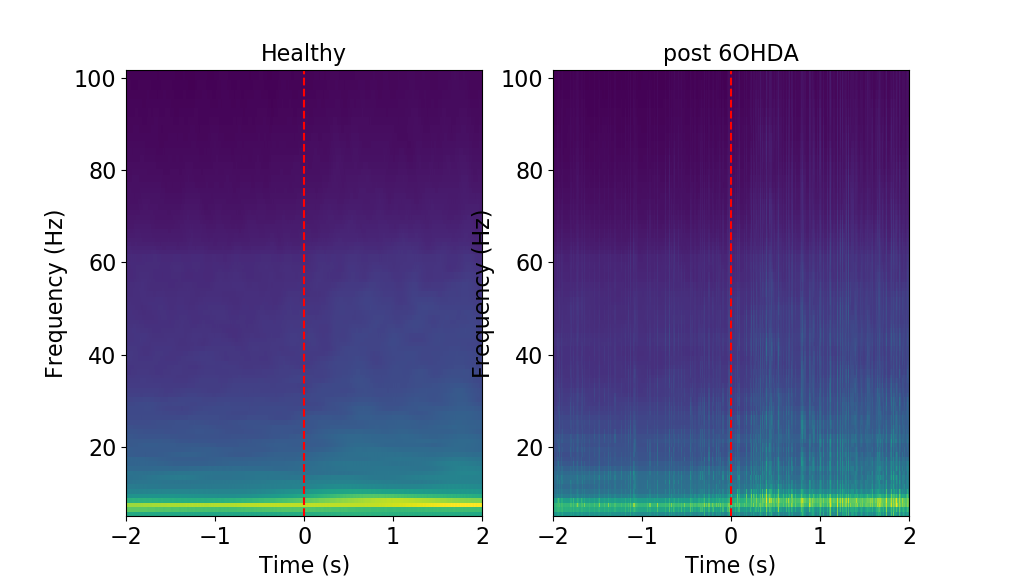

/home/dana_z/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: object of type <class 'numpy.ndarray'> cannot be safely interpreted as an integer.
  This is separate from the ipykernel package so we can avoid doing imports until


In [6]:
fig, ax = plt.subplots(1,2,figsize=(lf['width'],lf['height']))    

tPlot = np.linspace(-2,2,4/dtL)

d = np.nanmean(Haligned,axis=2)
im = ax[0].pcolormesh(tPlot,freq,d.transpose())
#cbar=plt.colorbar(im,ax=ax)
#cbar.set_label(label='Power',size=16)
ax[0].axvline(x=0.0,color='red',linestyle='dashed')
ax[0].set_title('Healthy',fontsize=16)
ax[0].set_ylabel('Frequency (Hz)',fontsize=16)
ax[0].set_xlabel('Time (s)',fontsize=16)
ax[0].tick_params(axis = 'y',labelsize=16)
ax[0].tick_params(axis = 'x',labelsize=16)

d = np.nanmean(Saligned,axis=2)
im = ax[1].pcolormesh(tPlot,freq,d.transpose())
#cbar=plt.colorbar(im,ax=ax)
#cbar.set_label(label='Power',size=16)
ax[1].axvline(x=0.0,color='red',linestyle='dashed')
ax[1].set_title('post 6OHDA',fontsize=16)
ax[1].set_ylabel('Frequency (Hz)',fontsize=16)
ax[1].set_xlabel('Time (s)',fontsize=16)
ax[1].tick_params(axis = 'y',labelsize=16)
ax[1].tick_params(axis = 'x',labelsize=16)


  0%|          | 0/16 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


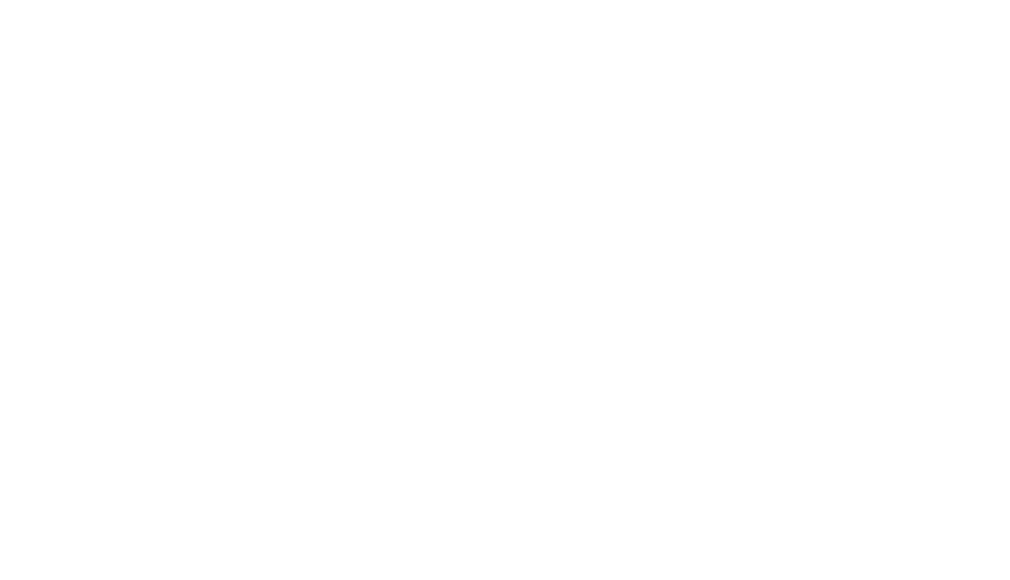

cleaning up lfp data
cleaning up speed data
found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points


  6%|▋         | 1/16 [00:14<03:37, 14.50s/it]

<IPython.core.display.Javascript object>


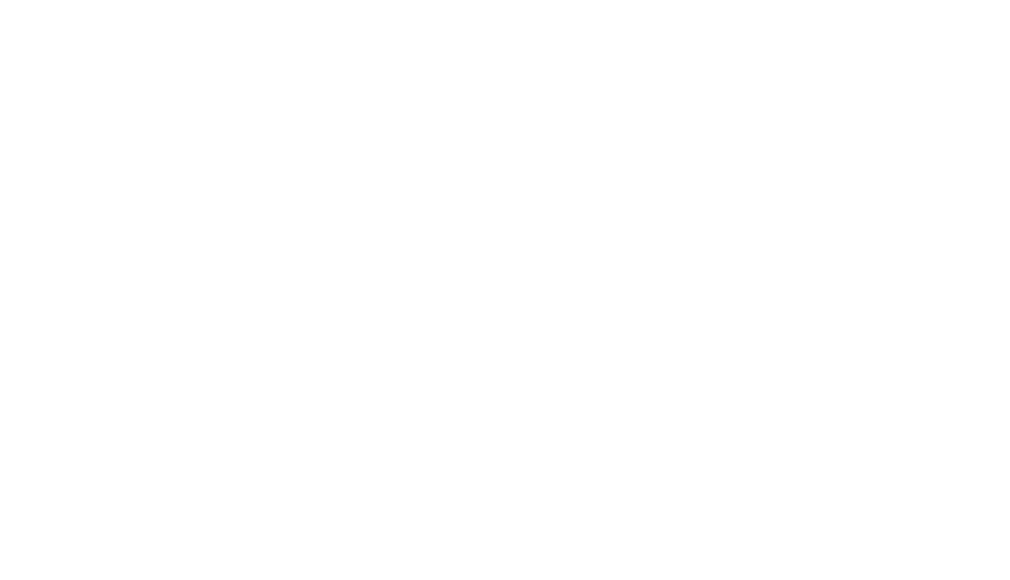

cleaning up lfp data
cleaning up speed data
found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points


 12%|█▎        | 2/16 [00:41<04:13, 18.13s/it]

<IPython.core.display.Javascript object>


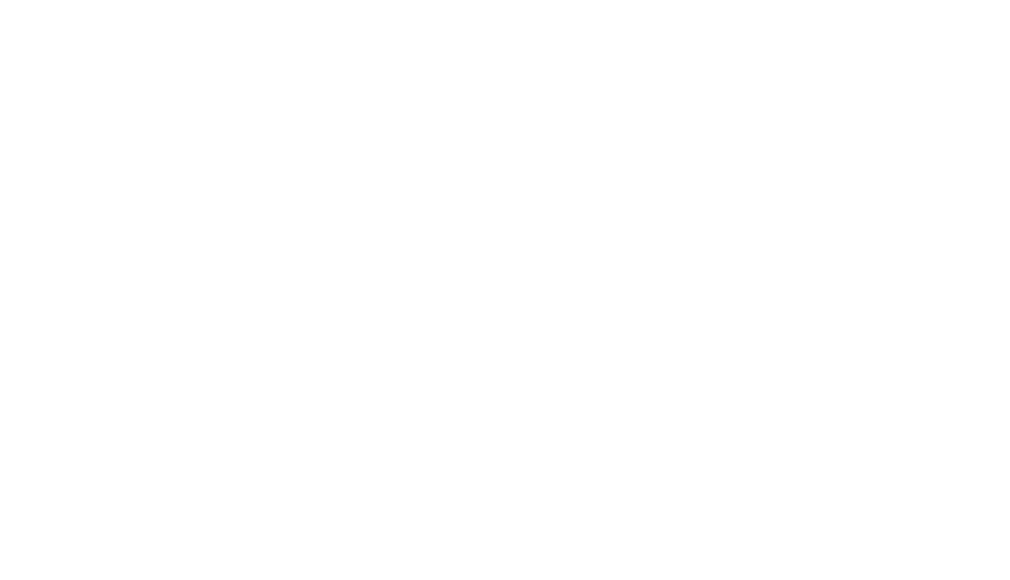

cleaning up lfp data
cleaning up speed data
found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points


 19%|█▉        | 3/16 [01:08<04:30, 20.79s/it]

<IPython.core.display.Javascript object>


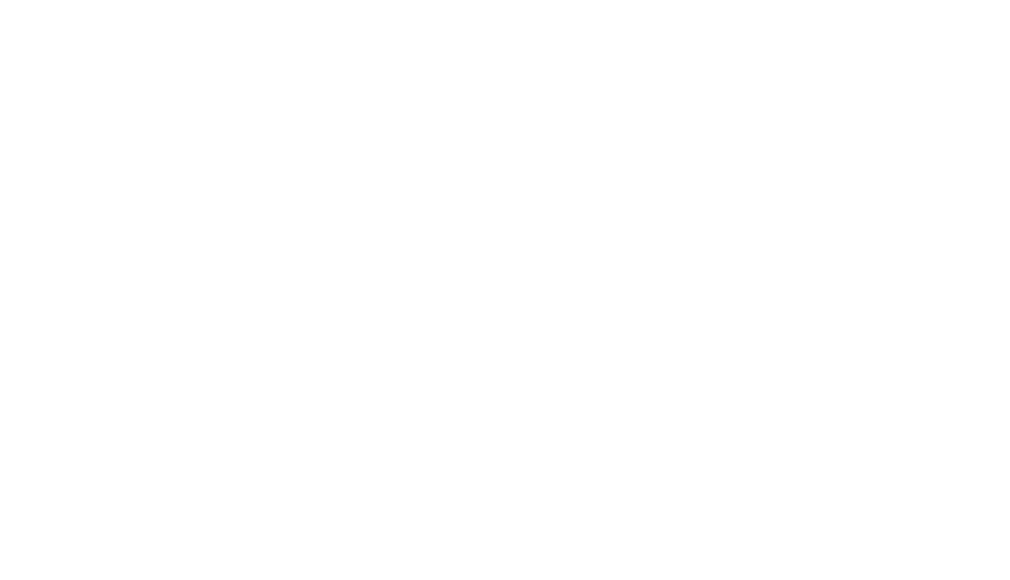

cleaning up lfp data
cleaning up speed data
found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points


 25%|██▌       | 4/16 [01:34<04:30, 22.52s/it]

<IPython.core.display.Javascript object>


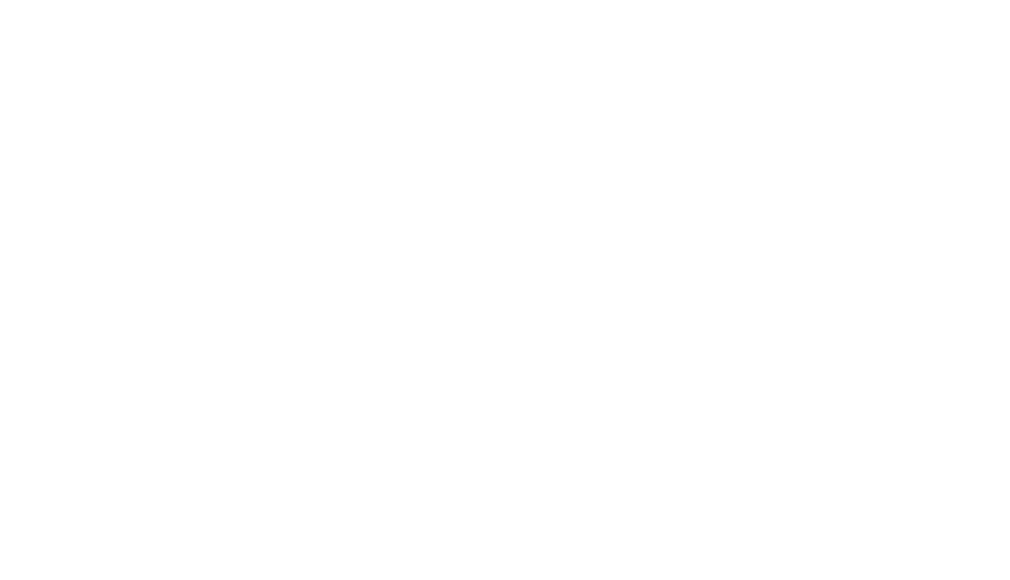

cleaning up lfp data
cleaning up speed data
found  1.0  outlier points
found  0.0  outlier points
found  0.0  outlier points


 31%|███▏      | 5/16 [02:01<04:22, 23.88s/it]

<IPython.core.display.Javascript object>


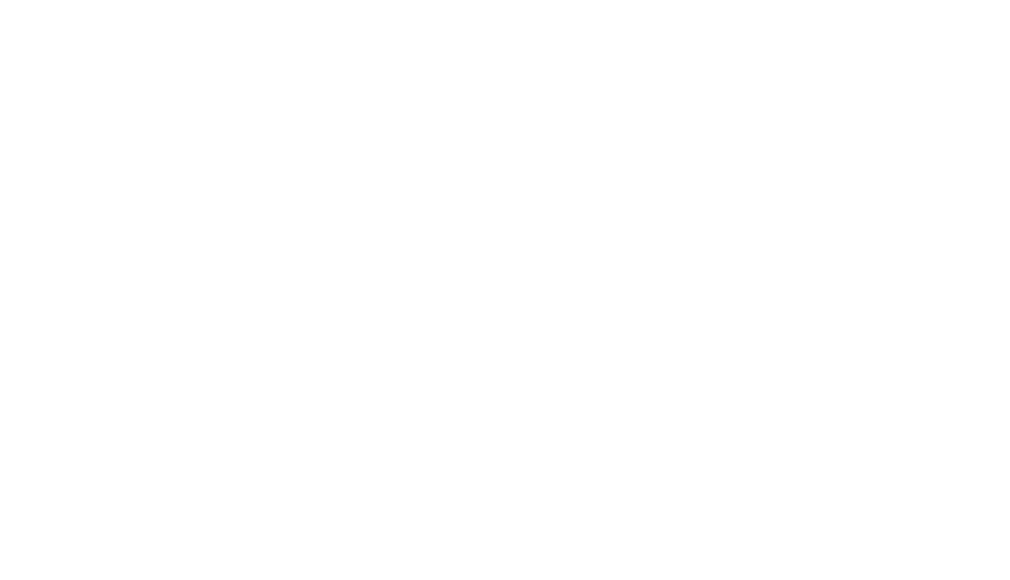

cleaning up lfp data
cleaning up speed data
found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points


 38%|███▊      | 6/16 [02:28<04:07, 24.72s/it]

<IPython.core.display.Javascript object>


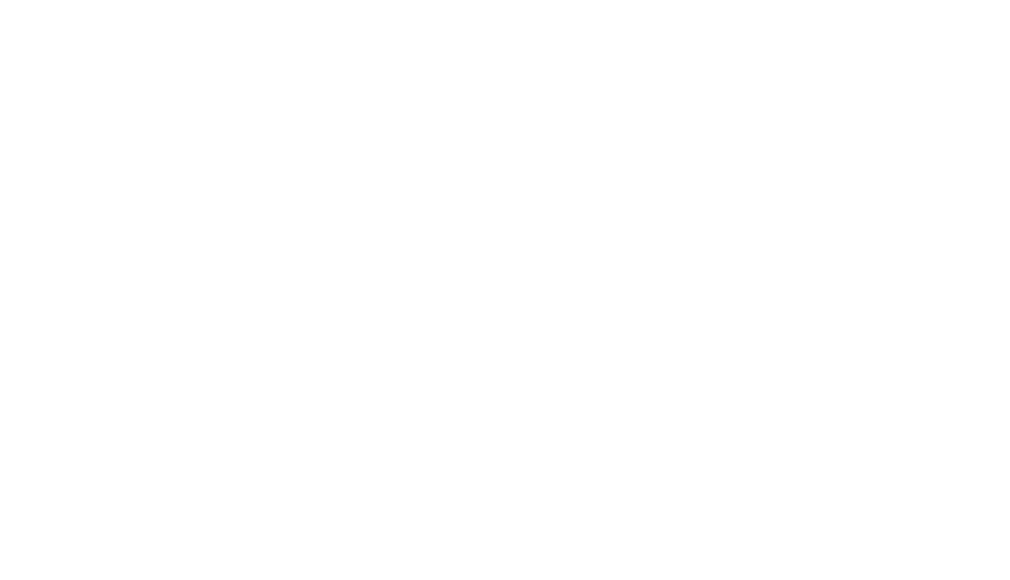

cleaning up lfp data
cleaning up speed data
found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points


 44%|████▍     | 7/16 [02:56<03:50, 25.61s/it]

<IPython.core.display.Javascript object>


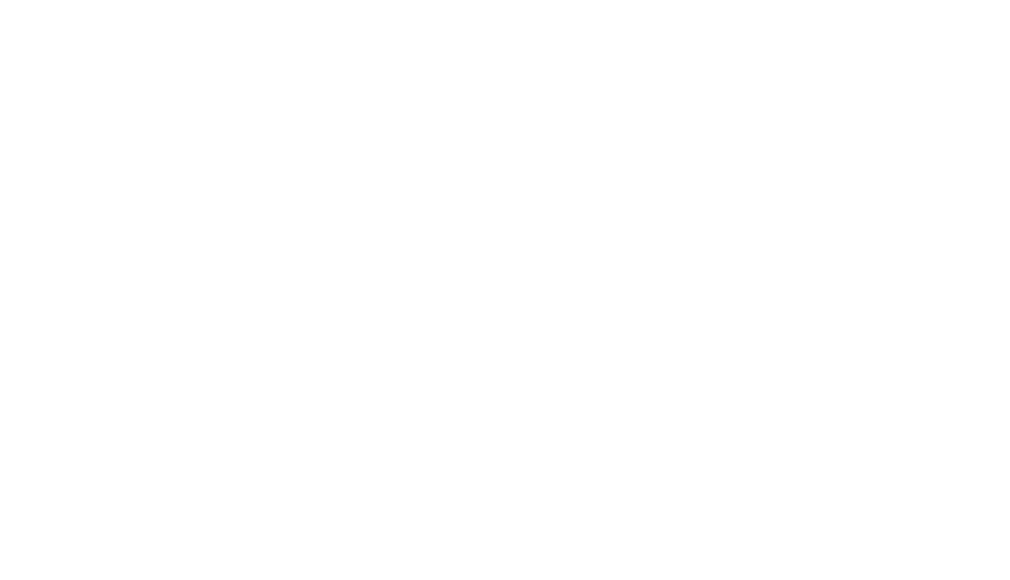

cleaning up lfp data
cleaning up speed data
found  1.0  outlier points
found  0.0  outlier points
found  0.0  outlier points


 50%|█████     | 8/16 [03:23<03:28, 26.01s/it]

<IPython.core.display.Javascript object>


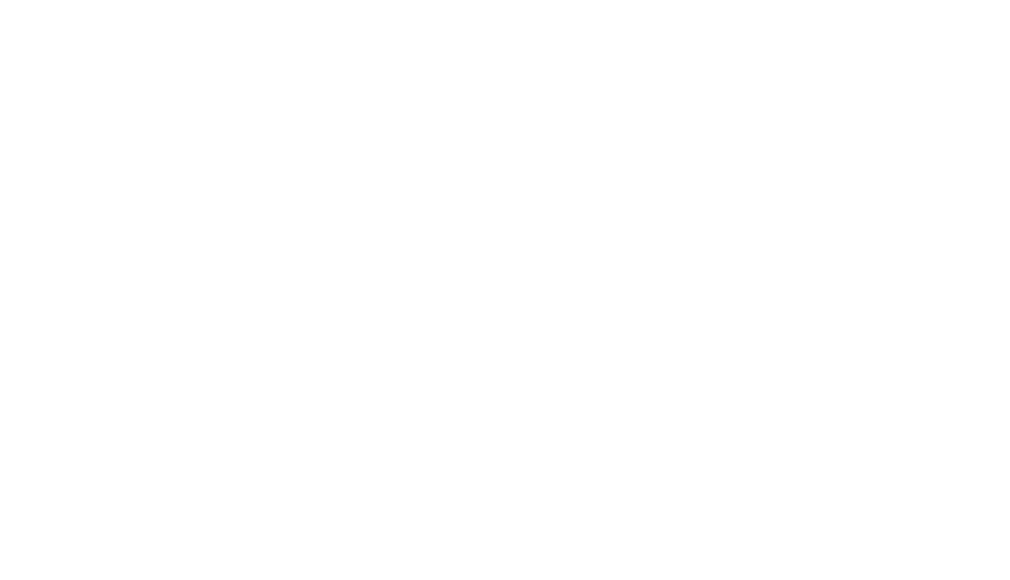

cleaning up lfp data
cleaning up speed data
found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points


 56%|█████▋    | 9/16 [03:50<03:06, 26.59s/it]

<IPython.core.display.Javascript object>


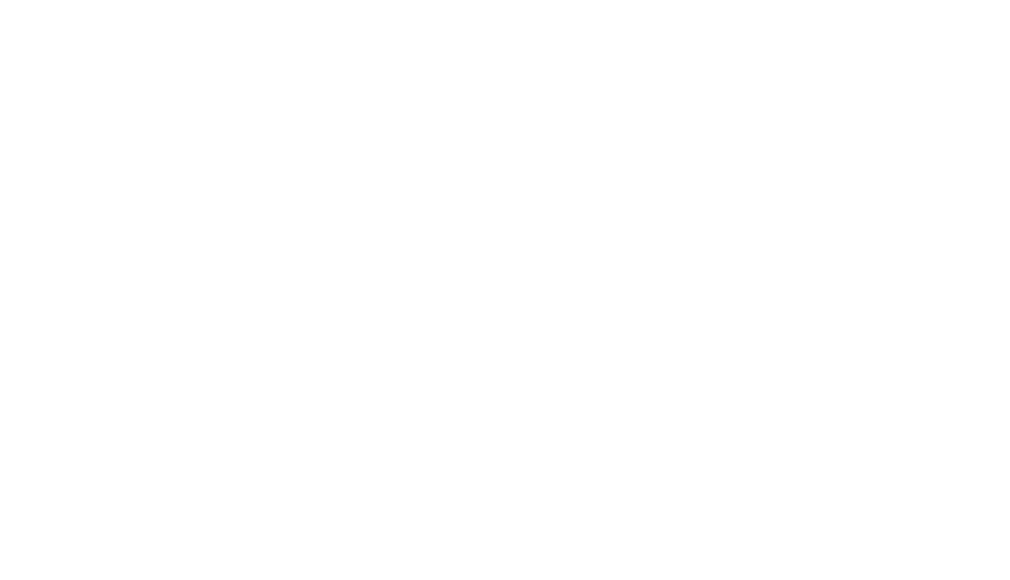

cleaning up lfp data
cleaning up speed data
found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points


 62%|██████▎   | 10/16 [04:19<02:43, 27.21s/it]

<IPython.core.display.Javascript object>


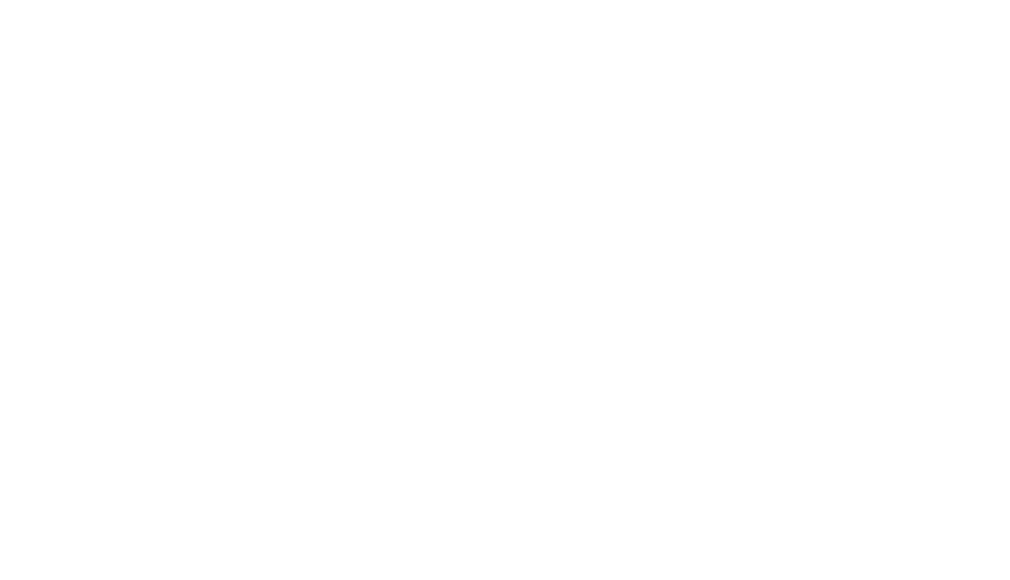

cleaning up lfp data
cleaning up speed data
found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points


 69%|██████▉   | 11/16 [04:48<02:18, 27.68s/it]

<IPython.core.display.Javascript object>


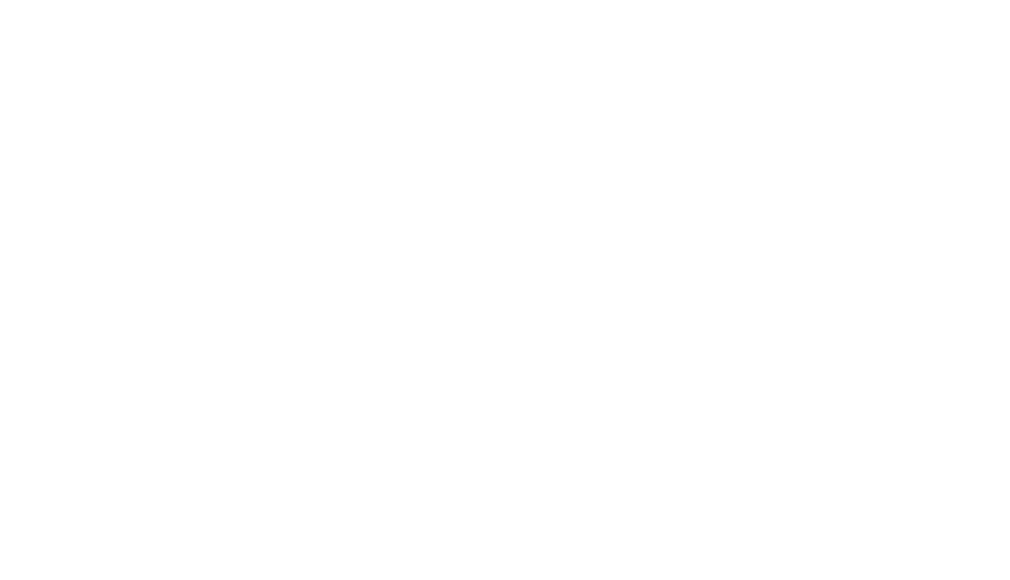

cleaning up lfp data
cleaning up speed data
found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points


 75%|███████▌  | 12/16 [05:17<01:51, 27.96s/it]

<IPython.core.display.Javascript object>


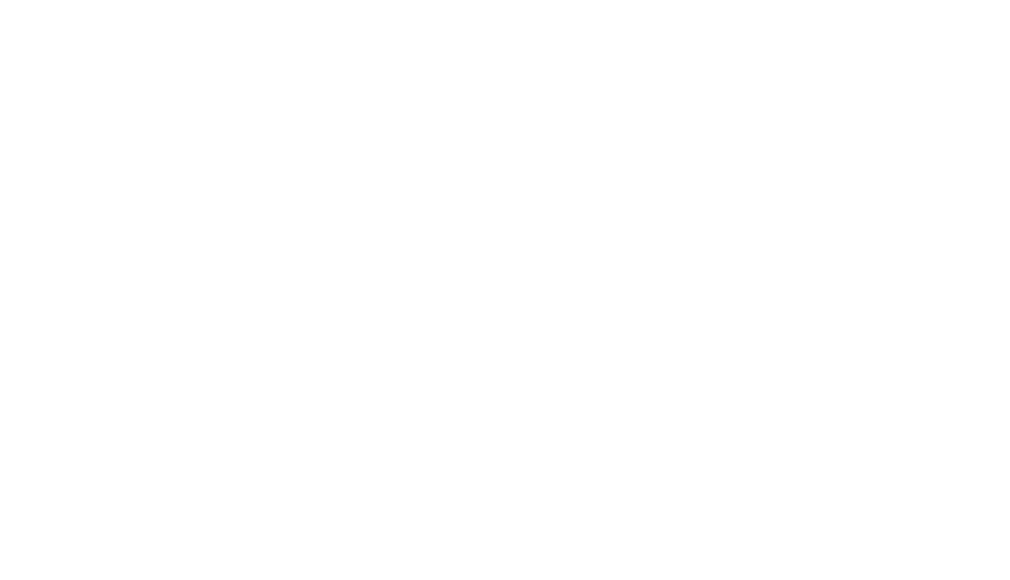

cleaning up lfp data
cleaning up speed data
found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points


 81%|████████▏ | 13/16 [05:46<01:25, 28.51s/it]

<IPython.core.display.Javascript object>


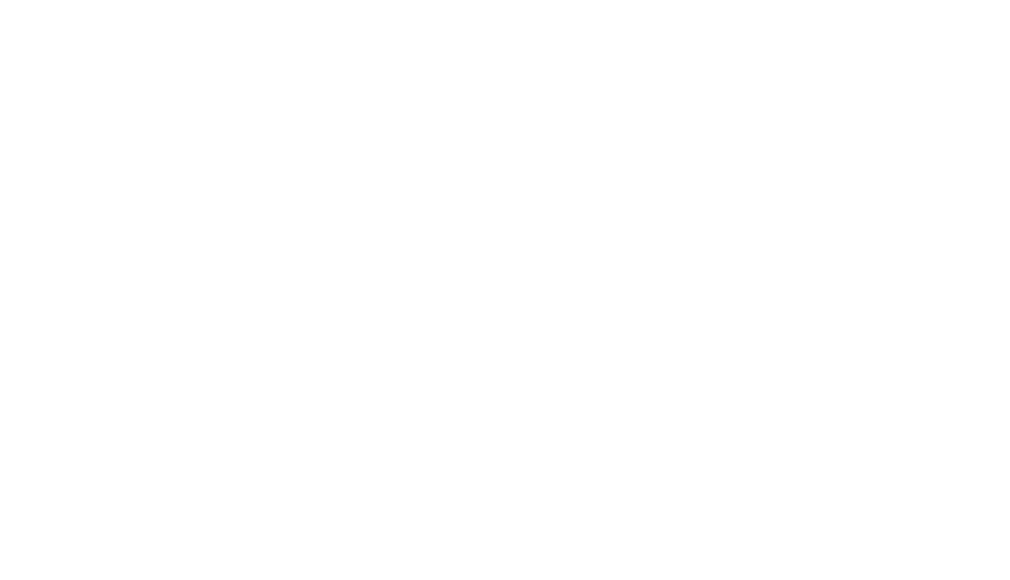

cleaning up lfp data
cleaning up speed data
found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points


 88%|████████▊ | 14/16 [06:16<00:57, 28.85s/it]

<IPython.core.display.Javascript object>


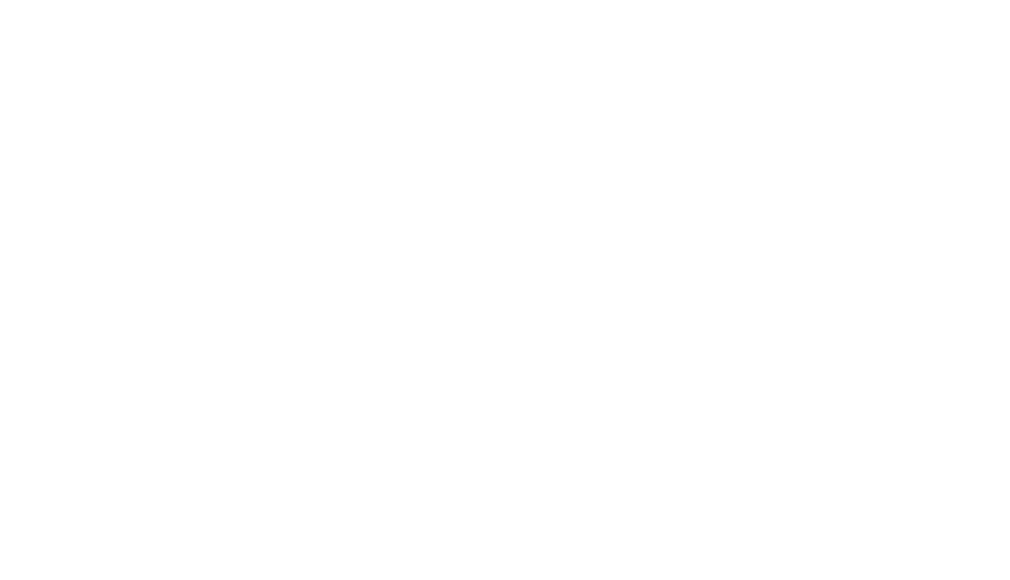

cleaning up lfp data
cleaning up speed data
found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points


 94%|█████████▍| 15/16 [06:46<00:29, 29.29s/it]

<IPython.core.display.Javascript object>


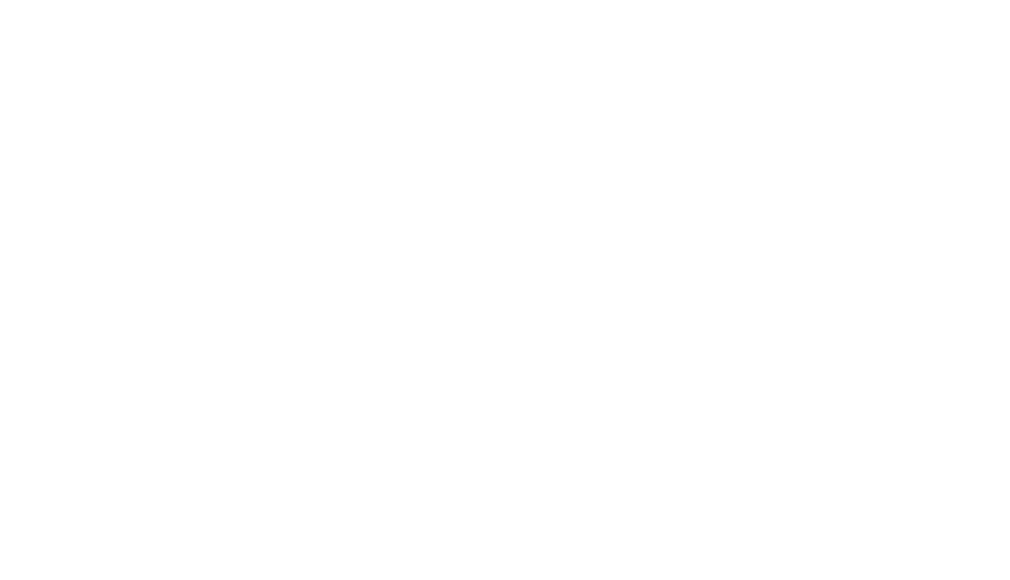

cleaning up lfp data
cleaning up speed data
found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points


100%|██████████| 16/16 [07:16<00:00, 29.54s/it]


<IPython.core.display.Javascript object>


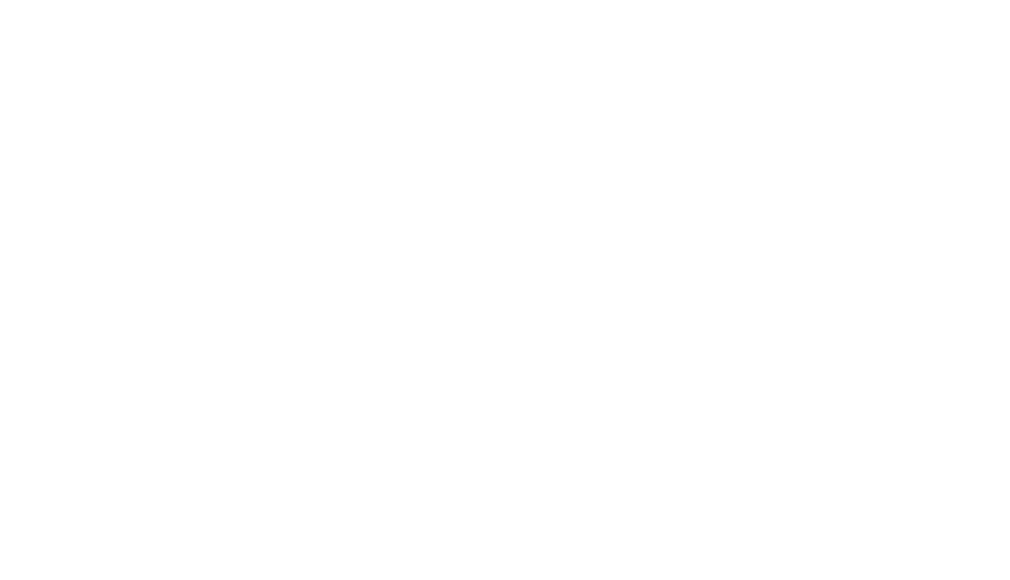

/home/dana_z/anaconda3/lib/python3.7/zipfile.py:1473: UserWarning: Duplicate name: 'ppt/slideLayouts/slideLayout1.xml'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
/home/dana_z/anaconda3/lib/python3.7/zipfile.py:1473: UserWarning: Duplicate name: 'ppt/slideLayouts/_rels/slideLayout1.xml.rels'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
/home/dana_z/anaconda3/lib/python3.7/zipfile.py:1473: UserWarning: Duplicate name: 'ppt/slideMasters/slideMaster1.xml'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
/home/dana_z/anaconda3/lib/python3.7/zipfile.py:1473: UserWarning: Duplicate name: 'ppt/slideMasters/_rels/slideMaster1.xml.rels'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
/home/dana_z/anaconda3/lib/python3.7/zipfile.py:1473: UserWarning: Duplicate name: 'ppt/slideLayouts/slideLayout11.xml'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
/home/dana_z/anaconda3/lib/python3.7/zipfile.py:1473: UserWarning: Duplicate 

In [6]:
# spectrom in high/low mvmt
f = h5py.File('Spectograms.hdf5','r')

# global presentation params and color params:
prs = Presentation()
prs.slide_width = Inches(11)
title_layout = prs.slide_layouts[5] 
title_slide_layout = prs.slide_layouts[0]
slide = prs.slides.add_slide(title_slide_layout)
slide.shapes.title.text = 'LFP spectrom in hi/low mvmt'

prs2 = Presentation()
prs2.slide_width = Inches(11)
slide = prs2.slides.add_slide(title_slide_layout)
slide.shapes.title.text = 'LFP spectrom in hi/low mvmt - per session'

lf = {'left':0.30, 'top':1.30, 'height':5.80, 'width':10.10}
fArgs = {'left':Inches(lf['left']),'top':Inches(lf['top']), 'height':Inches(lf['height']), 'width':Inches(lf['width'])}

Colors = CP('highLowSpeed')

# fig2, ax2 = plt.subplots(2,1,figsize=(lf['width'],lf['height']))
miceList = getMiceList(Files[0])
for m in tqdm(miceList):
    fig, ax = plt.subplots(1,1,figsize=(lf['width'],lf['height']))
    
    data =  getData(Files[0],['lfp','speed'],period ='Pre', mice=m,day = lambda x: x==0)
    
    for sess in data:
        # get data
        dtS = 1/data[sess]['speed']['Fs']
        dtL = 1/data[sess]['lfp']['FS']
        ts = np.arange(0, np.max(data[sess]['speed']['speed'].shape)) * dtS 
        tl = np.arange(0, np.max(data[sess]['lfp']['lfp'].shape)) * dtL
        
        
        
        HpStart = getOnsetOrPeriod(m,sess,'Pre','HighMvmtPeriods_StartSegments')
        HpEnd = getOnsetOrPeriod(m,sess,'Pre','HighMvmtPeriods_EndSegments')

        LpStart = getOnsetOrPeriod(m,sess,'Pre','LowMvmtPeriods_StartSegments')
        LpEnd = getOnsetOrPeriod(m,sess,'Pre','LowMvmtPeriods_EndSegments')
        
        Himvmt = np.full_like(tl,False)
        Lomvmt = np.full_like(tl,False)
        
        for segI, seg in enumerate(HpStart):
            si = np.argmin(np.abs(tl-ts[seg]))
            se = np.argmin(np.abs(tl-ts[HpEnd[segI]]))
            Himvmt[si:se] = True
        for segI, seg in enumerate(LpStart):
            si = np.argmin(np.abs(tl-ts[seg]))
            se = np.argmin(np.abs(tl-ts[LpEnd[segI]]))
            Lomvmt[si:se] = True
        
        
        del HpStart,LpStart,HpEnd,LpEnd
    
        freq = f[m]['freq'].value
        coeff = np.abs(f[m][sess]['Pre']['coeff'].value)
        
#         totP = np.sum(coeff,axis=0)
        
        coeff = coeff #/totP
#        coeff = coeff
        
        lfpOutliers = removeLFPOutliers(data[sess]['lfp']['lfp'], sess)
        coeff[:,(lfpOutliers[:,0]==1)] = np.nan
        coeff = coeff.T
        
        
#         ax2[0].plot(freq,np.nanmean((coeff[(Lomvmt ==1),:]/np.nanmean(totP[(Lomvmt ==1)])),axis=0),color = Colors['low'] )
#         ax2[0].plot(freq,np.nanmean((coeff[(Himvmt ==1),:])/np.nanmean(totP[(Himvmt ==1)]),axis=0),color = Colors['high'])
#         ax2[1].plot(totP)
        
#         slide = prs2.slides.add_slide(title_layout)
#         slide.shapes.title.text = sess 
#         pic = plt2pptx(slide, fig2, **fArgs)
#         fig2.clf()


        
        if 'LowCoeff' in locals():
            LowCoeff = np.concatenate((LowCoeff,(coeff[(Lomvmt ==1),:])))#/np.nanmean(totP[(Lomvmt ==1)]))), axis = 0)
        else:
            LowCoeff = coeff[(Lomvmt ==1),:]#/np.nanmean(totP[(Lomvmt ==1)])

        if 'HiCoeff' in locals():
            HiCoeff = np.concatenate((HiCoeff,(coeff[(Himvmt ==1),:])))#/np.nanmean(totP[(Himvmt ==1)]))), axis = 0)
        else:
            HiCoeff = coeff[(Himvmt ==1),:]#/np.nanmean(totP[(Himvmt ==1)])
                                                     
#    freq = f[m][sess]['Pre']['freq'].value


    ax.plot(freq,np.nanmean(HiCoeff,axis=0),color = Colors['high'] )
    ax.plot(freq,np.nanmean(LowCoeff,axis=0),color = Colors['low'] )

    
    if 'HHc' in locals():
        HHc = np.concatenate((HHc,HiCoeff), axis = 0)
    else:
        HHc = HiCoeff

    del HiCoeff

    if 'HLc' in locals():
        HLc = np.concatenate((HLc,LowCoeff), axis = 0)
    else:
        HLc = LowCoeff

    del LowCoeff

    
    
    slide = prs.slides.add_slide(title_layout)
    slide.shapes.title.text = m
    pic = plt2pptx(slide, fig, **fArgs)
    fig.clf()
    plt.close(fig)

fig, ax = plt.subplots(1,1,figsize=(lf['width'],lf['height']))
ax.plot(freq,np.nanmean(HHc,axis=0),color = Colors['high'] )
ax.plot(freq,np.nanmean(HLc,axis=0),color = Colors['low'] )
                                                     
                                                     
slide = prs.slides.add_slide(title_layout)
slide.shapes.title.text = 'all Mice' 
pic = plt2pptx(slide, fig, **fArgs)
fig.clf()
plt.close(fig)
    

        
prs.save('ppts/PSD_hiLo_mice.pptx')
prs2.save('ppts/PSD_hiLo_sess.pptx')

In [24]:
Hs = np.sum(HHc, axis=1)
Ls = np.sum(HLc, axis=1)
Hs2 = HHc.T/Hs.T
highC = np.nanmean(Hs2.T,axis=0)
highS = np.nanstd(Hs2.T,axis=0)
print(highC[0:2], highC.shape, np.sum(Hs2[:,15]))
del Hs, Hs2
Ls2 = HLc.T/Ls.T
lowC = np.nanmean(Ls2.T,axis=0)
lowS = np.nanstd(Ls2.T,axis=0)
print(lowC[0:2],lowC.shape, np.sum(Ls2[:,15]))
del Ls, Ls2




[0.02842703 0.03470729] (87,) 1.0000000000000002
[0.03092686 0.03655186] (87,) 1.0


In [25]:
ls = lowS
hs = highS

<IPython.core.display.Javascript object>


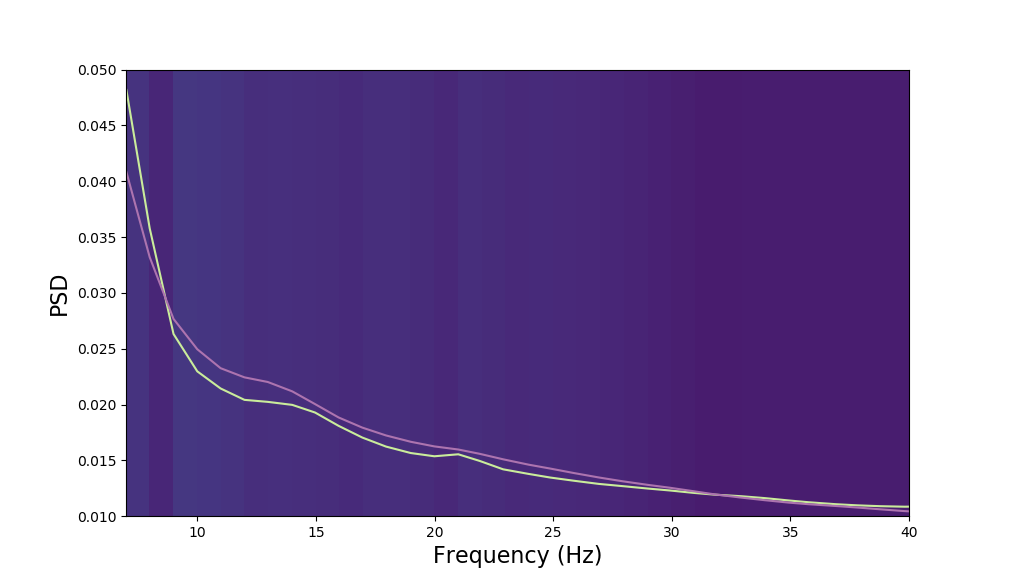

Text(0.5,0,'Frequency (Hz)')

In [42]:
lowS=ls/np.sqrt(48)
highS=hs/np.sqrt(48)
fig, ax = plt.subplots(1,1,figsize=(lf['width'],lf['height']))
ax.plot(freq,highC,color = Colors['high'] )
ax.fill_between(freq, highC-highS, highC+highS,color=Colors['high'],alpha=0.2)
ax.plot(freq,lowC,color = Colors['low'] )
ax.fill_between(freq, lowC-lowS, lowC+lowS,color=Colors['low'],alpha=0.2)
ax.set_xlim(7,40)
ax.set_ylim(0.010,0.050)
ax.set_ylabel('PSD',fontsize=16)
ax.set_xlabel('Frequency (Hz)',fontsize=16)





  0%|          | 0/16 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


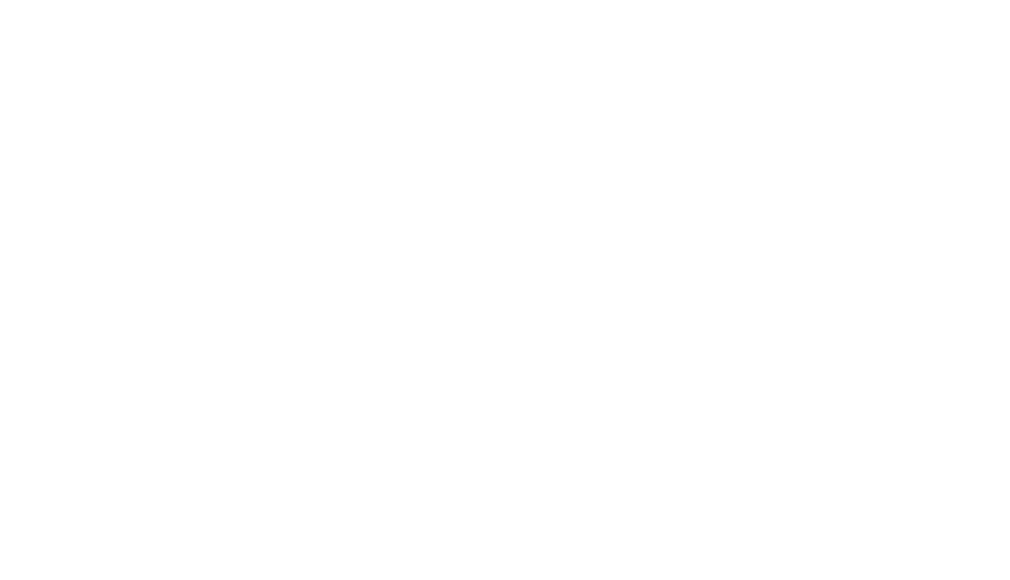

cleaning up lfp data
cleaning up speed data
found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points






  6%|▋         | 1/16 [00:15<03:52, 15.49s/it]

<IPython.core.display.Javascript object>


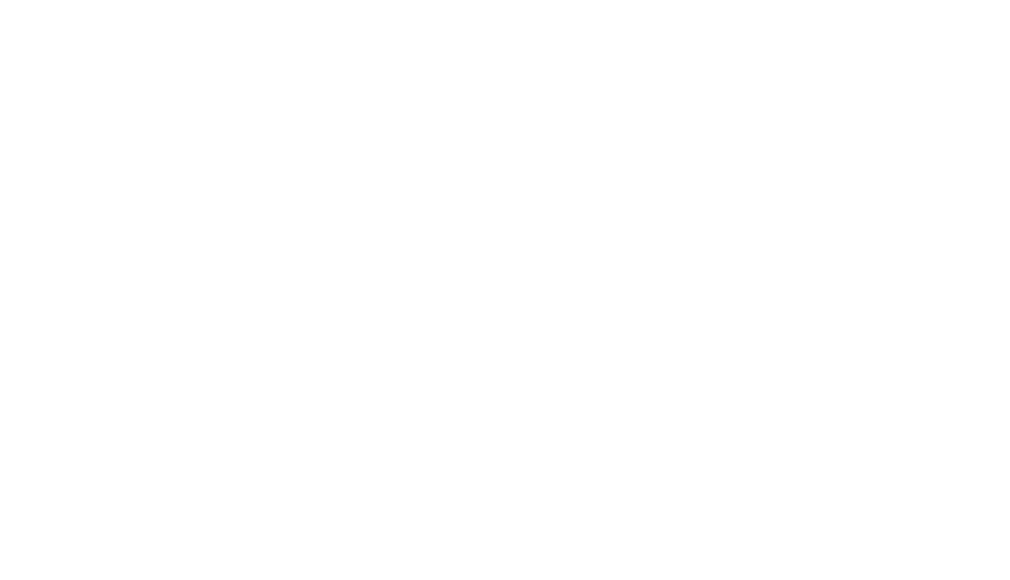

cleaning up lfp data
cleaning up speed data
found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points






 12%|█▎        | 2/16 [00:31<03:37, 15.57s/it]

<IPython.core.display.Javascript object>


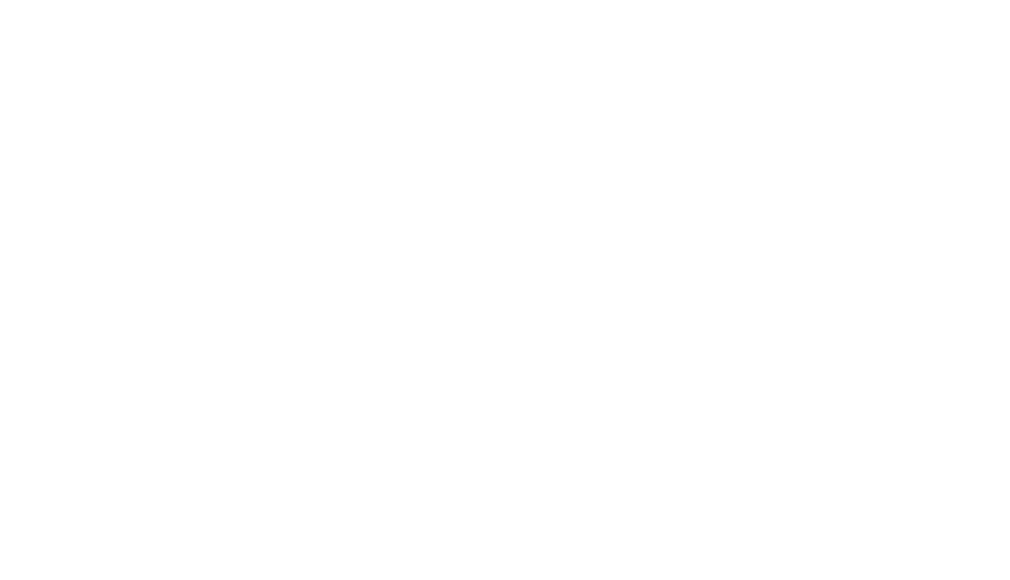

cleaning up lfp data
cleaning up speed data
found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points






 19%|█▉        | 3/16 [00:58<04:08, 19.10s/it]

<IPython.core.display.Javascript object>


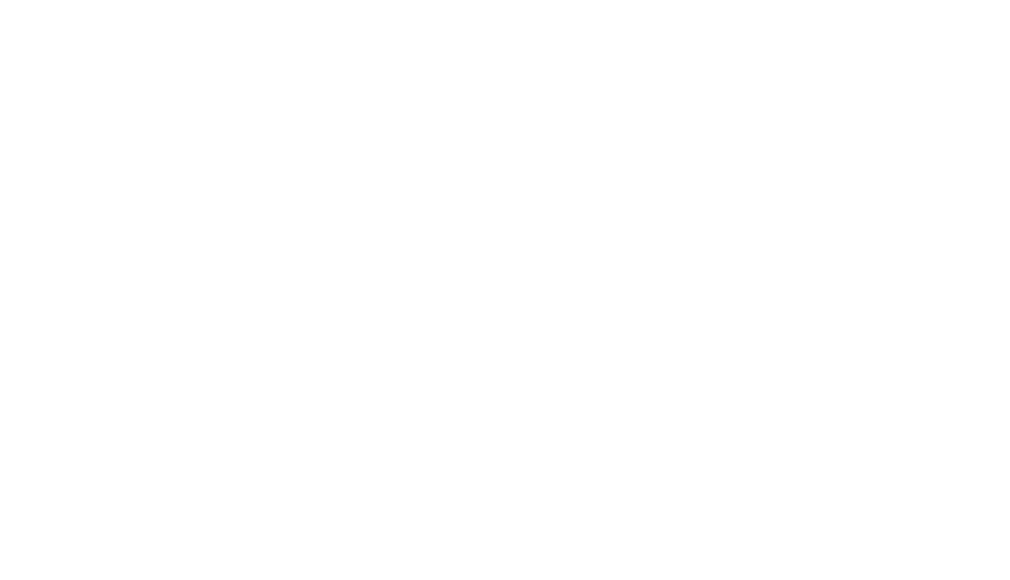

cleaning up lfp data
cleaning up speed data
found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points






 25%|██▌       | 4/16 [01:25<04:16, 21.36s/it]

<IPython.core.display.Javascript object>


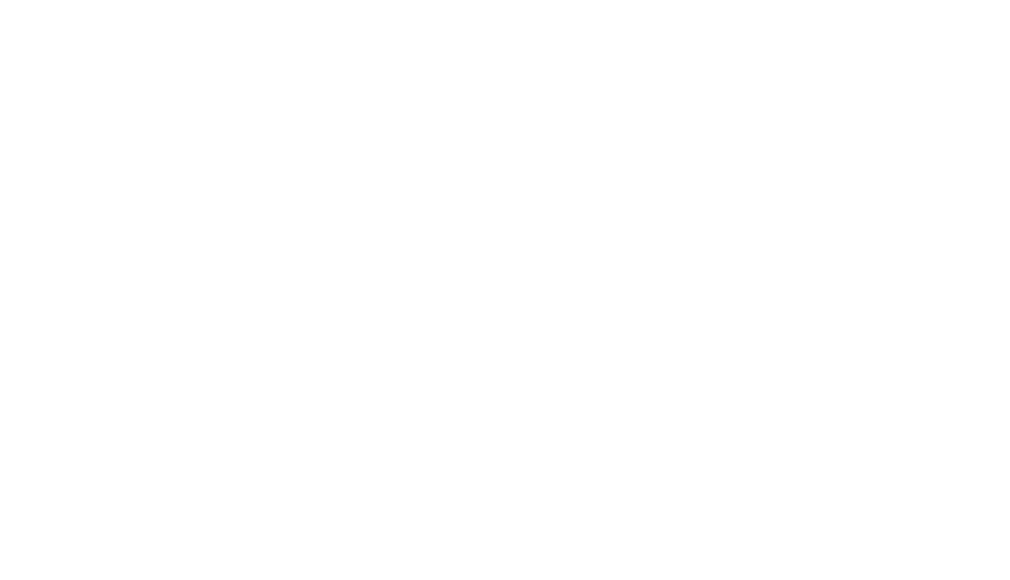

cleaning up lfp data
cleaning up speed data
found  1.0  outlier points
found  0.0  outlier points
found  0.0  outlier points






 31%|███▏      | 5/16 [01:52<04:14, 23.18s/it]

<IPython.core.display.Javascript object>


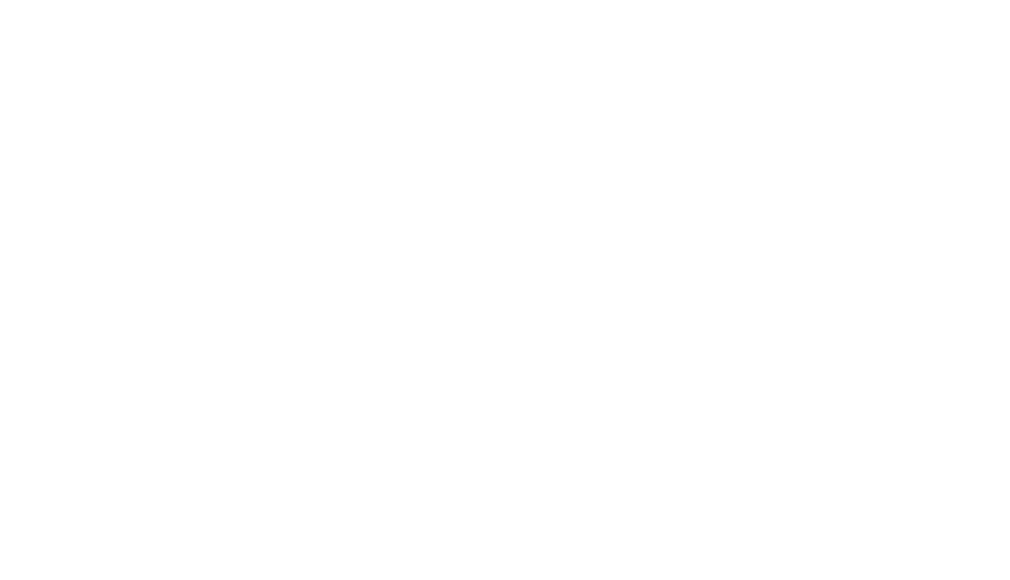

cleaning up lfp data
cleaning up speed data
found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points






 38%|███▊      | 6/16 [02:19<04:01, 24.18s/it]

<IPython.core.display.Javascript object>


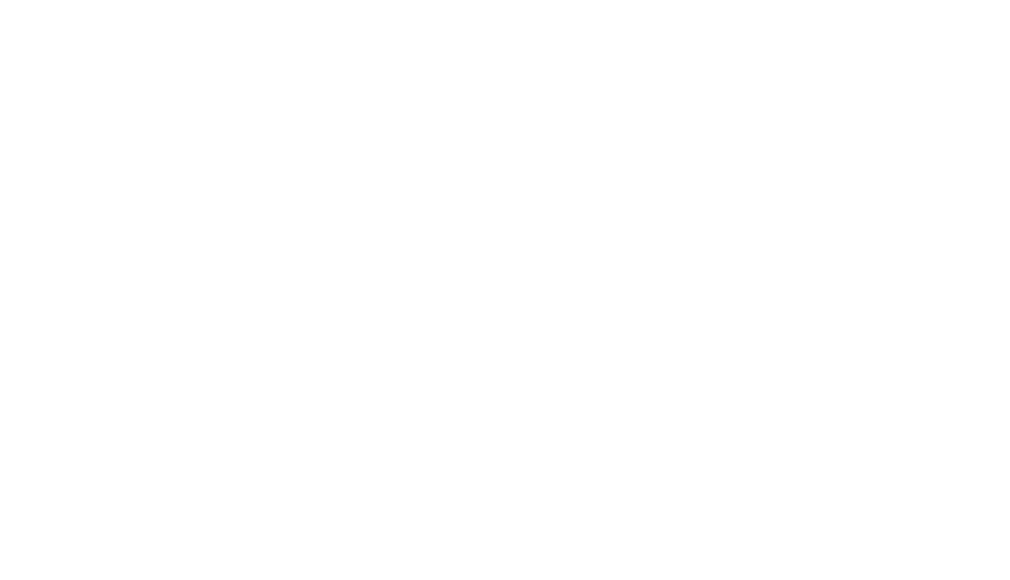

cleaning up lfp data
cleaning up speed data
found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points






 44%|████▍     | 7/16 [02:46<03:46, 25.13s/it]

<IPython.core.display.Javascript object>


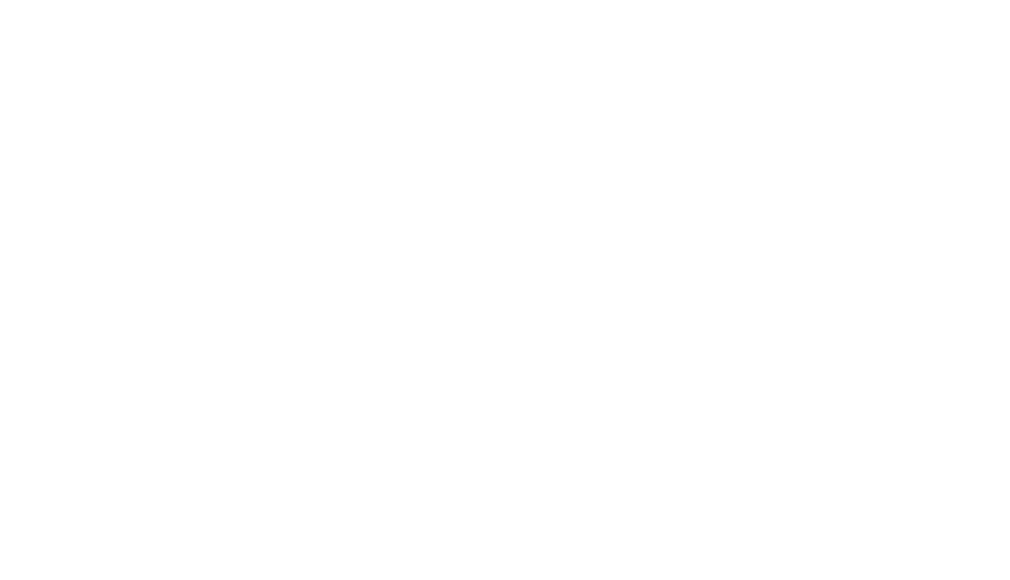

cleaning up lfp data
cleaning up speed data
found  1.0  outlier points
found  0.0  outlier points
found  0.0  outlier points






 50%|█████     | 8/16 [03:13<03:24, 25.58s/it]

<IPython.core.display.Javascript object>


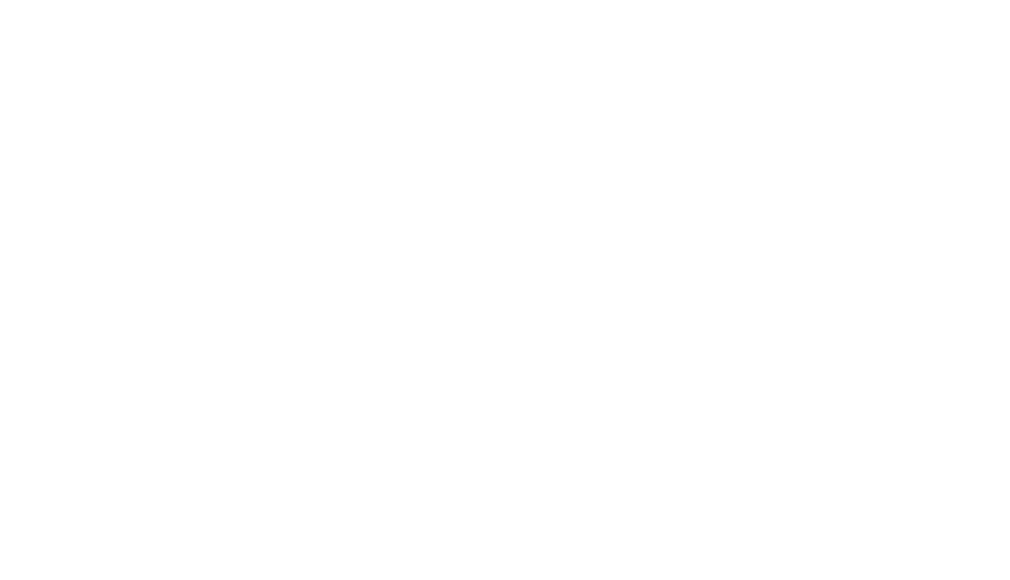

cleaning up lfp data
cleaning up speed data
found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points






 56%|█████▋    | 9/16 [03:39<03:01, 25.95s/it]

<IPython.core.display.Javascript object>


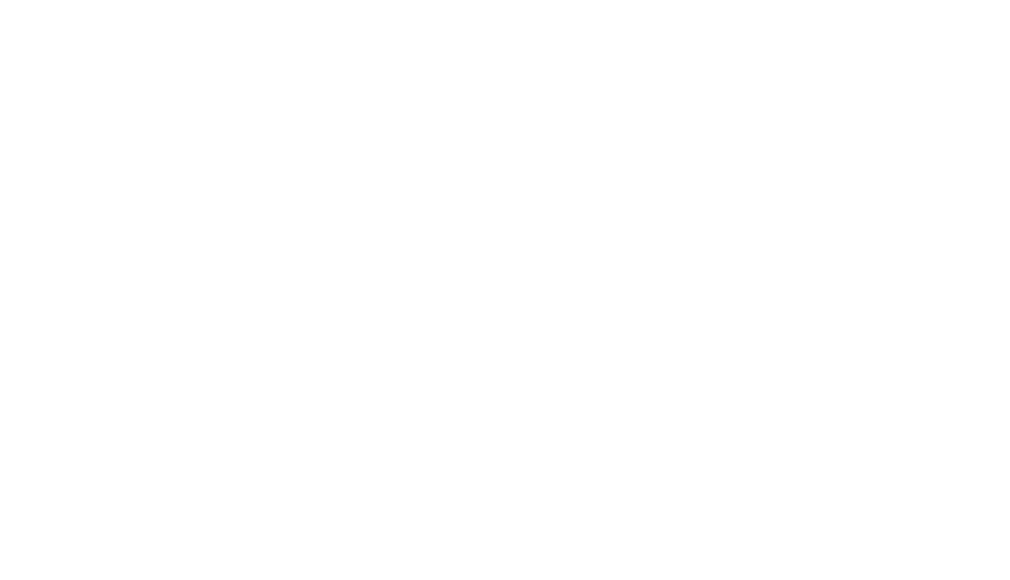

cleaning up lfp data
cleaning up speed data
found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points






 62%|██████▎   | 10/16 [04:06<02:37, 26.27s/it]

<IPython.core.display.Javascript object>


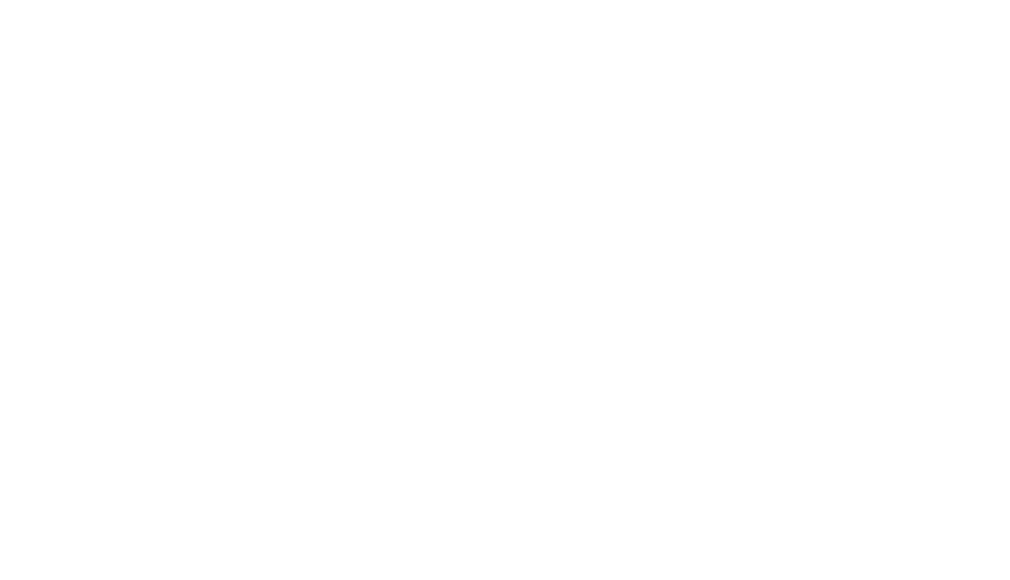

cleaning up lfp data
cleaning up speed data
found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points






 69%|██████▉   | 11/16 [04:33<02:11, 26.33s/it]

<IPython.core.display.Javascript object>


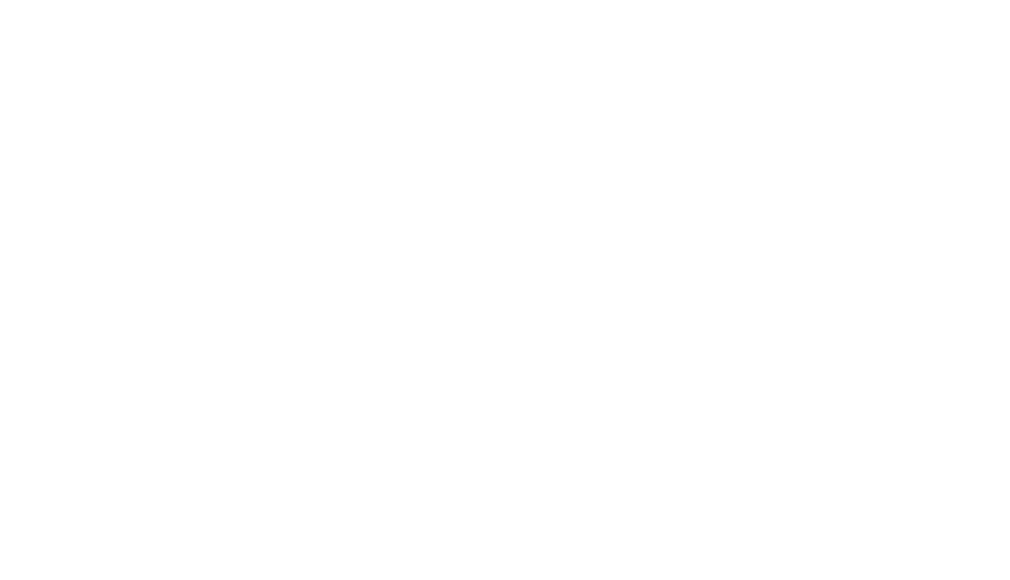

cleaning up lfp data
cleaning up speed data
found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points






 75%|███████▌  | 12/16 [04:59<01:45, 26.31s/it]

<IPython.core.display.Javascript object>


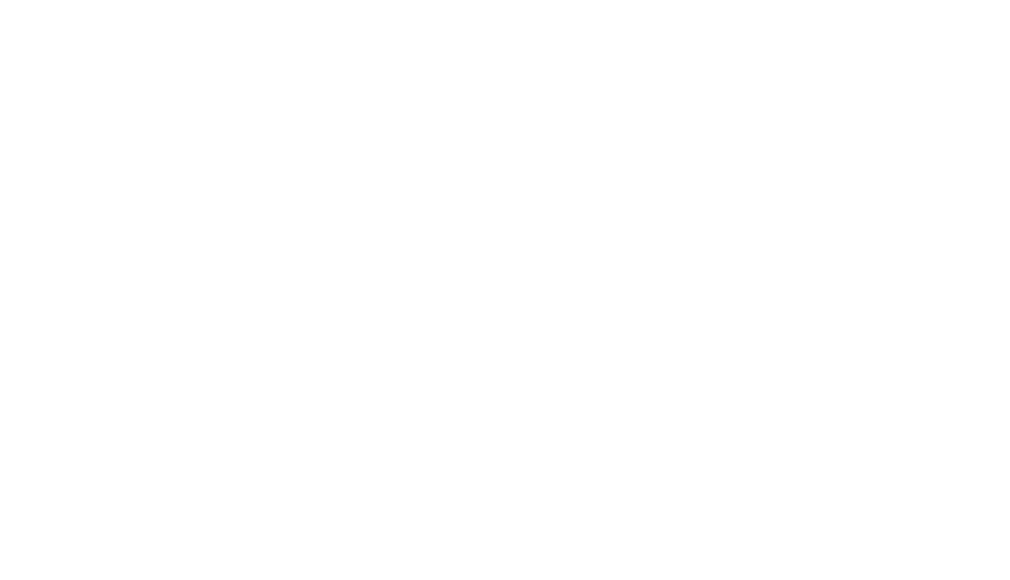

cleaning up lfp data
cleaning up speed data
found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points






 81%|████████▏ | 13/16 [05:27<01:19, 26.63s/it]

<IPython.core.display.Javascript object>


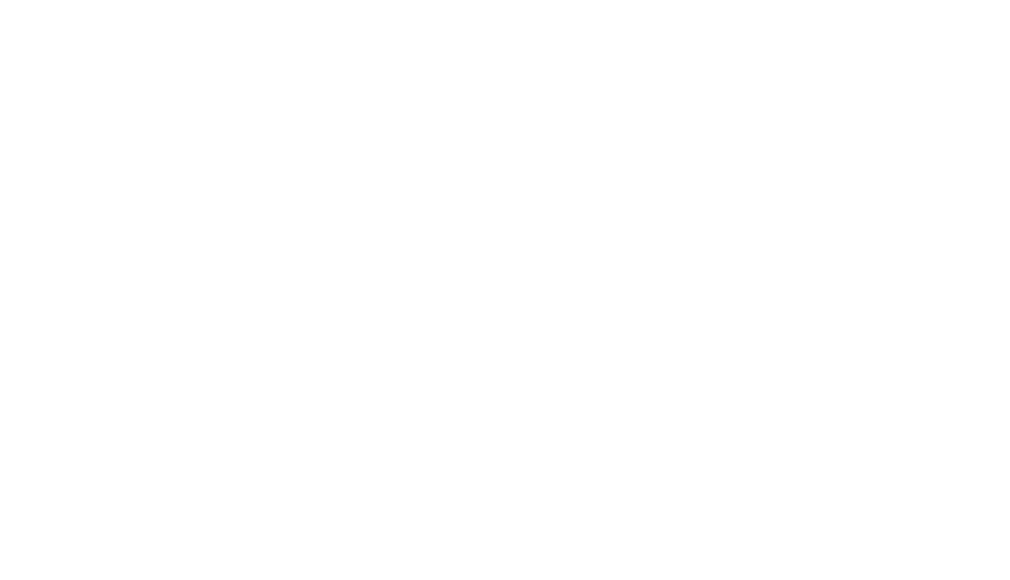

cleaning up lfp data
cleaning up speed data
found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points






 88%|████████▊ | 14/16 [05:54<00:53, 26.73s/it]

<IPython.core.display.Javascript object>


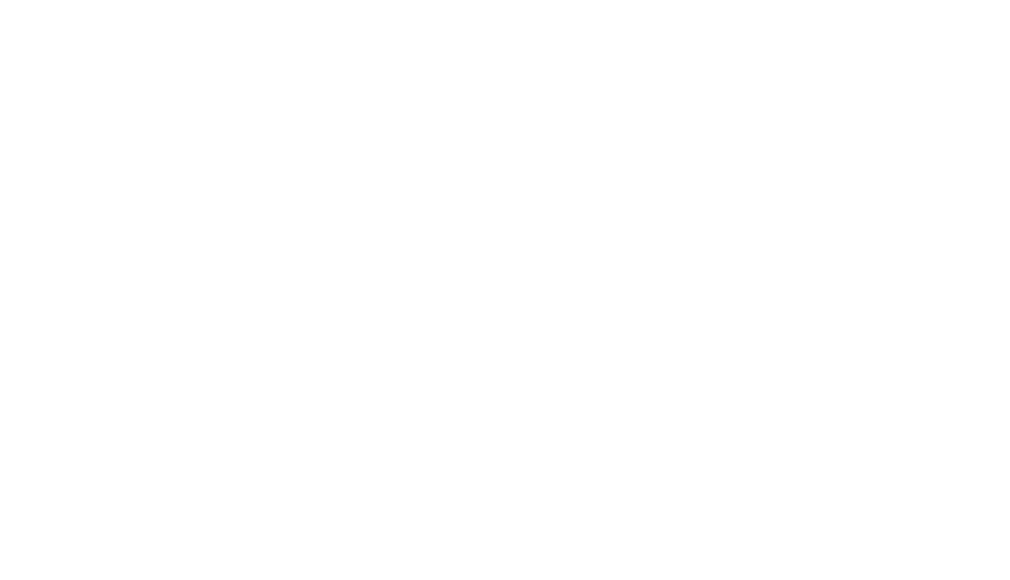

cleaning up lfp data
cleaning up speed data
found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points






 94%|█████████▍| 15/16 [06:21<00:26, 26.83s/it]

<IPython.core.display.Javascript object>


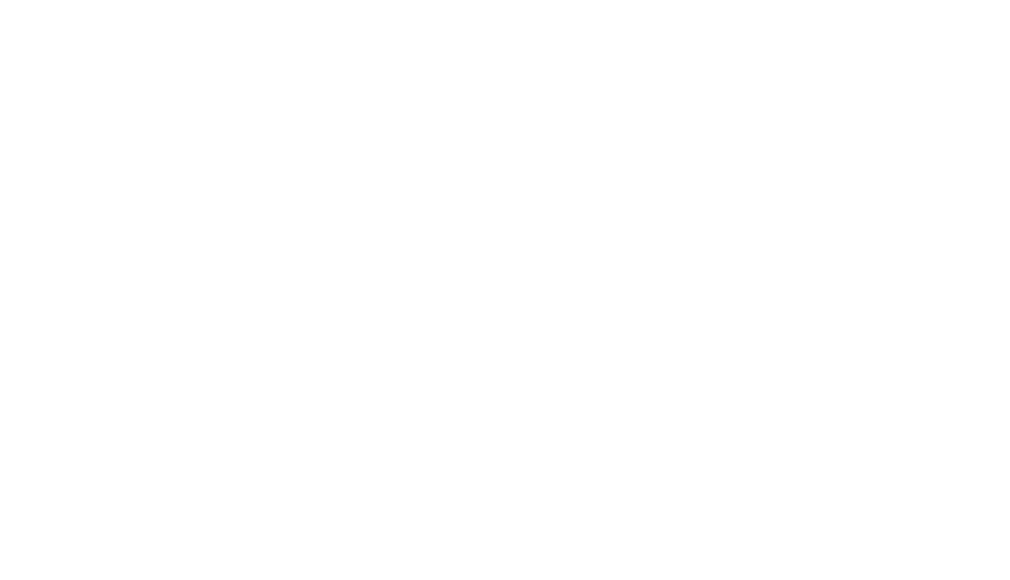

cleaning up lfp data
cleaning up speed data
found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points






100%|██████████| 16/16 [06:47<00:00, 26.84s/it]





<IPython.core.display.Javascript object>


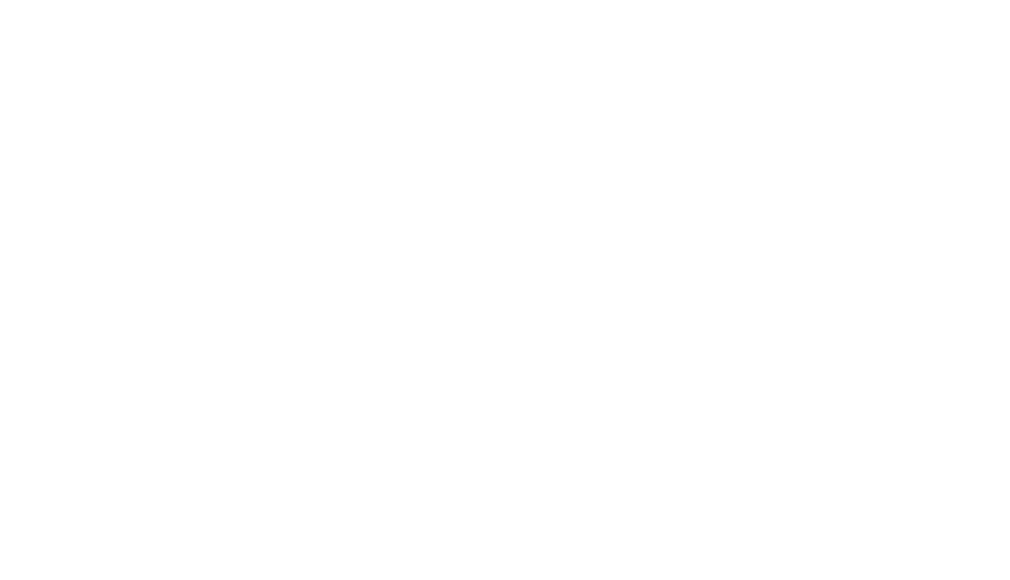

In [69]:
# spectrom in high/low mvmt
f = h5py.File('Spectograms.hdf5','r')

# global presentation params and color params:
prs = Presentation()
prs.slide_width = Inches(11)
title_layout = prs.slide_layouts[5] 
title_slide_layout = prs.slide_layouts[0]
slide = prs.slides.add_slide(title_slide_layout)
slide.shapes.title.text = 'LFP spectrom in hi/low mvmt'

lf = {'left':0.30, 'top':1.30, 'height':5.80, 'width':10.10}
fArgs = {'left':Inches(lf['left']),'top':Inches(lf['top']), 'height':Inches(lf['height']), 'width':Inches(lf['width'])}

Colors = CP('highLowSpeed')

# fig2, ax2 = plt.subplots(2,1,figsize=(lf['width'],lf['height']))
miceList = getMiceList(Files[0])
for m in tqdm(miceList):
    fig, ax = plt.subplots(1,1,figsize=(lf['width'],lf['height']))
    
    data =  getData(Files[0],['lfp','speed'],period ='Pre', mice=m,day = lambda x: x==0)
    
    for sess in data:
        # get data
        dtS = 1/data[sess]['speed']['Fs']
        dtL = 1/data[sess]['lfp']['FS']
        ts = np.arange(0, np.max(data[sess]['speed']['speed'].shape)) * dtS 
        tl = np.arange(0, np.max(data[sess]['lfp']['lfp'].shape)) * dtL
        
        
        
        HpStart = getOnsetOrPeriod(m,sess,'Pre','HighMvmtPeriods_StartSegments')
        HpEnd = getOnsetOrPeriod(m,sess,'Pre','HighMvmtPeriods_EndSegments')

        LpStart = getOnsetOrPeriod(m,sess,'Pre','LowMvmtPeriods_StartSegments')
        LpEnd = getOnsetOrPeriod(m,sess,'Pre','LowMvmtPeriods_EndSegments')
        
        Himvmt = np.full_like(tl,False)
        Lomvmt = np.full_like(tl,False)
        
        for segI, seg in enumerate(HpStart):
            si = np.argmin(np.abs(tl-ts[seg]))
            se = np.argmin(np.abs(tl-ts[HpEnd[segI]]))
            Himvmt[si:se] = True
        for segI, seg in enumerate(LpStart):
            si = np.argmin(np.abs(tl-ts[seg]))
            se = np.argmin(np.abs(tl-ts[LpEnd[segI]]))
            Lomvmt[si:se] = True
        
        
        del HpStart,LpStart,HpEnd,LpEnd
    
        freq = f[m]['freq'].value
        coeff = np.abs(f[m][sess]['Pre']['coeff'].value)
        
#         totP = np.sum(coeff,axis=0)
        
        coeff = coeff #/totP
#        coeff = coeff
        
        lfpOutliers = removeLFPOutliers(data[sess]['lfp']['lfp'], sess)
        coeff[:,(lfpOutliers[:,0]==1)] = np.nan
        coeff = coeff.T
        
        
#         ax2[0].plot(freq,np.nanmean((coeff[(Lomvmt ==1),:]/np.nanmean(totP[(Lomvmt ==1)])),axis=0),color = Colors['low'] )
#         ax2[0].plot(freq,np.nanmean((coeff[(Himvmt ==1),:])/np.nanmean(totP[(Himvmt ==1)]),axis=0),color = Colors['high'])
#         ax2[1].plot(totP)
        
#         slide = prs2.slides.add_slide(title_layout)
#         slide.shapes.title.text = sess 
#         pic = plt2pptx(slide, fig2, **fArgs)
#         fig2.clf()
        
        sessH = (coeff[(Himvmt ==1),:])
        sessL = (coeff[(Lomvmt ==1),:])
        Hs = np.sum(sessH, axis=1)
        Ls = np.sum(sessL, axis=1)
        Hs2 = sessH.T/Hs.T
        sessH = np.nanmean(Hs2.T,axis=0, keepdims=True)

        Ls2 = sessL.T/Ls.T
        sessL = np.nanmean(Ls2.T,axis=0, keepdims=True)
        
        if 'LowCoeff' in locals():
            LowCoeff = np.concatenate((LowCoeff,sessL))
        else:
            LowCoeff = sessL

        if 'HiCoeff' in locals():
            HiCoeff = np.concatenate((HiCoeff,sessH))
        else:
            HiCoeff = sessH
                                                     
#    freq = f[m][sess]['Pre']['freq'].value

    
    

    ax.plot(freq,np.nanmean(HiCoeff, axis=0),color = Colors['high'] )
    ax.plot(freq,np.nanmean(LowCoeff, axis=0),color = Colors['low'] )

    
    if 'HHc2' in locals():
        HHc2 = np.concatenate((HHc2,HiCoeff), axis = 0)
    else:
        HHc2 = HiCoeff

    del HiCoeff

    if 'HLc2' in locals():
        HLc2 = np.concatenate((HLc2,LowCoeff), axis = 0)
    else:
        HLc2 = LowCoeff

    del LowCoeff

    
    
    slide = prs.slides.add_slide(title_layout)
    slide.shapes.title.text = m
    pic = plt2pptx(slide, fig, **fArgs)
    fig.clf()
    plt.close(fig)

fig, ax = plt.subplots(1,1,figsize=(lf['width'],lf['height']))
ax.plot(freq,np.nanmean(HHc2,axis=0),color = Colors['high'] )
ax.plot(freq,np.nanmean(HLc2,axis=0),color = Colors['low'] )
                                                     
                                                     
slide = prs.slides.add_slide(title_layout)
slide.shapes.title.text = 'all Mice' 
pic = plt2pptx(slide, fig, **fArgs)
fig.clf()
plt.close(fig)
    

        
prs.save('ppts/PSD_hiLo_mice2.pptx')


In [100]:
hC = np.nanmean(HHc2.T,axis=1)
hS2 = np.nanstd(HHc2.T,axis=1)
print(hC[0:2], hC.shape, np.sum(HHc2[13,:]))
lC = np.nanmean(HLc2.T,axis=1)
lS2 = np.nanstd(HLc2.T,axis=1)
print(lC[0:2], lC.shape, np.sum(HLc2[15,:]))


[0.02633089 0.03192749] (87,) 1.000000000000001
[0.03049212 0.03639405] (87,) 1.0000000000000009


<IPython.core.display.Javascript object>


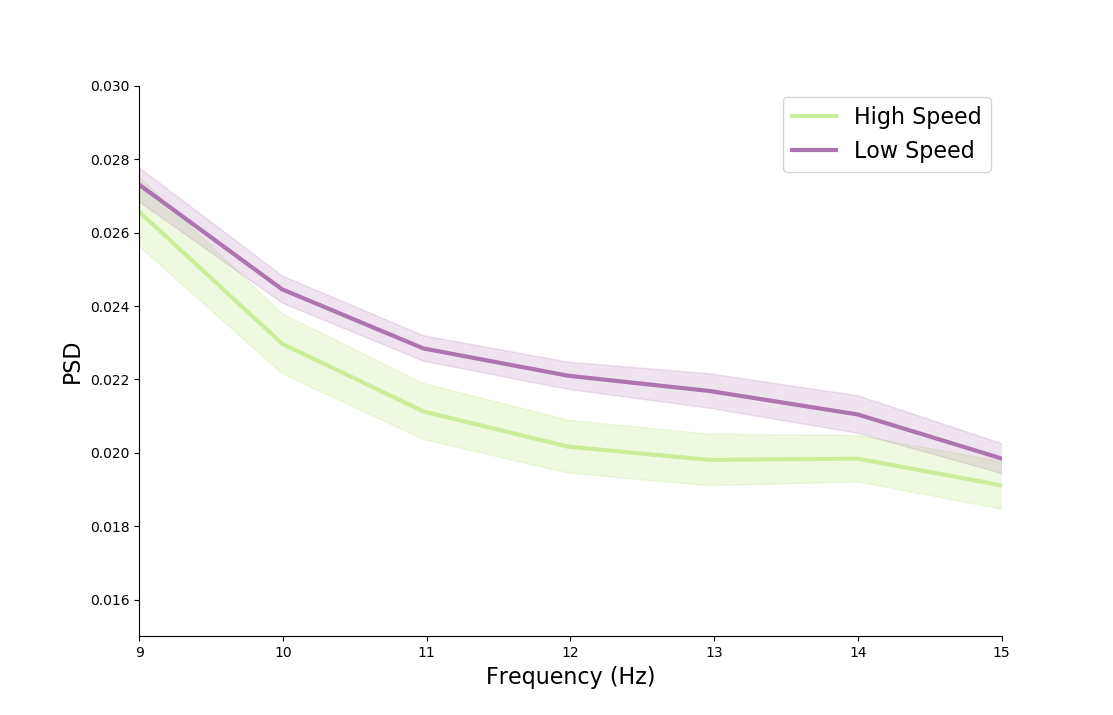

In [144]:
lS=lS2/np.sqrt(48)
hS=hS2/np.sqrt(48)
#hC2 = hC
#lC2 = lC
hC= hC2
lC= lC2
fig, ax = plt.subplots(1,1,figsize=(11.13,7.15))
ax.plot(freq,hC,color = Colors['high'], label='High Speed',linewidth=3.0)
#ax.plot(freq,hC,color = 'lightgreen', label='High Speed')
ax.fill_between(freq, hC-hS, hC+hS,color=Colors['high'],alpha=0.3)
ax.plot(freq,lC,color = Colors['low'], label='Low Speed',linewidth=3.0)
ax.fill_between(freq, lC-lS, lC+lS,color=Colors['low'],alpha=0.2)
#ax.set_xlim(6,40)
ax.set_xlim(9,15)
ax.set_ylim(0.015,0.03)
ax.set_ylabel('PSD',fontsize=16)
#ax.axes.get_yaxis().set_ticks([])
ax.set_xlabel('Frequency (Hz)',fontsize=16)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.legend(fontsize=16)

fig.savefig('figs/ZoomBeta_in_highLow',transparent=True,format='png')
fig.savefig('figs/ZoomBeta_in_highLow_il',transparent=True,format='eps')

<IPython.core.display.Javascript object>


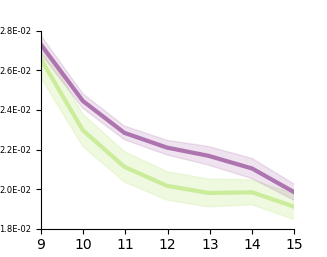

In [205]:
from matplotlib.ticker import FormatStrFormatter
lS=lS2/np.sqrt(48)
hS=hS2/np.sqrt(48)
#hC2 = hC
#lC2 = lC
hC= hC2
lC= lC2
fig, ax = plt.subplots(1,1,figsize=(3.27,2.57))

ax.plot(freq,hC,color = Colors['high'], label='High Speed',linewidth=3.0)
#ax.plot(freq,hC,color = 'lightgreen', label='High Speed')
ax.fill_between(freq, hC-hS, hC+hS,color=Colors['high'],alpha=0.3)
ax.plot(freq,lC,color = Colors['low'], label='Low Speed',linewidth=3.0)
ax.fill_between(freq, lC-lS, lC+lS,color=Colors['low'],alpha=0.2)
#ax.set_xlim(6,40)
ax.set_xlim(9,15)
ax.set_ylim(0.018,0.028)
ax.set_ylabel('PSD',fontsize=10)

#ax.axes.get_yaxis().set_ticks([])
ax.set_yticklabels(ax.axes.get_yticks(),fontsize=6)
ax.yaxis.set_major_formatter(FormatStrFormatter('%.1E'))
#ax.yaxis.get_major_formatter.set_useMathText(True)
ax.set_xlabel('Frequency (Hz)',fontsize=16)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
#ax.legend(fontsize=16)

fig.savefig('figs/ZoomBeta_in_highLow',transparent=True,format='png')
fig.savefig('figs/ZoomBeta_in_highLow_il',transparent=True,format='eps')

In [166]:
freq

array([  4.99742   ,   5.99952388,   6.99944452,   7.9888948 ,
         8.99339237,   9.99484   ,  10.97754609,  11.9833422 ,
        12.9678094 ,  13.99888905,  14.95959712,  15.94995372,
        16.95421007,  17.95151654,  18.99434323,  19.98967999,
        20.99833357,  21.90256803,  22.88818359,  23.96668439,
        24.87846043,  25.86235434,  26.92727482,  27.91241902,
        28.9723843 ,  29.91919424,  30.92997783,  31.78914388,
        32.93263826,  33.90842014,  34.94379175,  35.76278687,
        36.91642515,  37.83170842,  38.79353151,  39.80553668,
        40.87175642,  41.99666714,  42.78165158,  43.59654018,
        44.87879136,  45.77636719,  46.71057876,  47.68371582,
        48.69826297,  49.75692086,  50.86263021,  51.43412044,
        52.61651401,  53.85454963,  54.49567522,  55.82483803,
        56.51403356,  57.94476859,  58.68765024,  59.44982752,
        60.23206209,  61.85995566,  62.70735231,  63.57828776,
        64.4737566 ,  65.39481027,  66.34256114,  67.31

<IPython.core.display.Javascript object>


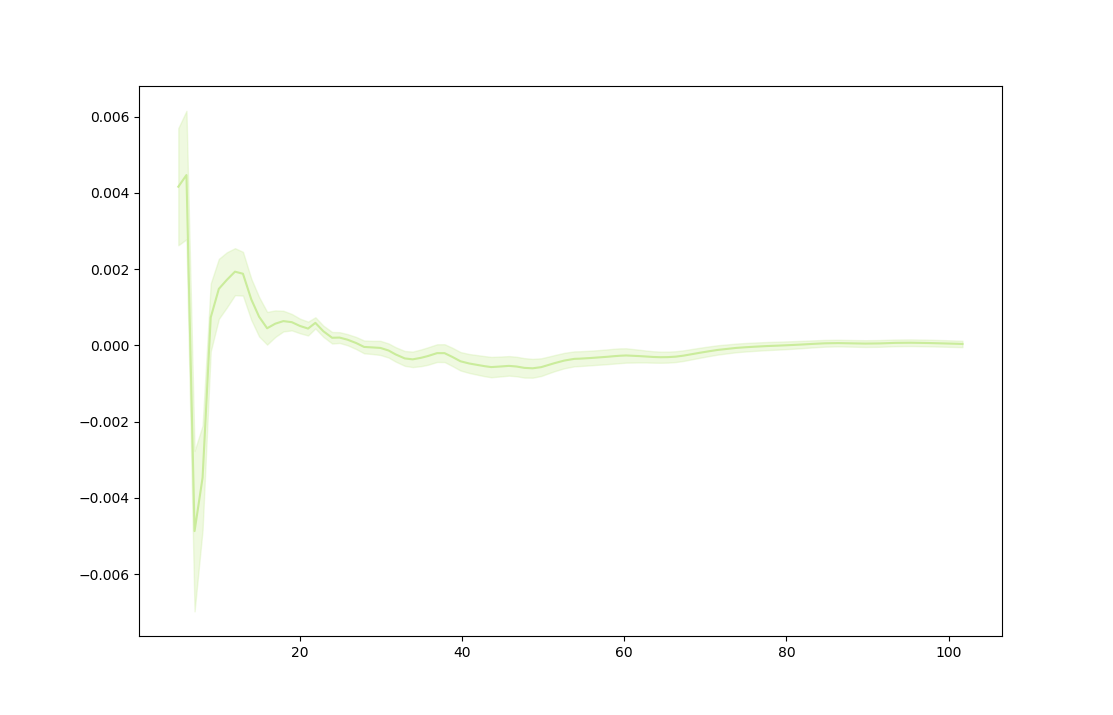

AttributeError: 'AxesSubplot' object has no attribute 'axoline'

In [125]:
dif = HLc2 - HHc2
sd = np.nanstd(dif,axis=0)/np.sqrt(48)
mu = np.nanmean(dif, axis=0)

fig, ax = plt.subplots(1,1,figsize=(11.13,7.15))
ax.plot(freq,mu,color = Colors['high'])
ax.fill_between(freq, mu-sd, mu+sd,color=Colors['high'],alpha=0.3)
ax.axoline(y=0,color='red')#,linestyle='dash')
# ax.plot(freq,lC,color = Colors['low'], label='Low Speed')
# ax.fill_between(freq, lC-lS, lC+lS,color=Colors['low'],alpha=0.2)
# #ax.set_xlim(6,40)
ax.set_xlim(7,35)
# #ax.set_ylim(0.010,0.050)
# ax.set_ylabel('PSD',fontsize=16)
# #ax.axes.get_yaxis().set_ticks([])
# ax.set_xlabel('Frequency (Hz)',fontsize=16)
# ax.spines['right'].set_visible(False)
# ax.spines['top'].set_visible(False)
# ax.legend(fontsize=16)

<IPython.core.display.Javascript object>


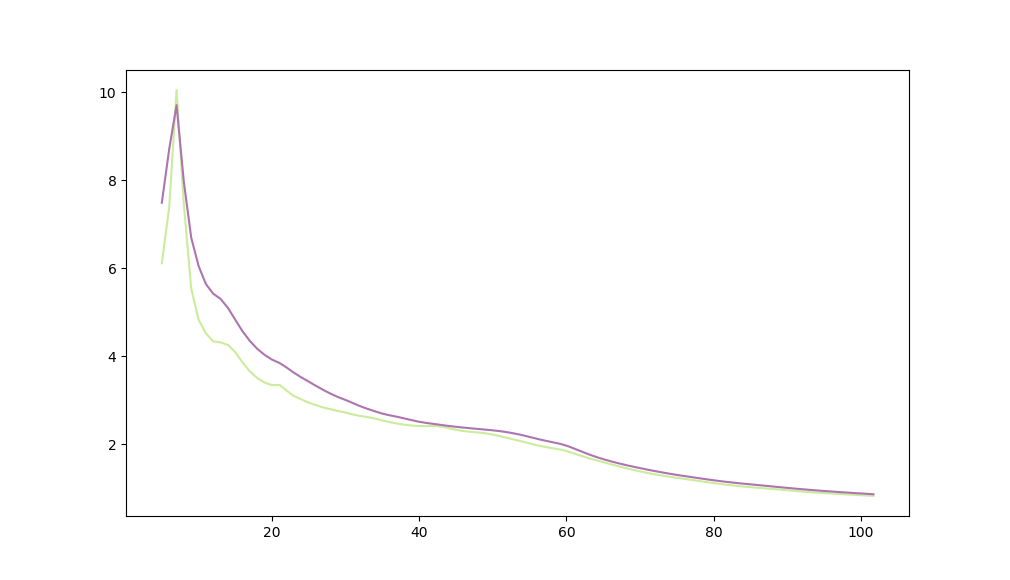

In [6]:
fig, ax = plt.subplots(1,1,figsize=(lf['width'],lf['height']))
ax.plot(freq,np.nanmean(HHc,axis=0),color = Colors['high'] )
ax.plot(freq,np.nanmean(HLc,axis=0),color = Colors['low'] )


In [ ]:
# spectrom in high/low mvmt
f = h5py.File('Spectograms.hdf5','r')

# global presentation params and color params:
prs = Presentation()
prs.slide_width = Inches(11)
title_layout = prs.slide_layouts[5] 
title_slide_layout = prs.slide_layouts[0]
slide = prs.slides.add_slide(title_slide_layout)
slide.shapes.title.text = 'LFP spectrom in hi/low mvmt'

prs2 = Presentation()
prs2.slide_width = Inches(11)
slide = prs2.slides.add_slide(title_slide_layout)
slide.shapes.title.text = 'LFP spectrom in hi/low mvmt - per session'

lf = {'left':0.30, 'top':1.30, 'height':5.80, 'width':10.10}
fArgs = {'left':Inches(lf['left']),'top':Inches(lf['top']), 'height':Inches(lf['height']), 'width':Inches(lf['width'])}

Colors = CP('highLowSpeed')

fig2, ax2 = plt.subplots(2,1,figsize=(lf['width'],lf['height']))
miceList = getMiceList(Files[0])
for m in tqdm(miceList):
    fig, ax = plt.subplots(2,1,figsize=(lf['width'],lf['height']))
    
    data =  getData(Files[0],['lfp','speed'],period ='Pre', mice=m,day = lambda x: x==0)
    
    for sess in data:
        # get data
        dtS = 1/data[sess]['speed']['Fs']
        dtL = 1/data[sess]['lfp']['FS']
        ts = np.arange(0, np.max(data[sess]['speed']['speed'].shape)) * dtS 
        tl = np.arange(0, np.max(data[sess]['lfp']['lfp'].shape)) * dtL
        
        
        
        HpStart = getOnsetOrPeriod(m,sess,'Pre','HighMvmtPeriods_StartSegments')
        HpEnd = getOnsetOrPeriod(m,sess,'Pre','HighMvmtPeriods_EndSegments')

        LpStart = getOnsetOrPeriod(m,sess,'Pre','LowMvmtPeriods_StartSegments')
        LpEnd = getOnsetOrPeriod(m,sess,'Pre','LowMvmtPeriods_EndSegments')
        
        Himvmt = np.full_like(tl,False)
        Lomvmt = np.full_like(tl,False)
        
        for segI, seg in enumerate(HpStart):
            si = np.argmin(np.abs(tl-ts[seg]))
            se = np.argmin(np.abs(tl-ts[HpEnd[segI]]))
            Himvmt[si:se] = True
        for segI, seg in enumerate(LpStart):
            si = np.argmin(np.abs(tl-ts[seg]))
            se = np.argmin(np.abs(tl-ts[LpEnd[segI]]))
            Lomvmt[si:se] = True
        
        
        del HpStart,LpStart,HpEnd,LpEnd
    
        freq = f[m]['freq'].value
        coeff = np.abs(f[m][sess]['Pre']['coeff'].value)
        
        totP = np.sum(coeff,axis=0)
        
        coeff = coeff/totP
#        coeff = coeff
        
        lfpOutliers = removeLFPOutliers(data[sess]['lfp']['lfp'], sess)
        coeff[:,(lfpOutliers[:,0]==1)] = np.nan
        coeff = coeff.T
        
        
        ax2[0].plot(freq,np.nanmean((coeff[(Lomvmt ==1),:]/np.nanmean(totP[(Lomvmt ==1)])),axis=0),color = Colors['low'] )
        ax2[0].plot(freq,np.nanmean((coeff[(Himvmt ==1),:])/np.nanmean(totP[(Himvmt ==1)]),axis=0),color = Colors['high'])
        ax2[1].plot(totP)
        
        slide = prs2.slides.add_slide(title_layout)
        slide.shapes.title.text = sess 
        pic = plt2pptx(slide, fig2, **fArgs)
        fig2.clf()


        
        if 'LowCoeff' in locals():
            LowCoeff = np.concatenate((LowCoeff,(coeff[(Lomvmt ==1),:]/np.nanmean(totP[(Lomvmt ==1)]))), axis = 0)
        else:
            LowCoeff = coeff[(Lomvmt ==1),:]/np.nanmean(totP[(Lomvmt ==1)])

        if 'HiCoeff' in locals():
            HiCoeff = np.concatenate((HiCoeff,(coeff[(Himvmt ==1),:]/np.nanmean(totP[(Himvmt ==1)]))), axis = 0)
        else:
            HiCoeff = (coeff[(Himvmt ==1),:]/np.nanmean(totP[(Himvmt ==1)]))
                                                     
#    freq = f[m][sess]['Pre']['freq'].value

    ax[0].plot(freq,np.nanmean(HiCoeff,axis=0),color = Colors['high'] )
    ax[0].plot(freq,np.nanmean(LowCoeff,axis=0),color = Colors['low'] )

    
    if 'HHc' in locals():
        HHc = np.concatenate((HHc,HiCoeff), axis = 0)
    else:
        HHC = HiCoeff

    del HiCoeff

    if 'HLc' in locals():
        HLc = np.concatenate((HLc,LowCoeff), axis = 0)
    else:
        HLC = LowCoeff

    del LowCoeff

    
    data =  getData(Files[0],['lfp','speed'],period ='Pre', mice=m,day = lambda x: x>3)
    
    for sess in data:
        # get data
        dtS = 1/data[sess]['speed']['Fs']
        dtL = 1/data[sess]['lfp']['FS']
        ts = np.arange(0, np.max(data[sess]['speed']['speed'].shape)) * dtS 
        tl = np.arange(0, np.max(data[sess]['lfp']['lfp'].shape)) * dtL
        
        
        
        HpStart = getOnsetOrPeriod(m,sess,'Pre','HighMvmtPeriods_StartSegments')
        HpEnd = getOnsetOrPeriod(m,sess,'Pre','HighMvmtPeriods_EndSegments')

        LpStart = getOnsetOrPeriod(m,sess,'Pre','LowMvmtPeriods_StartSegments')
        LpEnd = getOnsetOrPeriod(m,sess,'Pre','LowMvmtPeriods_EndSegments')
        
        Himvmt = np.full_like(tl,False)
        Lomvmt = np.full_like(tl,False)
        
        for segI, seg in enumerate(HpStart):
            si = np.argmin(np.abs(tl-ts[seg]))
            se = np.argmin(np.abs(tl-ts[HpEnd[segI]]))
            Himvmt[si:se] = True
        for segI, seg in enumerate(LpStart):
            si = np.argmin(np.abs(tl-ts[seg]))
            se = np.argmin(np.abs(tl-ts[LpEnd[segI]]))
            Lomvmt[si:se] = True
        
        
        del HpStart,LpStart,HpEnd,LpEnd
    
        freq = f[m]['freq'].value
        coeff = np.abs(f[m][sess]['Pre']['coeff'].value)
        
        totP = np.sum(coeff,axis=0)
        
        coeff = coeff/totP
#       coeff = coeff.T
        
        lfpOutliers = removeLFPOutliers(data[sess]['lfp']['lfp'], sess)
        coeff[:,(lfpOutliers[:,0]==1)] = np.nan
        coeff = coeff.T
        
        
        ax2[0].plot(freq,np.nanmean((coeff[(Lomvmt ==1),:]/np.nanmean(totP[(Lomvmt ==1)])),axis=0),color = Colors['low'] )
        ax2[0].plot(freq,np.nanmean((coeff[(Himvmt ==1),:])/np.nanmean(totP[(Himvmt ==1)]),axis=0),color = Colors['high'])
        ax2[1].plot(totP)
        
        slide = prs2.slides.add_slide(title_layout)
        slide.shapes.title.text = sess 
        pic = plt2pptx(slide, fig2, **fArgs)
        fig2.clf()

        
        if 'LowCoeff' in locals():
            LowCoeff = np.concatenate((LowCoeff,(coeff[(Lomvmt ==1),:]/np.nanmean(totP[(Lomvmt ==1)]))), axis = 0)
        else:
            LowCoeff = coeff[(Lomvmt ==1),:]/np.nanmean(totP[(Lomvmt ==1)])

        if 'HiCoeff' in locals():
            HiCoeff = np.concatenate((HiCoeff,(coeff[(Himvmt ==1),:]/np.nanmean(totP[(Himvmt ==1)]))), axis = 0)
        else:
            HiCoeff = (coeff[(Himvmt ==1),:]/np.nanmean(totP[(Himvmt ==1)]))
    if 'HiCoeff' in locals():
        ax[1].plot(freq,np.nanmean(HiCoeff,axis=0),color = Colors['high'] )
    if 'LowCoeff' in locals():   
        ax[1].plot(freq,np.nanmean(LowCoeff,axis=0),color = Colors['low'] )

    if 'HiCoeff' in locals():
        if 'PHc' in locals():
            PHc = np.concatenate((PHc,HiCoeff), axis = 0)
        else:
            PHc = HiCoeff

        del HiCoeff
    if 'LowCoeff' in locals():   
        if 'PLc' in locals():
            PLc = np.concatenate((PLc,LowCoeff), axis = 0)
        else:
            PLc = LowCoeff

        del LowCoeff
    
    slide = prs.slides.add_slide(title_layout)
    slide.shapes.title.text = m
    pic = plt2pptx(slide, fig, **fArgs)
    fig.clf()
    plt.close(fig)

fig, ax = plt.subplots(2,1,figsize=(lf['width'],lf['height']))
ax[1].plot(freq,np.nanmean(PHc,axis=0),color = Colors['high'] )
ax[1].plot(freq,np.nanmean(PLc,axis=0),color = Colors['low'] )
ax[0].plot(freq,np.nanmean(HHc,axis=0),color = Colors['high'] )
ax[0].plot(freq,np.nanmean(HLc,axis=0),color = Colors['low'] )
                                                     
                                                     
slide = prs.slides.add_slide(title_layout)
slide.shapes.title.text = 'all Mice' 
pic = plt2pptx(slide, fig, **fArgs)
fig.clf()
plt.close(fig)
    

        
prs.save('ppts/PSD_hiLo_mice.pptx')
prs2.save('ppts/PSD_hiLo_sess.pptx')

<IPython.core.display.Javascript object>


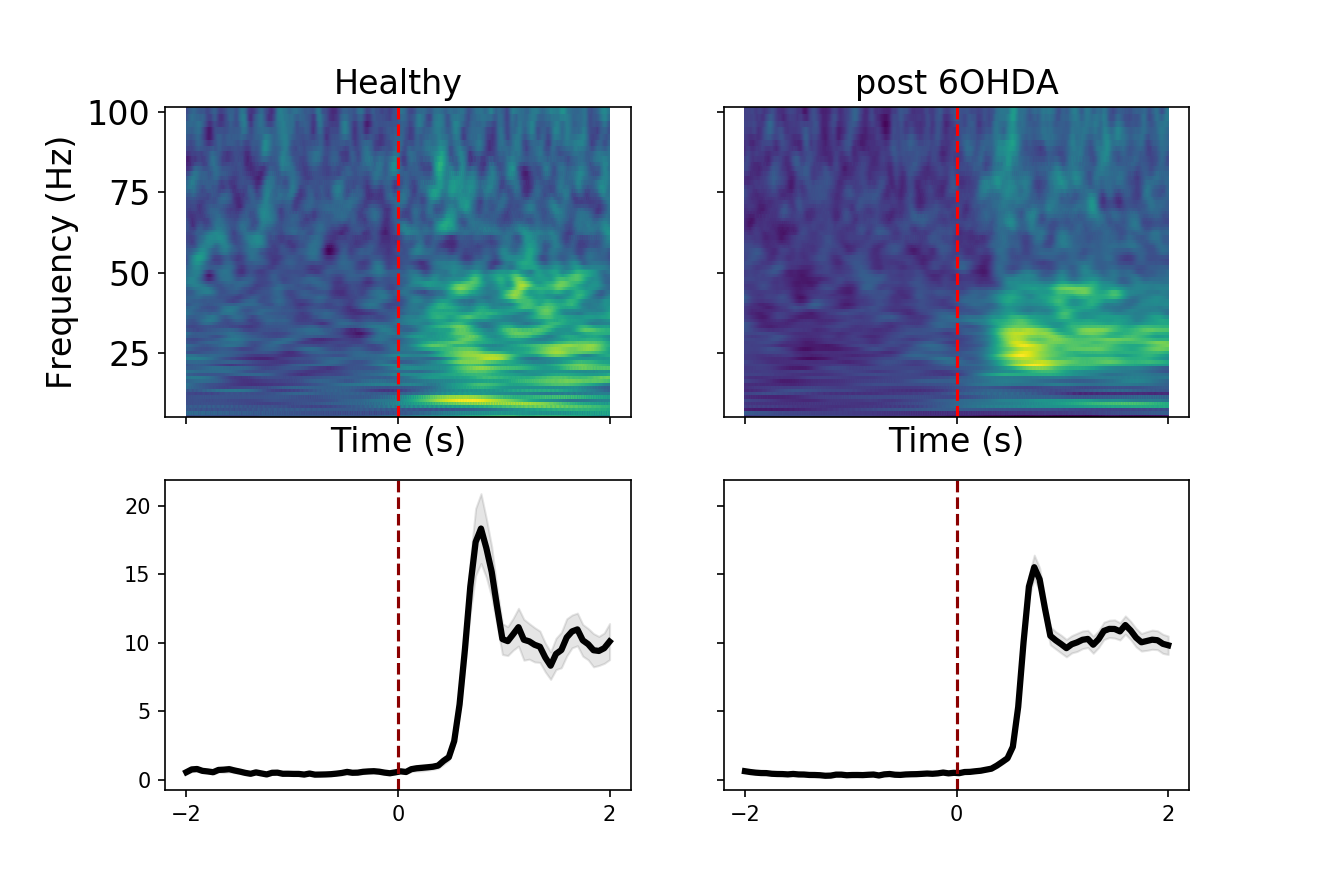

cleaning up lfp data
cleaning up speed data


/home/dana_z/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: DeprecationWarning: object of type <class 'numpy.ndarray'> cannot be safely interpreted as an integer.
  from ipykernel import kernelapp as app
/home/dana_z/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: DeprecationWarning: object of type <class 'numpy.ndarray'> cannot be safely interpreted as an integer.
  app.launch_new_instance()


found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points
(12206, 87, 21) (12206, 87, 17)
cleaning up lfp data
cleaning up speed data


/home/dana_z/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:88: DeprecationWarning: object of type <class 'numpy.ndarray'> cannot be safely interpreted as an integer.


found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points
found  0.0  outlier points


In [4]:
# align spectogram to mvmt onset -> for each mouse and in total:
f = h5py.File('Spectograms.hdf5','r')
m = '1793'

fig, ax = plt.subplots(2,2,figsize=(8.81,5.92),sharex='col',sharey='row')  
data =  getData(Files[0],['lfp','speed'],period ='Pre', mice=m,day = lambda x: x==0)

for sess in data:
    # get data
    dtS = 1/data[sess]['speed']['Fs']
    dtL = 1/data[sess]['lfp']['FS']
    ts = np.arange(0, np.max(data[sess]['speed']['speed'].shape)) * dtS 
    tl = np.arange(0, np.max(data[sess]['lfp']['lfp'].shape)) * dtL

    tPlot = np.linspace(-2,2,4/dtL)
    tPlotS = np.linspace(-2,2,4/dtS)

    mvmtOnset = getOnsetOrPeriod(m,sess,'Pre','mvmtOnset')
    mvmtOnsetL = np.full_like(tl,False)
    for si in ts[mvmtOnset]:
        ti = np.argmin(np.abs(tl-si))
        mvmtOnsetL[ti] = True

        

#        del mvmtOnset

#        freq = f[m]['freq'].value
    coeff = np.abs(f[m][sess]['Pre']['coeff'].value)

    #        totP = np.sum(coeff,axis=1)
    #        coeff = coeff.T/totP.T
    #        coeff = coeff.T

    lfpOutliers = removeLFPOutliers(data[sess]['lfp']['lfp'], sess)
    coeff[:,(lfpOutliers[:,0]==1)] = np.nan
    coeff = coeff.T#*freq

    al = alignToOnset(coeff,(mvmtOnsetL==1), winPost =2/dtL, winPre = 2/dtL)

    if al.ndim <3:
        continue

    if 'aligned' in locals():
        print(aligned.shape,al.shape)
        aligned = np.concatenate((aligned,al), axis = 2)
    else:
        aligned = al

    alS = alignToOnset(data[sess]['speed']['speed'].T,(mvmtOnset==1), winPost =2/dtS, winPre = 2/dtS)

    if alS.ndim <2:
        continue

    if 'alignedS' in locals():
        alignedS = np.concatenate((alignedS,alS), axis = 1)
    else:
        alignedS = alS

freq = f[m]['freq'].value
d = np.nanmean(aligned,axis=2)
d = d/np.mean(d[:int(d.shape[0]/2),:],axis=0)

im = ax[0,0].pcolormesh(tPlot,freq,d.transpose())
#    cbar=plt.colorbar(im,ax=ax[0,0])
#    cbar.set_label(label='Power',size=16)
ax[0,0].axvline(x=0.0,color='red',linestyle='dashed')
ax[0,0].set_title('Healthy',fontsize=16)
ax[0,0].set_ylabel('Frequency (Hz)',fontsize=16)
ax[0,0].set_xlabel('Time (s)',fontsize=16)
ax[0,0].tick_params(axis = 'y',labelsize=16)
ax[0,0].tick_params(axis = 'x',labelsize=16)

PlotRelativeToOnset(ax[1,0],alignedS,tPlotS,Color='black',Label='speed',mesErr=True)

Hspec = aligned
Hspeed = alignedS
del aligned,alignedS
data =  getData(Files[0],['lfp','speed'],period ='Pre', mice=m,day = lambda x: x>3)

for sess in data:
    # get data
    dtS = 1/data[sess]['speed']['Fs']
    dtL = 1/data[sess]['lfp']['FS']
    ts = np.arange(0, np.max(data[sess]['speed']['speed'].shape)) * dtS 
    tl = np.arange(0, np.max(data[sess]['lfp']['lfp'].shape)) * dtL

    tPlot = np.linspace(-2,2,4/dtL)

    mvmtOnset = getOnsetOrPeriod(m,sess,'Pre','mvmtOnset')
    mvmtOnsetL = np.full_like(tl,False)
    for si in ts[mvmtOnset]:
        ti = np.argmin(np.abs(tl-si))
        mvmtOnsetL[ti] = True
    #        del mvmtOnset

    #        freq = f[m][sess]['Pre']['freq'].value
    coeff = np.abs(f[m][sess]['Pre']['coeff'].value)

    #        totP = np.sum(coeff,axis=1)
    #        coeff = coeff.T/totP.T
    #        coeff = coeff.T

    lfpOutliers = removeLFPOutliers(data[sess]['lfp']['lfp'], sess)
    coeff[:,(lfpOutliers[:,0]==1)] = np.nan

    coeff = coeff.T#*freq
    al = alignToOnset(coeff,(mvmtOnsetL==1), winPost =2/dtL, winPre = 2/dtL)

    if al.ndim <3:
        continue

    if 'aligned' in locals():
        aligned = np.concatenate((aligned,al), axis = 2)
    else:
        aligned = al

    alS = alignToOnset(data[sess]['speed']['speed'].T,(mvmtOnset==1), winPost =2/dtS, winPre = 2/dtS)

    if alS.ndim <2:
        continue

    if 'alignedS' in locals():
        alignedS = np.concatenate((alignedS,alS), axis = 1)
    else:
        alignedS = alS

if 'aligned' in locals():
    d = np.nanmean(aligned,axis=2)
    d = d/np.mean(d[:int(d.shape[0]/2),:],axis=0)

    im = ax[0,1].pcolormesh(tPlot,freq,d.transpose())
    #        cbar=plt.colorbar(im,ax=ax[0,1])
    #        cbar.set_label(label='Power',size=16)
    ax[0,1].axvline(x=0.0,color='red',linestyle='dashed')
    ax[0,1].set_title('post 6OHDA',fontsize=16)
    #        ax[0,1].set_ylabel('Frequency (Hz)',fontsize=16)
    ax[0,1].set_xlabel('Time (s)',fontsize=16)
    ax[0,1].tick_params(axis = 'y',labelsize=16)
    ax[0,1].tick_params(axis = 'x',labelsize=16)

    PlotRelativeToOnset(ax[1,1],alignedS,tPlotS,Color='black',Label='speed',mesErr=True)


<IPython.core.display.Javascript object>


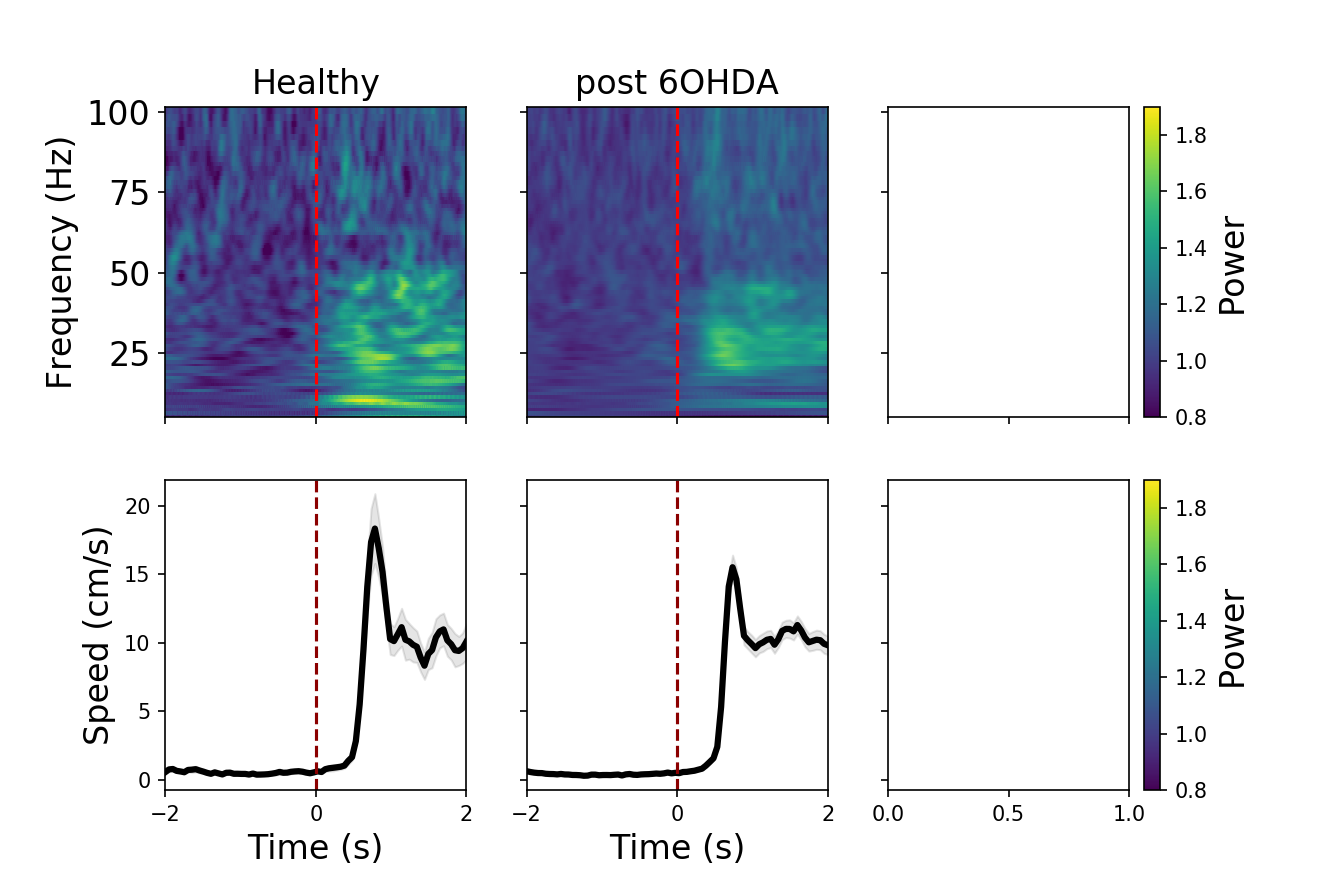

In [13]:
fig, ax = plt.subplots(2,3,figsize=(8.81,5.92),sharex='col',sharey='row')  
freq = f[m]['freq'].value
d = np.nanmean(Hspec,axis=2)
d = d/np.mean(d[:int(d.shape[0]/2),:],axis=0)

im = ax[0,0].pcolormesh(tPlot,freq,d.transpose(),vmin=0.8,vmax=1.9)
cbar=plt.colorbar(im,ax=ax[0,2])
cbar.set_label(label='Power',size=16)
ax[0,0].axvline(x=0.0,color='red',linestyle='dashed')
ax[0,0].set_title('Healthy',fontsize=16)
ax[0,0].set_ylabel('Frequency (Hz)',fontsize=16)
ax[1,0].set_xlabel('Time (s)',fontsize=16)
ax[0,0].tick_params(axis = 'y',labelsize=16)
ax[0,0].tick_params(axis = 'x',labelsize=16)

PlotRelativeToOnset(ax[1,0],Hspeed,tPlotS,Color='black',Label='speed',mesErr=True)

d = np.nanmean(aligned,axis=2)
d = d/np.mean(d[:int(d.shape[0]/2),:],axis=0)

im = ax[0,1].pcolormesh(tPlot,freq,d.transpose(),vmin=0.8,vmax=1.9)
cbar=plt.colorbar(im,ax=ax[1,2])
cbar.set_label(label='Power',size=16)
ax[0,1].axvline(x=0.0,color='red',linestyle='dashed')
ax[0,1].set_title('post 6OHDA',fontsize=16)
#        ax[0,1].set_ylabel('Frequency (Hz)',fontsize=16)
ax[1,1].set_xlabel('Time (s)',fontsize=16)
ax[0,1].tick_params(axis = 'y',labelsize=16)
ax[0,1].tick_params(axis = 'x',labelsize=16)

PlotRelativeToOnset(ax[1,1],alignedS,tPlotS,Color='black',Label='speed',mesErr=True)
ax[0,0].set_xlim(-2,2)
ax[0,1].set_xlim(-2,2)
ax[1,0].set_ylabel('Speed (cm/s)',fontsize=16)

fig.savefig('figs/neuralActivity.png',transparent=True,format='png')
fig.savefig('figs/neuralActivity.svg',transparent=True,format='svg')

In [17]:
baselines = getData(Files[0],['lfp'],period ='Pre',mice = ['8430','4539','7909','7584','1222'],day = lambda x: int(x)==0)
early = getData(Files[0],['lfp'],period ='Pre',mice = ['8430','4539','7909','7584','1222'],day = lambda x: (int(x)<= 4) & (x>0))
mid = getData(Files[0],['lfp'],period ='Pre',mice = ['8430','4539','7909','7584','1222'],day = lambda x: (int(x)> 5) & (x<=8))
late = getData(Files[0],['lfp'],period ='Pre',mice = ['8430','4539','7909','7584','1222'],day = lambda x: (int(x)> 9) & (x<=14))

cleaning up lfp data
cleaning up lfp data
cleaning up lfp data
cleaning up lfp data


In [31]:
f = h5py.File('Spectograms.hdf5','r')
cond = ['baselines','early','mid','late']
Names = {'baselines':'Pre 6OHDA','early':'days 1-4','mid':'days 6-8' ,'late':'days 10-14'}
Colors = {'baselines':'steelblue','early':'darkorange','mid':'red' ,'late':'black'}

for c in cond:
    data = eval(c)
    spec = np.empty((87,1))
    for sess in data:
        m = sess[0:4]
        coeff = np.abs(f[m][sess]['Pre']['coeff'].value)
        lfpOutliers = removeLFPOutliers(data[sess]['lfp']['lfp'], sess)
        coeff[:,(lfpOutliers[:,0]==1)] = np.nan
        spec = np.concatenate((spec,np.nanmean(coeff,axis=1,keepdims=True)),axis=1)
    M = np.nanmean(spec,axis=1)
    Std = np.nanstd(spec,axis=1)

#     M,Std, f = getPowerSpec(eval(c))
#     plt.plot(f, M, linewidth=3,color=Colors[c],label=Names[c])
#     plt.fill_between(f, M-Std, M+Std,color=Colors[c],alpha=0.1)
# plt.ylabel('PSD',fontsize=12)
# plt.xlabel('Frequency',fontsize=12)
# plt.legend(fontsize=12)
# plt.xlim((8,30))

found  0.0  outlier points
(87, 2)
found  0.0  outlier points
(87, 3)


KeyboardInterrupt: 

In [30]:
print(np.nanmean(coeff,axis=1,keepdims=True).shape,spec.shape)

(87, 1) (87, 1)
